### Deep Learning Assignment
### Code for the Transformer part
#### Marius Schmidt-Mengin

In [ ]:
!pip install tokenizers
!pip install transformers
!pip install datasets
!git clone https://github.com/marius-sm/sign_language_translation

In [2]:
import time
import torch
from torch import nn
from torch.nn import functional as F
import os
import tokenizers
from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
import transformers
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cycler
from matplotlib.ticker import MaxNLocator

from sign_language_translation.phoenix_data import data_from_file, PhoenixDataset
from sign_language_translation.training import train_model

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Customize matplotlib styles

In [4]:
colors = cycler('color', ['#EE6666', '#3388BB', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#FFFFFF', edgecolor='#E6E6E6', axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='#E6E6E6', linestyle='solid')
plt.rc('xtick', direction='out', color='#000000')
plt.rc('xtick.major', width=0)
plt.rc('ytick.major', width=0)
plt.rc('ytick', direction='out', color='#000000')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('legend', framealpha=0.9)
plt.rc('lines', linewidth=2)
plt.rc('font', size=13)

## Load data

In [5]:
train_data = data_from_file('sign_language_translation/data/train.annotations_only')
dev_data = data_from_file('sign_language_translation/data/dev.annotations_only')

## Create tokenizer

In [6]:
def create_tokenizer(sentence_list):
    filename = f'temp_{time.strftime("%Y%m%d-%H%M%S")}.txt'
    with open(filename, 'w') as f:
        for s in sentence_list:
            f.write(f'{s}\n')

    tokenizer = Tokenizer(WordPiece())
    tokenizer.pre_tokenizer = Whitespace()
    tokenizer.decoder = tokenizers.decoders.WordPiece()
    tokenizer.enable_padding(pad_token='[PAD]', pad_id=0)

    trainer = WordPieceTrainer(vocab_size=3000, special_tokens=['[PAD]', '[S]', '[/S]', '[UNK]', '[MASK]'])
    tokenizer.train(trainer, [filename])

    os.remove(filename)

    return tokenizer

In [7]:
train_sentences = [d['text'] for d in train_data]
tokenizer = create_tokenizer(train_sentences)

## Create input pipeline

In [8]:
train_dataset = PhoenixDataset(train_data, source_mode='text', target_mode=None)
valid_dataset = PhoenixDataset(dev_data, source_mode='text', target_mode=None)

In [9]:
def mask(token_ids):
    token_ids = token_ids.clone()
    i1, i2 = torch.randint(low=0, high=len(token_ids[token_ids > 0]), size=(2,))
    token_ids[i1] = 4
    token_ids[i2] = 4
    return token_ids

def collate_fn(inputs):
    encoded_inputs = [tokenizer.encode(inp) for inp in inputs]
    encoded_inputs = tokenizer.encode_batch(inputs)
    
    token_ids_batch = torch.tensor([e.ids for e in encoded_inputs], dtype=torch.long)
    token_ids_masked_batch = [mask(t) for t in token_ids_batch]
    attention_mask_batch = [e.attention_mask for e in encoded_inputs]
    
    return torch.stack(token_ids_masked_batch, dim=0), token_ids_batch, torch.tensor(attention_mask_batch, dtype=torch.long)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True, collate_fn=collate_fn)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

source, target, attention_mask = next(iter(trainloader))

print('Source sentence is:\n     ', tokenizer.decode(source[0].tolist(), skip_special_tokens=False))
print('Target sentence is:\n     ', tokenizer.decode(target[0].tolist(), skip_special_tokens=False))

Source sentence is:
      der [MASK] [MASK] oft freundlich später zieht von westen regen heran. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Target sentence is:
      der donnerstag beginnt oft freundlich später zieht von westen regen heran. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


## Modify BERT to add Layer Norm before self-attention and FFN, and remove the other ones (Pre LN)

In [10]:
class PreLNBertSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        # self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps) # remove layer norm here
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        # hidden_states = self.LayerNorm(hidden_states + input_tensor) # remove layer norm here
        hidden_states = hidden_states + input_tensor
        return hidden_states


class PreLNBertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps) # add layer norm before self attention
        self.self = transformers.models.bert.modeling_bert.BertSelfAttention(config)
        self.output = transformers.models.bert.modeling_bert.BertSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.self.num_attention_heads, self.self.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        self_outputs = self.self(
            self.LayerNorm(hidden_states), # add layer norm before self attention
            #hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions,
        )
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add layer norms if we output them
        return outputs

class PreLNBertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps) # add layer norm before dense
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = transformers.activations.ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.LayerNorm(hidden_states) # add layer norm before dense
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class PreLNBertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        # self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps) # remove layer norm here
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        # hidden_states = self.LayerNorm(hidden_states + input_tensor) # remove layer norm here
        hidden_states = hidden_states + input_tensor
        return hidden_states

## Original Transformer (Post LN)

In [11]:
class PostLNBertSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class PostLNBertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self = transformers.models.bert.modeling_bert.BertSelfAttention(config)
        self.output = transformers.models.bert.modeling_bert.BertSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.self.num_attention_heads, self.self.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        self_outputs = self.self(
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions,
        )
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add layer norms if we output them
        return outputs

class PostLNBertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = transformers.activations.ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class PostLNBertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

## Build BERT

In [12]:
def make_bert(pre_ln, depth):

    if pre_ln:
        transformers.models.bert.modeling_bert.BertSelfOutput = PreLNBertSelfOutput
        transformers.models.bert.modeling_bert.BertAttention = PreLNBertAttention
        transformers.models.bert.modeling_bert.BertIntermediate = PreLNBertIntermediate
        transformers.models.bert.modeling_bert.BertOutput = PreLNBertOutput
    else:
        transformers.models.bert.modeling_bert.BertSelfOutput = PostLNBertSelfOutput
        transformers.models.bert.modeling_bert.BertAttention = PostLNBertAttention
        transformers.models.bert.modeling_bert.BertIntermediate = PostLNBertIntermediate
        transformers.models.bert.modeling_bert.BertOutput = PostLNBertOutput

    bert_config = transformers.BertConfig(
        vocab_size=tokenizer.get_vocab_size(),
        hidden_size=256,
        num_hidden_layers=depth,
        num_attention_heads=4,
        intermediate_size=1024
    )

    bert = transformers.BertForMaskedLM(bert_config)
    bert.optimizer = torch.optim.Adam(bert.parameters(), 1e-3)
    bert.to(device);

    # for p in bert.parameters():
    #     p.register_hook(lambda grad: torch.clamp(grad, -0.001, 0.001))

    return bert

### Define training step

In [13]:
def training_step_fn(model, batch):

    source_ids, target_ids, attention_mask = batch
    source_ids, target_ids, attention_mask = source_ids.to(device), target_ids.to(device), attention_mask.to(device)

    outputs = model(
        input_ids=source_ids,
        attention_mask=attention_mask
    )
                        
    logits = outputs.logits
    vocab_size = logits.shape[-1]
    mask = (source_ids == 4).float()
    num_samples = mask.sum()
    
    loss = F.cross_entropy(logits.view(-1, vocab_size), target_ids.view(-1), reduce=False)
    loss *= mask.flatten()
    summed_loss = loss.sum()
            
    predicted = logits.argmax(2)
    num_correct_samples = ((predicted == target_ids).float()*mask).sum()
    
    return num_samples, num_correct_samples, summed_loss

### Choose layers to monitor during training add backward hooks

In [14]:
def monitor_weights(bert):

    monitored_weights = []
    for i, l in enumerate(bert.bert.encoder.layer):
        monitored_weights.append({'name': 'value', 'depth': i, 'tensor': l.attention.self.value.weight, 'hist': []})
        monitored_weights.append({'name': 'key', 'depth': i, 'tensor': l.attention.self.key.weight, 'hist': []})
        monitored_weights.append({'name': 'query', 'depth': i, 'tensor': l.attention.self.query.weight, 'hist': []})
        monitored_weights.append({'name': 'att_output', 'depth': i, 'tensor': l.attention.output.dense.weight, 'hist': []})
        monitored_weights.append({'name': 'dense_1', 'depth': i, 'tensor': l.intermediate.dense.weight, 'hist': []})
        monitored_weights.append({'name': 'dense_2', 'depth': i, 'tensor': l.output.dense.weight, 'hist': []})

    def make_hook(w):
        def hook(grad):
            w['hist'].append(grad.view(-1)[w['idx']].clone().cpu())
        return hook

    for w in monitored_weights:
        torch.manual_seed(0)
        w['idx'] = torch.randperm(w['tensor'].numel())[:1000]
        w['tensor'].register_hook(make_hook(w))

    return monitored_weights

## Run the experiments

In [15]:
def run_experiment(bert_depth, epochs=4):

    print(f'\nTraining Post-LN, depth = {bert_depth} ================================================')

    # create post LN bert
    bert = make_bert(pre_ln=False, depth=bert_depth)
    monitored_weights_post = monitor_weights(bert)
    torch.save(bert.state_dict(), 'weights.pth') # save the initial weights

    torch.manual_seed(0)
    train_losses_post, train_accuracies_post, val_losses_post, val_accuracies_post = train_model(
        bert,
        training_step_fn,
        trainloader,
        validloader,
        print_every=15,
        epochs=epochs
    )

    print(f'\nTraining Pre-LN, depth = {bert_depth} ================================================')

    # create pre LN bert
    bert = make_bert(pre_ln=True, depth=bert_depth)
    monitored_weights_pre = monitor_weights(bert)
    bert.load_state_dict(torch.load('weights.pth'), strict=False) # load the weights (skipped layer norms are not a problem because layern norm is initialized with zeros and ones)

    torch.manual_seed(0)
    train_losses_pre, train_accuracies_pre, val_losses_pre, val_accuracies_pre = train_model(
        bert,
        training_step_fn,
        trainloader,
        validloader,
        print_every=15,
        epochs=epochs
    )

    return (monitored_weights_post, train_losses_post, train_accuracies_post, val_losses_post, val_accuracies_post), (monitored_weights_pre, train_losses_pre, train_accuracies_pre, val_losses_pre, val_accuracies_pre)


In [16]:
bert_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
#bert_depths = [2, 4, 6, 8, 10, 12, 15, 20, 25, 30, 40]
per_depth_outputs = {}
for d in bert_depths:
    a, b = run_experiment(d, epochs=10)
    per_depth_outputs[d] = (a, b)


Training Post-LN, depth = 1 ================================================


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0, iteration 15/55: running loss 6.6984, running acc 0.0659, batch loss: 5.8924, batch acc: 0.0726, running time per batch: 0.0630s (model) 0.0147s (loader)
Epoch 0, iteration 30/55: running loss 5.9406, running acc 0.0935, batch loss: 5.8480, batch acc: 0.0880, running time per batch: 0.0312s (model) 0.0159s (loader)
Epoch 0, iteration 45/55: running loss 5.6759, running acc 0.1137, batch loss: 5.6744, batch acc: 0.1355, running time per batch: 0.0232s (model) 0.0162s (loader)


100%|██████████| 5/5 [00:00<00:00, 58.15it/s]

Epoch 0: training loss 5.8961, training accuracy 0.1065
Validation accuracy 0.1593, loss 5.3539



Epoch 1, iteration 15/55: running loss 5.3235, running acc 0.1568, batch loss: 5.1507, batch acc: 0.1803, running time per batch: 0.0212s (model) 0.0149s (loader)
Epoch 1, iteration 30/55: running loss 5.3289, running acc 0.1464, batch loss: 5.3420, batch acc: 0.1480, running time per batch: 0.0206s (model) 0.0141s (loader)
Epoch 1, iteration 45/55: running loss 5.1860, running acc 0.1624, batch loss: 4.9084, batch acc: 0.1847, running time per batch: 0.0209s (model) 0.0133s (loader)


100%|██████████| 5/5 [00:00<00:00, 60.01it/s]

Epoch 1: training loss 5.2686, training accuracy 0.1530
Validation accuracy 0.1737, loss 5.1262



Epoch 2, iteration 15/55: running loss 5.1147, running acc 0.1548, batch loss: 5.0134, batch acc: 0.1633, running time per batch: 0.0220s (model) 0.0150s (loader)
Epoch 2, iteration 30/55: running loss 5.1099, running acc 0.1649, batch loss: 5.2297, batch acc: 0.1612, running time per batch: 0.0217s (model) 0.0166s (loader)
Epoch 2, iteration 45/55: running loss 5.1861, running acc 0.1536, batch loss: 5.1451, batch acc: 0.1538, running time per batch: 0.0221s (model) 0.0161s (loader)


100%|██████████| 5/5 [00:00<00:00, 52.81it/s]

Epoch 2: training loss 5.1202, training accuracy 0.1605
Validation accuracy 0.1764, loss 5.0385



Epoch 3, iteration 15/55: running loss 5.0937, running acc 0.1583, batch loss: 5.0392, batch acc: 0.1781, running time per batch: 0.0205s (model) 0.0141s (loader)
Epoch 3, iteration 30/55: running loss 5.0005, running acc 0.1686, batch loss: 4.9582, batch acc: 0.1492, running time per batch: 0.0206s (model) 0.0137s (loader)
Epoch 3, iteration 45/55: running loss 5.1046, running acc 0.1598, batch loss: 5.3291, batch acc: 0.1148, running time per batch: 0.0212s (model) 0.0156s (loader)


100%|██████████| 5/5 [00:00<00:00, 62.18it/s]

Epoch 3: training loss 5.0414, training accuracy 0.1655
Validation accuracy 0.1771, loss 4.8923



Epoch 4, iteration 15/55: running loss 5.0548, running acc 0.1716, batch loss: 4.8729, batch acc: 0.1880, running time per batch: 0.0221s (model) 0.0159s (loader)
Epoch 4, iteration 30/55: running loss 4.9636, running acc 0.1686, batch loss: 4.5446, batch acc: 0.2276, running time per batch: 0.0203s (model) 0.0151s (loader)
Epoch 4, iteration 45/55: running loss 4.9531, running acc 0.1745, batch loss: 5.2275, batch acc: 0.1633, running time per batch: 0.0208s (model) 0.0135s (loader)


100%|██████████| 5/5 [00:00<00:00, 60.06it/s]

Epoch 4: training loss 4.9846, training accuracy 0.1693
Validation accuracy 0.1712, loss 4.8459



Epoch 5, iteration 15/55: running loss 4.9564, running acc 0.1615, batch loss: 4.9122, batch acc: 0.1566, running time per batch: 0.0206s (model) 0.0138s (loader)
Epoch 5, iteration 30/55: running loss 4.8154, running acc 0.1850, batch loss: 4.4914, batch acc: 0.2343, running time per batch: 0.0198s (model) 0.0136s (loader)
Epoch 5, iteration 45/55: running loss 4.7835, running acc 0.1823, batch loss: 4.5253, batch acc: 0.2107, running time per batch: 0.0205s (model) 0.0132s (loader)


100%|██████████| 5/5 [00:00<00:00, 58.25it/s]

Epoch 5: training loss 4.8183, training accuracy 0.1806
Validation accuracy 0.1874, loss 4.6864



Epoch 6, iteration 15/55: running loss 4.7299, running acc 0.1886, batch loss: 4.4493, batch acc: 0.2218, running time per batch: 0.0232s (model) 0.0140s (loader)
Epoch 6, iteration 30/55: running loss 4.6340, running acc 0.2052, batch loss: 4.5126, batch acc: 0.2024, running time per batch: 0.0211s (model) 0.0142s (loader)
Epoch 6, iteration 45/55: running loss 4.6625, running acc 0.1991, batch loss: 4.7544, batch acc: 0.1748, running time per batch: 0.0224s (model) 0.0160s (loader)


100%|██████████| 5/5 [00:00<00:00, 63.18it/s]

Epoch 6: training loss 4.6456, training accuracy 0.2013
Validation accuracy 0.2406, loss 4.4390



Epoch 7, iteration 15/55: running loss 4.5022, running acc 0.2119, batch loss: 4.6020, batch acc: 0.2090, running time per batch: 0.0212s (model) 0.0138s (loader)
Epoch 7, iteration 30/55: running loss 4.5279, running acc 0.2104, batch loss: 4.5156, batch acc: 0.1992, running time per batch: 0.0200s (model) 0.0137s (loader)
Epoch 7, iteration 45/55: running loss 4.4114, running acc 0.2349, batch loss: 4.4718, batch acc: 0.2672, running time per batch: 0.0204s (model) 0.0147s (loader)


100%|██████████| 5/5 [00:00<00:00, 62.61it/s]

Epoch 7: training loss 4.4202, training accuracy 0.2272
Validation accuracy 0.2706, loss 4.2177



Epoch 8, iteration 15/55: running loss 4.2517, running acc 0.2522, batch loss: 4.2902, batch acc: 0.2419, running time per batch: 0.0200s (model) 0.0142s (loader)
Epoch 8, iteration 30/55: running loss 4.2566, running acc 0.2588, batch loss: 4.2334, batch acc: 0.2742, running time per batch: 0.0209s (model) 0.0149s (loader)
Epoch 8, iteration 45/55: running loss 4.1846, running acc 0.2573, batch loss: 3.9480, batch acc: 0.2480, running time per batch: 0.0209s (model) 0.0139s (loader)


100%|██████████| 5/5 [00:00<00:00, 62.15it/s]

Epoch 8: training loss 4.1977, training accuracy 0.2608
Validation accuracy 0.2894, loss 4.0065



Epoch 9, iteration 15/55: running loss 4.0310, running acc 0.2764, batch loss: 3.8908, batch acc: 0.2840, running time per batch: 0.0213s (model) 0.0138s (loader)
Epoch 9, iteration 30/55: running loss 3.9785, running acc 0.2847, batch loss: 4.2506, batch acc: 0.2213, running time per batch: 0.0212s (model) 0.0141s (loader)
Epoch 9, iteration 45/55: running loss 3.9520, running acc 0.2847, batch loss: 3.8477, batch acc: 0.3292, running time per batch: 0.0205s (model) 0.0147s (loader)


100%|██████████| 5/5 [00:00<00:00, 52.48it/s]

Epoch 9: training loss 3.9695, training accuracy 0.2835
Validation accuracy 0.3384, loss 3.6646

Finished Training

Training Pre-LN, depth = 1 ================================================


Epoch 0, iteration 15/55: running loss 6.7030, running acc 0.0659, batch loss: 5.8829, batch acc: 0.0726, running time per batch: 0.0220s (model) 0.0181s (loader)
Epoch 0, iteration 30/55: running loss 5.9306, running acc 0.0981, batch loss: 5.8550, batch acc: 0.1000, running time per batch: 0.0217s (model) 0.0148s (loader)
Epoch 0, iteration 45/55: running loss 5.6586, running acc 0.1178, batch loss: 5.6640, batch acc: 0.1394, running time per batch: 0.0211s (model) 0.0151s (loader)


100%|██████████| 5/5 [00:00<00:00, 48.22it/s]

Epoch 0: training loss 5.8865, training accuracy 0.1102
Validation accuracy 0.1603, loss 5.3203



Epoch 1, iteration 15/55: running loss 5.3086, running acc 0.1585, batch loss: 5.1400, batch acc: 0.1885, running time per batch: 0.0201s (model) 0.0164s (loader)
Epoch 1, iteration 30/55: running loss 5.3141, running acc 0.1507, batch loss: 5.3153, batch acc: 0.1520, running time per batch: 0.0210s (model) 0.0150s (loader)
Epoch 1, iteration 45/55: running loss 5.1725, running acc 0.1655, batch loss: 4.8727, batch acc: 0.1888, running time per batch: 0.0220s (model) 0.0160s (loader)


100%|██████████| 5/5 [00:00<00:00, 52.42it/s]

Epoch 1: training loss 5.2557, training accuracy 0.1561
Validation accuracy 0.1767, loss 5.1144



Epoch 2, iteration 15/55: running loss 5.1062, running acc 0.1551, batch loss: 5.0066, batch acc: 0.1633, running time per batch: 0.0221s (model) 0.0154s (loader)
Epoch 2, iteration 30/55: running loss 5.1145, running acc 0.1636, batch loss: 5.2164, batch acc: 0.1612, running time per batch: 0.0209s (model) 0.0146s (loader)
Epoch 2, iteration 45/55: running loss 5.1941, running acc 0.1543, batch loss: 5.1627, batch acc: 0.1538, running time per batch: 0.0221s (model) 0.0156s (loader)


100%|██████████| 5/5 [00:00<00:00, 54.57it/s]

Epoch 2: training loss 5.1250, training accuracy 0.1605
Validation accuracy 0.1733, loss 5.0386



Epoch 3, iteration 15/55: running loss 5.0808, running acc 0.1558, batch loss: 5.0074, batch acc: 0.1862, running time per batch: 0.0216s (model) 0.0150s (loader)
Epoch 3, iteration 30/55: running loss 4.9966, running acc 0.1681, batch loss: 4.9495, batch acc: 0.1532, running time per batch: 0.0216s (model) 0.0146s (loader)
Epoch 3, iteration 45/55: running loss 5.0963, running acc 0.1627, batch loss: 5.3162, batch acc: 0.1148, running time per batch: 0.0208s (model) 0.0145s (loader)


100%|██████████| 5/5 [00:00<00:00, 62.66it/s]

Epoch 3: training loss 5.0368, training accuracy 0.1662
Validation accuracy 0.1751, loss 4.8961



Epoch 4, iteration 15/55: running loss 5.0522, running acc 0.1734, batch loss: 4.8351, batch acc: 0.1920, running time per batch: 0.0215s (model) 0.0149s (loader)
Epoch 4, iteration 30/55: running loss 4.9550, running acc 0.1727, batch loss: 4.5389, batch acc: 0.2154, running time per batch: 0.0202s (model) 0.0137s (loader)
Epoch 4, iteration 45/55: running loss 4.9327, running acc 0.1762, batch loss: 5.2199, batch acc: 0.1796, running time per batch: 0.0219s (model) 0.0157s (loader)


100%|██████████| 5/5 [00:00<00:00, 63.74it/s]

Epoch 4: training loss 4.9757, training accuracy 0.1724
Validation accuracy 0.1732, loss 4.8773



Epoch 5, iteration 15/55: running loss 4.9516, running acc 0.1593, batch loss: 4.8766, batch acc: 0.1606, running time per batch: 0.0209s (model) 0.0144s (loader)
Epoch 5, iteration 30/55: running loss 4.8096, running acc 0.1839, batch loss: 4.4338, batch acc: 0.2469, running time per batch: 0.0203s (model) 0.0134s (loader)
Epoch 5, iteration 45/55: running loss 4.7782, running acc 0.1821, batch loss: 4.5180, batch acc: 0.2190, running time per batch: 0.0219s (model) 0.0159s (loader)


100%|██████████| 5/5 [00:00<00:00, 52.01it/s]

Epoch 5: training loss 4.8124, training accuracy 0.1790
Validation accuracy 0.2067, loss 4.6498



Epoch 6, iteration 15/55: running loss 4.6564, running acc 0.2007, batch loss: 4.3219, batch acc: 0.2500, running time per batch: 0.0222s (model) 0.0139s (loader)
Epoch 6, iteration 30/55: running loss 4.5454, running acc 0.2167, batch loss: 4.3433, batch acc: 0.2348, running time per batch: 0.0214s (model) 0.0144s (loader)
Epoch 6, iteration 45/55: running loss 4.5486, running acc 0.2129, batch loss: 4.6697, batch acc: 0.1829, running time per batch: 0.0227s (model) 0.0161s (loader)


100%|██████████| 5/5 [00:00<00:00, 55.78it/s]

Epoch 6: training loss 4.5340, training accuracy 0.2164
Validation accuracy 0.2690, loss 4.2035



Epoch 7, iteration 15/55: running loss 4.2716, running acc 0.2425, batch loss: 4.2681, batch acc: 0.2500, running time per batch: 0.0226s (model) 0.0171s (loader)
Epoch 7, iteration 30/55: running loss 4.2786, running acc 0.2526, batch loss: 4.2736, batch acc: 0.2602, running time per batch: 0.0216s (model) 0.0161s (loader)
Epoch 7, iteration 45/55: running loss 4.1634, running acc 0.2700, batch loss: 4.0641, batch acc: 0.3077, running time per batch: 0.0216s (model) 0.0161s (loader)


100%|██████████| 5/5 [00:00<00:00, 59.64it/s]

Epoch 7: training loss 4.1728, training accuracy 0.2643
Validation accuracy 0.2925, loss 3.8901



Epoch 8, iteration 15/55: running loss 3.9431, running acc 0.2942, batch loss: 3.9332, batch acc: 0.2984, running time per batch: 0.0205s (model) 0.0139s (loader)
Epoch 8, iteration 30/55: running loss 3.9217, running acc 0.2919, batch loss: 3.8551, batch acc: 0.2944, running time per batch: 0.0209s (model) 0.0141s (loader)
Epoch 8, iteration 45/55: running loss 3.8369, running acc 0.3026, batch loss: 3.5869, batch acc: 0.3049, running time per batch: 0.0210s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 53.42it/s]

Epoch 8: training loss 3.8639, training accuracy 0.3006
Validation accuracy 0.3643, loss 3.5545



Epoch 9, iteration 15/55: running loss 3.6444, running acc 0.3325, batch loss: 3.6160, batch acc: 0.3320, running time per batch: 0.0225s (model) 0.0161s (loader)
Epoch 9, iteration 30/55: running loss 3.5989, running acc 0.3432, batch loss: 3.7817, batch acc: 0.3156, running time per batch: 0.0213s (model) 0.0143s (loader)
Epoch 9, iteration 45/55: running loss 3.5954, running acc 0.3383, batch loss: 3.5743, batch acc: 0.3621, running time per batch: 0.0201s (model) 0.0135s (loader)


100%|██████████| 5/5 [00:00<00:00, 62.43it/s]

Epoch 9: training loss 3.5951, training accuracy 0.3403
Validation accuracy 0.3990, loss 3.2282

Finished Training

Training Post-LN, depth = 2 ================================================


Epoch 0, iteration 15/55: running loss 6.7295, running acc 0.0667, batch loss: 5.9133, batch acc: 0.0726, running time per batch: 0.0339s (model) 0.0162s (loader)
Epoch 0, iteration 30/55: running loss 5.9381, running acc 0.0933, batch loss: 5.8512, batch acc: 0.0960, running time per batch: 0.0343s (model) 0.0156s (loader)
Epoch 0, iteration 45/55: running loss 5.6564, running acc 0.1149, batch loss: 5.5791, batch acc: 0.1434, running time per batch: 0.0321s (model) 0.0144s (loader)


100%|██████████| 5/5 [00:00<00:00, 45.24it/s]

Epoch 0: training loss 5.8911, training accuracy 0.1085
Validation accuracy 0.1563, loss 5.2930



Epoch 1, iteration 15/55: running loss 5.2615, running acc 0.1578, batch loss: 5.0828, batch acc: 0.1762, running time per batch: 0.0300s (model) 0.0147s (loader)
Epoch 1, iteration 30/55: running loss 5.2820, running acc 0.1525, batch loss: 5.3339, batch acc: 0.1480, running time per batch: 0.0316s (model) 0.0139s (loader)
Epoch 1, iteration 45/55: running loss 5.1404, running acc 0.1655, batch loss: 4.8571, batch acc: 0.1888, running time per batch: 0.0330s (model) 0.0140s (loader)


100%|██████████| 5/5 [00:00<00:00, 48.14it/s]

Epoch 1: training loss 5.2240, training accuracy 0.1568
Validation accuracy 0.1777, loss 5.0526



Epoch 2, iteration 15/55: running loss 5.0693, running acc 0.1568, batch loss: 4.9675, batch acc: 0.1551, running time per batch: 0.0335s (model) 0.0147s (loader)
Epoch 2, iteration 30/55: running loss 5.0634, running acc 0.1706, batch loss: 5.1618, batch acc: 0.1570, running time per batch: 0.0322s (model) 0.0151s (loader)
Epoch 2, iteration 45/55: running loss 5.1336, running acc 0.1579, batch loss: 5.1155, batch acc: 0.1619, running time per batch: 0.0332s (model) 0.0153s (loader)


100%|██████████| 5/5 [00:00<00:00, 54.91it/s]

Epoch 2: training loss 5.0703, training accuracy 0.1647
Validation accuracy 0.1824, loss 4.9545



Epoch 3, iteration 15/55: running loss 5.0066, running acc 0.1631, batch loss: 4.9449, batch acc: 0.1903, running time per batch: 0.0322s (model) 0.0142s (loader)
Epoch 3, iteration 30/55: running loss 4.8941, running acc 0.1807, batch loss: 4.8011, batch acc: 0.1694, running time per batch: 0.0325s (model) 0.0138s (loader)
Epoch 3, iteration 45/55: running loss 4.9742, running acc 0.1694, batch loss: 5.1818, batch acc: 0.1230, running time per batch: 0.0320s (model) 0.0139s (loader)


100%|██████████| 5/5 [00:00<00:00, 50.74it/s]

Epoch 3: training loss 4.9244, training accuracy 0.1754
Validation accuracy 0.2060, loss 4.6853



Epoch 4, iteration 15/55: running loss 4.8471, running acc 0.1839, batch loss: 4.6515, batch acc: 0.1920, running time per batch: 0.0329s (model) 0.0144s (loader)
Epoch 4, iteration 30/55: running loss 4.7244, running acc 0.1907, batch loss: 4.2167, batch acc: 0.2480, running time per batch: 0.0312s (model) 0.0137s (loader)
Epoch 4, iteration 45/55: running loss 4.6692, running acc 0.1980, batch loss: 4.9240, batch acc: 0.1959, running time per batch: 0.0332s (model) 0.0141s (loader)


100%|██████████| 5/5 [00:00<00:00, 52.33it/s]

Epoch 4: training loss 4.7197, training accuracy 0.1938
Validation accuracy 0.2182, loss 4.4842



Epoch 5, iteration 15/55: running loss 4.6326, running acc 0.1916, batch loss: 4.4901, batch acc: 0.2169, running time per batch: 0.0341s (model) 0.0166s (loader)
Epoch 5, iteration 30/55: running loss 4.4160, running acc 0.2279, batch loss: 4.0940, batch acc: 0.2971, running time per batch: 0.0320s (model) 0.0151s (loader)
Epoch 5, iteration 45/55: running loss 4.3740, running acc 0.2391, batch loss: 4.0782, batch acc: 0.3099, running time per batch: 0.0325s (model) 0.0139s (loader)


100%|██████████| 5/5 [00:00<00:00, 51.61it/s]

Epoch 5: training loss 4.4275, training accuracy 0.2274
Validation accuracy 0.2492, loss 4.2080



Epoch 6, iteration 15/55: running loss 4.2479, running acc 0.2484, batch loss: 3.9722, batch acc: 0.2742, running time per batch: 0.0340s (model) 0.0143s (loader)
Epoch 6, iteration 30/55: running loss 4.0987, running acc 0.2638, batch loss: 3.8988, batch acc: 0.3077, running time per batch: 0.0322s (model) 0.0137s (loader)
Epoch 6, iteration 45/55: running loss 4.0940, running acc 0.2638, batch loss: 4.3199, batch acc: 0.1992, running time per batch: 0.0333s (model) 0.0141s (loader)


100%|██████████| 5/5 [00:00<00:00, 45.52it/s]

Epoch 6: training loss 4.0940, training accuracy 0.2674
Validation accuracy 0.3147, loss 3.7771



Epoch 7, iteration 15/55: running loss 3.8839, running acc 0.2849, batch loss: 3.9607, batch acc: 0.2951, running time per batch: 0.0342s (model) 0.0165s (loader)
Epoch 7, iteration 30/55: running loss 3.8654, running acc 0.2900, batch loss: 3.8916, batch acc: 0.2967, running time per batch: 0.0321s (model) 0.0151s (loader)
Epoch 7, iteration 45/55: running loss 3.7670, running acc 0.3076, batch loss: 3.7393, batch acc: 0.3198, running time per batch: 0.0339s (model) 0.0158s (loader)


100%|██████████| 5/5 [00:00<00:00, 52.42it/s]

Epoch 7: training loss 3.7872, training accuracy 0.3054
Validation accuracy 0.3343, loss 3.5464



Epoch 8, iteration 15/55: running loss 3.5911, running acc 0.3319, batch loss: 3.5886, batch acc: 0.3024, running time per batch: 0.0334s (model) 0.0170s (loader)
Epoch 8, iteration 30/55: running loss 3.6144, running acc 0.3346, batch loss: 3.5678, batch acc: 0.3185, running time per batch: 0.0325s (model) 0.0146s (loader)
Epoch 8, iteration 45/55: running loss 3.5161, running acc 0.3446, batch loss: 3.2789, batch acc: 0.3740, running time per batch: 0.0333s (model) 0.0149s (loader)


100%|██████████| 5/5 [00:00<00:00, 48.43it/s]

Epoch 8: training loss 3.5494, training accuracy 0.3419
Validation accuracy 0.3832, loss 3.2845



Epoch 9, iteration 15/55: running loss 3.3828, running acc 0.3611, batch loss: 3.2085, batch acc: 0.3600, running time per batch: 0.0347s (model) 0.0168s (loader)
Epoch 9, iteration 30/55: running loss 3.3350, running acc 0.3639, batch loss: 3.4084, batch acc: 0.3443, running time per batch: 0.0326s (model) 0.0143s (loader)
Epoch 9, iteration 45/55: running loss 3.3176, running acc 0.3675, batch loss: 3.2982, batch acc: 0.3786, running time per batch: 0.0317s (model) 0.0140s (loader)


100%|██████████| 5/5 [00:00<00:00, 48.20it/s]

Epoch 9: training loss 3.3300, training accuracy 0.3677
Validation accuracy 0.4222, loss 2.9918

Finished Training

Training Pre-LN, depth = 2 ================================================


Epoch 0, iteration 15/55: running loss 6.7344, running acc 0.0663, batch loss: 5.9043, batch acc: 0.0726, running time per batch: 0.0326s (model) 0.0137s (loader)
Epoch 0, iteration 30/55: running loss 5.9479, running acc 0.0912, batch loss: 5.8621, batch acc: 0.0920, running time per batch: 0.0333s (model) 0.0136s (loader)
Epoch 0, iteration 45/55: running loss 5.6788, running acc 0.1175, batch loss: 5.6169, batch acc: 0.1514, running time per batch: 0.0314s (model) 0.0134s (loader)


100%|██████████| 5/5 [00:00<00:00, 47.42it/s]

Epoch 0: training loss 5.9057, training accuracy 0.1081
Validation accuracy 0.1653, loss 5.3149



Epoch 1, iteration 15/55: running loss 5.2950, running acc 0.1573, batch loss: 5.1370, batch acc: 0.1639, running time per batch: 0.0309s (model) 0.0161s (loader)
Epoch 1, iteration 30/55: running loss 5.2993, running acc 0.1463, batch loss: 5.3052, batch acc: 0.1480, running time per batch: 0.0320s (model) 0.0143s (loader)
Epoch 1, iteration 45/55: running loss 5.1593, running acc 0.1666, batch loss: 4.8755, batch acc: 0.1847, running time per batch: 0.0328s (model) 0.0141s (loader)


100%|██████████| 5/5 [00:00<00:00, 53.02it/s]

Epoch 1: training loss 5.2442, training accuracy 0.1573
Validation accuracy 0.1747, loss 5.0812



Epoch 2, iteration 15/55: running loss 5.0849, running acc 0.1578, batch loss: 5.0019, batch acc: 0.1633, running time per batch: 0.0326s (model) 0.0142s (loader)
Epoch 2, iteration 30/55: running loss 5.0713, running acc 0.1683, batch loss: 5.1791, batch acc: 0.1612, running time per batch: 0.0311s (model) 0.0137s (loader)
Epoch 2, iteration 45/55: running loss 5.1392, running acc 0.1585, batch loss: 5.1030, batch acc: 0.1579, running time per batch: 0.0324s (model) 0.0142s (loader)


100%|██████████| 5/5 [00:00<00:00, 54.44it/s]

Epoch 2: training loss 5.0790, training accuracy 0.1646
Validation accuracy 0.1743, loss 4.9960



Epoch 3, iteration 15/55: running loss 5.0319, running acc 0.1611, batch loss: 5.0010, batch acc: 0.1700, running time per batch: 0.0322s (model) 0.0146s (loader)
Epoch 3, iteration 30/55: running loss 4.9365, running acc 0.1779, batch loss: 4.8939, batch acc: 0.1653, running time per batch: 0.0328s (model) 0.0147s (loader)
Epoch 3, iteration 45/55: running loss 5.0246, running acc 0.1694, batch loss: 5.2676, batch acc: 0.1352, running time per batch: 0.0314s (model) 0.0141s (loader)


100%|██████████| 5/5 [00:00<00:00, 54.65it/s]

Epoch 3: training loss 4.9676, training accuracy 0.1753
Validation accuracy 0.1980, loss 4.7678



Epoch 4, iteration 15/55: running loss 4.9341, running acc 0.1870, batch loss: 4.7477, batch acc: 0.2120, running time per batch: 0.0330s (model) 0.0151s (loader)
Epoch 4, iteration 30/55: running loss 4.8416, running acc 0.1897, batch loss: 4.4120, batch acc: 0.2398, running time per batch: 0.0328s (model) 0.0137s (loader)
Epoch 4, iteration 45/55: running loss 4.8002, running acc 0.1927, batch loss: 5.0270, batch acc: 0.1959, running time per batch: 0.0330s (model) 0.0144s (loader)


100%|██████████| 5/5 [00:00<00:00, 56.37it/s]

Epoch 4: training loss 4.8459, training accuracy 0.1883
Validation accuracy 0.2142, loss 4.6435



Epoch 5, iteration 15/55: running loss 4.8104, running acc 0.1786, batch loss: 4.6623, batch acc: 0.2048, running time per batch: 0.0319s (model) 0.0141s (loader)
Epoch 5, iteration 30/55: running loss 4.6276, running acc 0.2070, batch loss: 4.2138, batch acc: 0.2845, running time per batch: 0.0321s (model) 0.0154s (loader)
Epoch 5, iteration 45/55: running loss 4.5990, running acc 0.2110, batch loss: 4.2946, batch acc: 0.2562, running time per batch: 0.0328s (model) 0.0147s (loader)


100%|██████████| 5/5 [00:00<00:00, 50.68it/s]

Epoch 5: training loss 4.6456, training accuracy 0.2040
Validation accuracy 0.2320, loss 4.4770



Epoch 6, iteration 15/55: running loss 4.5240, running acc 0.2180, batch loss: 4.1782, batch acc: 0.2661, running time per batch: 0.0347s (model) 0.0168s (loader)
Epoch 6, iteration 30/55: running loss 4.4408, running acc 0.2334, batch loss: 4.2598, batch acc: 0.2713, running time per batch: 0.0326s (model) 0.0156s (loader)
Epoch 6, iteration 45/55: running loss 4.4668, running acc 0.2249, batch loss: 4.6080, batch acc: 0.1951, running time per batch: 0.0332s (model) 0.0139s (loader)


100%|██████████| 5/5 [00:00<00:00, 55.53it/s]

Epoch 6: training loss 4.4460, training accuracy 0.2295
Validation accuracy 0.2650, loss 4.2252



Epoch 7, iteration 15/55: running loss 4.2842, running acc 0.2453, batch loss: 4.3864, batch acc: 0.2541, running time per batch: 0.0329s (model) 0.0147s (loader)
Epoch 7, iteration 30/55: running loss 4.3072, running acc 0.2468, batch loss: 4.2244, batch acc: 0.2561, running time per batch: 0.0308s (model) 0.0134s (loader)
Epoch 7, iteration 45/55: running loss 4.2352, running acc 0.2591, batch loss: 4.1416, batch acc: 0.2794, running time per batch: 0.0310s (model) 0.0139s (loader)


100%|██████████| 5/5 [00:00<00:00, 51.97it/s]

Epoch 7: training loss 4.2343, training accuracy 0.2554
Validation accuracy 0.2935, loss 4.0742



Epoch 8, iteration 15/55: running loss 4.0373, running acc 0.2704, batch loss: 4.0112, batch acc: 0.2823, running time per batch: 0.0312s (model) 0.0154s (loader)
Epoch 8, iteration 30/55: running loss 4.0770, running acc 0.2671, batch loss: 4.0802, batch acc: 0.2540, running time per batch: 0.0318s (model) 0.0142s (loader)
Epoch 8, iteration 45/55: running loss 3.9551, running acc 0.2842, batch loss: 3.6171, batch acc: 0.3049, running time per batch: 0.0326s (model) 0.0146s (loader)


100%|██████████| 5/5 [00:00<00:00, 53.89it/s]

Epoch 8: training loss 3.9863, training accuracy 0.2804
Validation accuracy 0.3253, loss 3.7516



Epoch 9, iteration 15/55: running loss 3.8026, running acc 0.3003, batch loss: 3.7122, batch acc: 0.3360, running time per batch: 0.0351s (model) 0.0178s (loader)
Epoch 9, iteration 30/55: running loss 3.7357, running acc 0.3103, batch loss: 3.8457, batch acc: 0.2828, running time per batch: 0.0347s (model) 0.0157s (loader)
Epoch 9, iteration 45/55: running loss 3.7085, running acc 0.3128, batch loss: 3.6487, batch acc: 0.3621, running time per batch: 0.0319s (model) 0.0149s (loader)


100%|██████████| 5/5 [00:00<00:00, 55.38it/s]

Epoch 9: training loss 3.7279, training accuracy 0.3110
Validation accuracy 0.3657, loss 3.3993

Finished Training

Training Post-LN, depth = 3 ================================================


Epoch 0, iteration 15/55: running loss 6.7013, running acc 0.0676, batch loss: 5.9103, batch acc: 0.0766, running time per batch: 0.0437s (model) 0.0135s (loader)
Epoch 0, iteration 30/55: running loss 5.9160, running acc 0.1029, batch loss: 5.8688, batch acc: 0.1040, running time per batch: 0.0445s (model) 0.0133s (loader)
Epoch 0, iteration 45/55: running loss 5.6338, running acc 0.1261, batch loss: 5.5952, batch acc: 0.1673, running time per batch: 0.0428s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 48.43it/s]

Epoch 0: training loss 5.8686, training accuracy 0.1154
Validation accuracy 0.1563, loss 5.2823



Epoch 1, iteration 15/55: running loss 5.2569, running acc 0.1552, batch loss: 5.0768, batch acc: 0.1721, running time per batch: 0.0399s (model) 0.0135s (loader)
Epoch 1, iteration 30/55: running loss 5.2761, running acc 0.1537, batch loss: 5.3060, batch acc: 0.1400, running time per batch: 0.0422s (model) 0.0132s (loader)
Epoch 1, iteration 45/55: running loss 5.1365, running acc 0.1666, batch loss: 4.8635, batch acc: 0.1968, running time per batch: 0.0439s (model) 0.0135s (loader)


100%|██████████| 5/5 [00:00<00:00, 50.01it/s]

Epoch 1: training loss 5.2178, training accuracy 0.1592
Validation accuracy 0.1787, loss 5.0672



Epoch 2, iteration 15/55: running loss 5.0527, running acc 0.1566, batch loss: 4.9816, batch acc: 0.1633, running time per batch: 0.0453s (model) 0.0147s (loader)
Epoch 2, iteration 30/55: running loss 5.0428, running acc 0.1666, batch loss: 5.1409, batch acc: 0.1694, running time per batch: 0.0429s (model) 0.0138s (loader)
Epoch 2, iteration 45/55: running loss 5.0907, running acc 0.1626, batch loss: 5.0392, batch acc: 0.1862, running time per batch: 0.0440s (model) 0.0135s (loader)


100%|██████████| 5/5 [00:00<00:00, 47.15it/s]

Epoch 2: training loss 5.0402, training accuracy 0.1645
Validation accuracy 0.1754, loss 4.8984



Epoch 3, iteration 15/55: running loss 4.9273, running acc 0.1637, batch loss: 4.8536, batch acc: 0.1822, running time per batch: 0.0434s (model) 0.0140s (loader)
Epoch 3, iteration 30/55: running loss 4.7960, running acc 0.1824, batch loss: 4.7283, batch acc: 0.1694, running time per batch: 0.0446s (model) 0.0147s (loader)
Epoch 3, iteration 45/55: running loss 4.8779, running acc 0.1729, batch loss: 5.0685, batch acc: 0.1189, running time per batch: 0.0446s (model) 0.0163s (loader)


100%|██████████| 5/5 [00:00<00:00, 44.55it/s]

Epoch 3: training loss 4.8363, training accuracy 0.1776
Validation accuracy 0.2010, loss 4.6641



Epoch 4, iteration 15/55: running loss 4.7435, running acc 0.1893, batch loss: 4.5373, batch acc: 0.2080, running time per batch: 0.0476s (model) 0.0174s (loader)
Epoch 4, iteration 30/55: running loss 4.6353, running acc 0.1957, batch loss: 4.1532, batch acc: 0.2642, running time per batch: 0.0425s (model) 0.0144s (loader)
Epoch 4, iteration 45/55: running loss 4.5717, running acc 0.2081, batch loss: 4.7295, batch acc: 0.2204, running time per batch: 0.0439s (model) 0.0138s (loader)


100%|██████████| 5/5 [00:00<00:00, 40.93it/s]

Epoch 4: training loss 4.6265, training accuracy 0.2008
Validation accuracy 0.2222, loss 4.4499



Epoch 5, iteration 15/55: running loss 4.5525, running acc 0.2056, batch loss: 4.4223, batch acc: 0.2410, running time per batch: 0.0458s (model) 0.0162s (loader)
Epoch 5, iteration 30/55: running loss 4.3636, running acc 0.2352, batch loss: 4.0055, batch acc: 0.2845, running time per batch: 0.0424s (model) 0.0141s (loader)
Epoch 5, iteration 45/55: running loss 4.3003, running acc 0.2437, batch loss: 4.0826, batch acc: 0.2810, running time per batch: 0.0431s (model) 0.0134s (loader)


100%|██████████| 5/5 [00:00<00:00, 50.52it/s]

Epoch 5: training loss 4.3618, training accuracy 0.2344
Validation accuracy 0.2746, loss 4.0800



Epoch 6, iteration 15/55: running loss 4.1292, running acc 0.2674, batch loss: 3.7533, batch acc: 0.3105, running time per batch: 0.0452s (model) 0.0139s (loader)
Epoch 6, iteration 30/55: running loss 4.0111, running acc 0.2769, batch loss: 3.9321, batch acc: 0.2955, running time per batch: 0.0429s (model) 0.0134s (loader)
Epoch 6, iteration 45/55: running loss 4.0252, running acc 0.2768, batch loss: 4.1462, batch acc: 0.2317, running time per batch: 0.0456s (model) 0.0142s (loader)


100%|██████████| 5/5 [00:00<00:00, 47.22it/s]

Epoch 6: training loss 4.0154, training accuracy 0.2794
Validation accuracy 0.3259, loss 3.7083



Epoch 7, iteration 15/55: running loss 3.8576, running acc 0.2960, batch loss: 3.9080, batch acc: 0.2910, running time per batch: 0.0440s (model) 0.0136s (loader)
Epoch 7, iteration 30/55: running loss 3.8541, running acc 0.2936, batch loss: 3.8571, batch acc: 0.2886, running time per batch: 0.0417s (model) 0.0131s (loader)
Epoch 7, iteration 45/55: running loss 3.7594, running acc 0.3118, batch loss: 3.7130, batch acc: 0.3036, running time per batch: 0.0421s (model) 0.0133s (loader)


100%|██████████| 5/5 [00:00<00:00, 40.62it/s]

Epoch 7: training loss 3.7687, training accuracy 0.3087
Validation accuracy 0.3373, loss 3.5489



Epoch 8, iteration 15/55: running loss 3.6080, running acc 0.3243, batch loss: 3.6255, batch acc: 0.3185, running time per batch: 0.0437s (model) 0.0163s (loader)
Epoch 8, iteration 30/55: running loss 3.5836, running acc 0.3216, batch loss: 3.5481, batch acc: 0.3266, running time per batch: 0.0430s (model) 0.0140s (loader)
Epoch 8, iteration 45/55: running loss 3.5067, running acc 0.3331, batch loss: 3.1595, batch acc: 0.3699, running time per batch: 0.0459s (model) 0.0157s (loader)


100%|██████████| 5/5 [00:00<00:00, 48.18it/s]

Epoch 8: training loss 3.5456, training accuracy 0.3312
Validation accuracy 0.3832, loss 3.2965



Epoch 9, iteration 15/55: running loss 3.3942, running acc 0.3571, batch loss: 3.2623, batch acc: 0.3920, running time per batch: 0.0448s (model) 0.0143s (loader)
Epoch 9, iteration 30/55: running loss 3.3479, running acc 0.3612, batch loss: 3.5056, batch acc: 0.3197, running time per batch: 0.0451s (model) 0.0139s (loader)
Epoch 9, iteration 45/55: running loss 3.3448, running acc 0.3635, batch loss: 3.3564, batch acc: 0.3951, running time per batch: 0.0419s (model) 0.0134s (loader)


100%|██████████| 5/5 [00:00<00:00, 49.35it/s]

Epoch 9: training loss 3.3422, training accuracy 0.3617
Validation accuracy 0.4212, loss 2.9876

Finished Training

Training Pre-LN, depth = 3 ================================================


Epoch 0, iteration 15/55: running loss 6.7063, running acc 0.0716, batch loss: 5.9096, batch acc: 0.0847, running time per batch: 0.0466s (model) 0.0167s (loader)
Epoch 0, iteration 30/55: running loss 5.9215, running acc 0.1039, batch loss: 5.8762, batch acc: 0.1080, running time per batch: 0.0453s (model) 0.0142s (loader)
Epoch 0, iteration 45/55: running loss 5.6593, running acc 0.1197, batch loss: 5.6005, batch acc: 0.1434, running time per batch: 0.0451s (model) 0.0158s (loader)


100%|██████████| 5/5 [00:00<00:00, 47.84it/s]

Epoch 0: training loss 5.8837, training accuracy 0.1135
Validation accuracy 0.1693, loss 5.3113



Epoch 1, iteration 15/55: running loss 5.2837, running acc 0.1589, batch loss: 5.1270, batch acc: 0.1598, running time per batch: 0.0402s (model) 0.0143s (loader)
Epoch 1, iteration 30/55: running loss 5.2938, running acc 0.1526, batch loss: 5.3107, batch acc: 0.1480, running time per batch: 0.0434s (model) 0.0136s (loader)
Epoch 1, iteration 45/55: running loss 5.1518, running acc 0.1684, batch loss: 4.9025, batch acc: 0.1968, running time per batch: 0.0444s (model) 0.0134s (loader)


100%|██████████| 5/5 [00:00<00:00, 49.93it/s]

Epoch 1: training loss 5.2331, training accuracy 0.1585
Validation accuracy 0.1797, loss 5.0737



Epoch 2, iteration 15/55: running loss 5.0780, running acc 0.1569, batch loss: 4.9583, batch acc: 0.1633, running time per batch: 0.0443s (model) 0.0136s (loader)
Epoch 2, iteration 30/55: running loss 5.0641, running acc 0.1671, batch loss: 5.1359, batch acc: 0.1570, running time per batch: 0.0437s (model) 0.0140s (loader)
Epoch 2, iteration 45/55: running loss 5.1246, running acc 0.1582, batch loss: 5.0578, batch acc: 0.1781, running time per batch: 0.0449s (model) 0.0146s (loader)


100%|██████████| 5/5 [00:00<00:00, 48.34it/s]

Epoch 2: training loss 5.0709, training accuracy 0.1634
Validation accuracy 0.1743, loss 4.9503



Epoch 3, iteration 15/55: running loss 4.9980, running acc 0.1620, batch loss: 4.9019, batch acc: 0.1943, running time per batch: 0.0436s (model) 0.0143s (loader)
Epoch 3, iteration 30/55: running loss 4.8829, running acc 0.1799, batch loss: 4.7802, batch acc: 0.1774, running time per batch: 0.0458s (model) 0.0157s (loader)
Epoch 3, iteration 45/55: running loss 4.9690, running acc 0.1697, batch loss: 5.1816, batch acc: 0.1148, running time per batch: 0.0436s (model) 0.0141s (loader)


100%|██████████| 5/5 [00:00<00:00, 48.84it/s]

Epoch 3: training loss 4.9153, training accuracy 0.1750
Validation accuracy 0.2010, loss 4.6911



Epoch 4, iteration 15/55: running loss 4.8418, running acc 0.1817, batch loss: 4.6283, batch acc: 0.1920, running time per batch: 0.0447s (model) 0.0146s (loader)
Epoch 4, iteration 30/55: running loss 4.7412, running acc 0.1836, batch loss: 4.2940, batch acc: 0.2317, running time per batch: 0.0431s (model) 0.0152s (loader)
Epoch 4, iteration 45/55: running loss 4.7014, running acc 0.1887, batch loss: 4.9384, batch acc: 0.1918, running time per batch: 0.0456s (model) 0.0137s (loader)


100%|██████████| 5/5 [00:00<00:00, 41.86it/s]

Epoch 4: training loss 4.7467, training accuracy 0.1842
Validation accuracy 0.1892, loss 4.6124



Epoch 5, iteration 15/55: running loss 4.7485, running acc 0.1703, batch loss: 4.6933, batch acc: 0.1888, running time per batch: 0.0450s (model) 0.0157s (loader)
Epoch 5, iteration 30/55: running loss 4.5755, running acc 0.1992, batch loss: 4.2338, batch acc: 0.2594, running time per batch: 0.0425s (model) 0.0137s (loader)
Epoch 5, iteration 45/55: running loss 4.5293, running acc 0.2018, batch loss: 4.2220, batch acc: 0.2397, running time per batch: 0.0435s (model) 0.0132s (loader)


100%|██████████| 5/5 [00:00<00:00, 42.80it/s]

Epoch 5: training loss 4.5817, training accuracy 0.1956
Validation accuracy 0.2239, loss 4.3998



Epoch 6, iteration 15/55: running loss 4.4439, running acc 0.2140, batch loss: 4.1490, batch acc: 0.2581, running time per batch: 0.0455s (model) 0.0150s (loader)
Epoch 6, iteration 30/55: running loss 4.3388, running acc 0.2328, batch loss: 4.1890, batch acc: 0.2470, running time per batch: 0.0432s (model) 0.0135s (loader)
Epoch 6, iteration 45/55: running loss 4.3618, running acc 0.2288, batch loss: 4.4894, batch acc: 0.1911, running time per batch: 0.0469s (model) 0.0155s (loader)


100%|██████████| 5/5 [00:00<00:00, 50.24it/s]

Epoch 6: training loss 4.3492, training accuracy 0.2315
Validation accuracy 0.2731, loss 4.1363



Epoch 7, iteration 15/55: running loss 4.2225, running acc 0.2358, batch loss: 4.1996, batch acc: 0.2459, running time per batch: 0.0451s (model) 0.0149s (loader)
Epoch 7, iteration 30/55: running loss 4.2013, running acc 0.2432, batch loss: 4.1746, batch acc: 0.2439, running time per batch: 0.0433s (model) 0.0151s (loader)
Epoch 7, iteration 45/55: running loss 4.1322, running acc 0.2541, batch loss: 4.1449, batch acc: 0.2510, running time per batch: 0.0436s (model) 0.0158s (loader)


100%|██████████| 5/5 [00:00<00:00, 48.96it/s]

Epoch 7: training loss 4.1293, training accuracy 0.2536
Validation accuracy 0.2836, loss 3.9259



Epoch 8, iteration 15/55: running loss 3.9417, running acc 0.2836, batch loss: 3.9239, batch acc: 0.2863, running time per batch: 0.0453s (model) 0.0166s (loader)
Epoch 8, iteration 30/55: running loss 3.9456, running acc 0.2786, batch loss: 3.9762, batch acc: 0.2661, running time per batch: 0.0450s (model) 0.0162s (loader)
Epoch 8, iteration 45/55: running loss 3.8595, running acc 0.2870, batch loss: 3.5441, batch acc: 0.3130, running time per batch: 0.0453s (model) 0.0157s (loader)


100%|██████████| 5/5 [00:00<00:00, 49.27it/s]

Epoch 8: training loss 3.8907, training accuracy 0.2827
Validation accuracy 0.3273, loss 3.6419



Epoch 9, iteration 15/55: running loss 3.7125, running acc 0.3033, batch loss: 3.5252, batch acc: 0.3240, running time per batch: 0.0443s (model) 0.0144s (loader)
Epoch 9, iteration 30/55: running loss 3.6742, running acc 0.3116, batch loss: 3.9388, batch acc: 0.2664, running time per batch: 0.0437s (model) 0.0133s (loader)
Epoch 9, iteration 45/55: running loss 3.6403, running acc 0.3230, batch loss: 3.5529, batch acc: 0.3292, running time per batch: 0.0421s (model) 0.0139s (loader)


100%|██████████| 5/5 [00:00<00:00, 42.89it/s]

Epoch 9: training loss 3.6522, training accuracy 0.3168
Validation accuracy 0.3657, loss 3.3015

Finished Training

Training Post-LN, depth = 4 ================================================


Epoch 0, iteration 15/55: running loss 6.7079, running acc 0.0658, batch loss: 5.9022, batch acc: 0.0726, running time per batch: 0.0572s (model) 0.0144s (loader)
Epoch 0, iteration 30/55: running loss 5.9204, running acc 0.1030, batch loss: 5.9224, batch acc: 0.1040, running time per batch: 0.0570s (model) 0.0141s (loader)
Epoch 0, iteration 45/55: running loss 5.6513, running acc 0.1185, batch loss: 5.6344, batch acc: 0.1474, running time per batch: 0.0538s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 44.18it/s]

Epoch 0: training loss 5.8740, training accuracy 0.1119
Validation accuracy 0.1583, loss 5.3164



Epoch 1, iteration 15/55: running loss 5.2812, running acc 0.1527, batch loss: 5.0882, batch acc: 0.1475, running time per batch: 0.0515s (model) 0.0138s (loader)
Epoch 1, iteration 30/55: running loss 5.2795, running acc 0.1497, batch loss: 5.3102, batch acc: 0.1360, running time per batch: 0.0538s (model) 0.0134s (loader)
Epoch 1, iteration 45/55: running loss 5.1473, running acc 0.1641, batch loss: 4.8906, batch acc: 0.1888, running time per batch: 0.0559s (model) 0.0133s (loader)


100%|██████████| 5/5 [00:00<00:00, 43.97it/s]

Epoch 1: training loss 5.2277, training accuracy 0.1555
Validation accuracy 0.1857, loss 5.0540



Epoch 2, iteration 15/55: running loss 5.0475, running acc 0.1622, batch loss: 4.9456, batch acc: 0.1673, running time per batch: 0.0569s (model) 0.0145s (loader)
Epoch 2, iteration 30/55: running loss 5.0415, running acc 0.1655, batch loss: 5.1730, batch acc: 0.1612, running time per batch: 0.0540s (model) 0.0138s (loader)
Epoch 2, iteration 45/55: running loss 5.1001, running acc 0.1603, batch loss: 5.0667, batch acc: 0.1660, running time per batch: 0.0556s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 42.15it/s]

Epoch 2: training loss 5.0426, training accuracy 0.1642
Validation accuracy 0.1814, loss 4.9048



Epoch 3, iteration 15/55: running loss 4.9590, running acc 0.1650, batch loss: 4.9124, batch acc: 0.1781, running time per batch: 0.0549s (model) 0.0147s (loader)
Epoch 3, iteration 30/55: running loss 4.8376, running acc 0.1822, batch loss: 4.7396, batch acc: 0.1734, running time per batch: 0.0551s (model) 0.0135s (loader)
Epoch 3, iteration 45/55: running loss 4.9178, running acc 0.1709, batch loss: 5.1277, batch acc: 0.1230, running time per batch: 0.0577s (model) 0.0146s (loader)


100%|██████████| 5/5 [00:00<00:00, 37.21it/s]

Epoch 3: training loss 4.8689, training accuracy 0.1789
Validation accuracy 0.2129, loss 4.6408



Epoch 4, iteration 15/55: running loss 4.8004, running acc 0.1924, batch loss: 4.5725, batch acc: 0.2040, running time per batch: 0.0563s (model) 0.0140s (loader)
Epoch 4, iteration 30/55: running loss 4.6744, running acc 0.1959, batch loss: 4.2095, batch acc: 0.2683, running time per batch: 0.0540s (model) 0.0208s (loader)
Epoch 4, iteration 45/55: running loss 4.6165, running acc 0.2068, batch loss: 4.8204, batch acc: 0.2000, running time per batch: 0.0557s (model) 0.0150s (loader)


100%|██████████| 5/5 [00:00<00:00, 38.78it/s]

Epoch 4: training loss 4.6756, training accuracy 0.1991
Validation accuracy 0.2142, loss 4.4806



Epoch 5, iteration 15/55: running loss 4.6092, running acc 0.1904, batch loss: 4.5066, batch acc: 0.2008, running time per batch: 0.0604s (model) 0.0172s (loader)
Epoch 5, iteration 30/55: running loss 4.4485, running acc 0.2209, batch loss: 4.1231, batch acc: 0.2762, running time per batch: 0.0559s (model) 0.0155s (loader)
Epoch 5, iteration 45/55: running loss 4.3814, running acc 0.2348, batch loss: 4.1008, batch acc: 0.2893, running time per batch: 0.0556s (model) 0.0142s (loader)


100%|██████████| 5/5 [00:00<00:00, 38.79it/s]

Epoch 5: training loss 4.4431, training accuracy 0.2226
Validation accuracy 0.2573, loss 4.2153



Epoch 6, iteration 15/55: running loss 4.2902, running acc 0.2430, batch loss: 3.8942, batch acc: 0.3024, running time per batch: 0.0590s (model) 0.0145s (loader)
Epoch 6, iteration 30/55: running loss 4.1893, running acc 0.2549, batch loss: 4.0189, batch acc: 0.2672, running time per batch: 0.0550s (model) 0.0137s (loader)
Epoch 6, iteration 45/55: running loss 4.1942, running acc 0.2533, batch loss: 4.3357, batch acc: 0.2114, running time per batch: 0.0571s (model) 0.0139s (loader)


100%|██████████| 5/5 [00:00<00:00, 44.08it/s]

Epoch 6: training loss 4.1888, training accuracy 0.2569
Validation accuracy 0.2985, loss 3.9122



Epoch 7, iteration 15/55: running loss 4.0257, running acc 0.2686, batch loss: 4.0748, batch acc: 0.2828, running time per batch: 0.0564s (model) 0.0137s (loader)
Epoch 7, iteration 30/55: running loss 4.0181, running acc 0.2712, batch loss: 4.0147, batch acc: 0.2846, running time per batch: 0.0529s (model) 0.0134s (loader)
Epoch 7, iteration 45/55: running loss 3.9268, running acc 0.2840, batch loss: 3.7885, batch acc: 0.3198, running time per batch: 0.0553s (model) 0.0150s (loader)


100%|██████████| 5/5 [00:00<00:00, 39.20it/s]

Epoch 7: training loss 3.9370, training accuracy 0.2834
Validation accuracy 0.3204, loss 3.6682



Epoch 8, iteration 15/55: running loss 3.7592, running acc 0.3046, batch loss: 3.7040, batch acc: 0.3105, running time per batch: 0.0570s (model) 0.0152s (loader)
Epoch 8, iteration 30/55: running loss 3.7709, running acc 0.3077, batch loss: 3.7705, batch acc: 0.2984, running time per batch: 0.0550s (model) 0.0136s (loader)
Epoch 8, iteration 45/55: running loss 3.6705, running acc 0.3174, batch loss: 3.4509, batch acc: 0.3211, running time per batch: 0.0554s (model) 0.0135s (loader)


100%|██████████| 5/5 [00:00<00:00, 44.00it/s]

Epoch 8: training loss 3.7070, training accuracy 0.3133
Validation accuracy 0.3453, loss 3.4682



Epoch 9, iteration 15/55: running loss 3.5481, running acc 0.3378, batch loss: 3.4133, batch acc: 0.3520, running time per batch: 0.0565s (model) 0.0142s (loader)
Epoch 9, iteration 30/55: running loss 3.5250, running acc 0.3385, batch loss: 3.7660, batch acc: 0.2951, running time per batch: 0.0553s (model) 0.0133s (loader)
Epoch 9, iteration 45/55: running loss 3.5031, running acc 0.3424, batch loss: 3.4585, batch acc: 0.3663, running time per batch: 0.0528s (model) 0.0137s (loader)


100%|██████████| 5/5 [00:00<00:00, 43.19it/s]

Epoch 9: training loss 3.5002, training accuracy 0.3427
Validation accuracy 0.3960, loss 3.1191

Finished Training

Training Pre-LN, depth = 4 ================================================


Epoch 0, iteration 15/55: running loss 6.7064, running acc 0.0658, batch loss: 5.8957, batch acc: 0.0726, running time per batch: 0.0577s (model) 0.0152s (loader)
Epoch 0, iteration 30/55: running loss 5.9328, running acc 0.1007, batch loss: 5.9156, batch acc: 0.1080, running time per batch: 0.0594s (model) 0.0164s (loader)
Epoch 0, iteration 45/55: running loss 5.6963, running acc 0.1100, batch loss: 5.6966, batch acc: 0.1195, running time per batch: 0.0568s (model) 0.0165s (loader)


100%|██████████| 5/5 [00:00<00:00, 38.81it/s]

Epoch 0: training loss 5.9042, training accuracy 0.1082
Validation accuracy 0.1613, loss 5.3703



Epoch 1, iteration 15/55: running loss 5.3380, running acc 0.1477, batch loss: 5.1679, batch acc: 0.1639, running time per batch: 0.0514s (model) 0.0148s (loader)
Epoch 1, iteration 30/55: running loss 5.3295, running acc 0.1444, batch loss: 5.3200, batch acc: 0.1400, running time per batch: 0.0547s (model) 0.0135s (loader)
Epoch 1, iteration 45/55: running loss 5.1775, running acc 0.1620, batch loss: 4.9175, batch acc: 0.1767, running time per batch: 0.0561s (model) 0.0132s (loader)


100%|██████████| 5/5 [00:00<00:00, 43.40it/s]

Epoch 1: training loss 5.2728, training accuracy 0.1518
Validation accuracy 0.1707, loss 5.1110



Epoch 2, iteration 15/55: running loss 5.1014, running acc 0.1528, batch loss: 5.0164, batch acc: 0.1633, running time per batch: 0.0565s (model) 0.0138s (loader)
Epoch 2, iteration 30/55: running loss 5.1005, running acc 0.1665, batch loss: 5.1955, batch acc: 0.1612, running time per batch: 0.0535s (model) 0.0132s (loader)
Epoch 2, iteration 45/55: running loss 5.1807, running acc 0.1552, batch loss: 5.1567, batch acc: 0.1498, running time per batch: 0.0577s (model) 0.0152s (loader)


100%|██████████| 5/5 [00:00<00:00, 43.22it/s]

Epoch 2: training loss 5.1125, training accuracy 0.1616
Validation accuracy 0.1774, loss 5.0506



Epoch 3, iteration 15/55: running loss 5.0758, running acc 0.1581, batch loss: 5.0423, batch acc: 0.1741, running time per batch: 0.0572s (model) 0.0160s (loader)
Epoch 3, iteration 30/55: running loss 4.9828, running acc 0.1702, batch loss: 4.9560, batch acc: 0.1492, running time per batch: 0.0561s (model) 0.0143s (loader)
Epoch 3, iteration 45/55: running loss 5.0753, running acc 0.1619, batch loss: 5.2903, batch acc: 0.1107, running time per batch: 0.0567s (model) 0.0155s (loader)


100%|██████████| 5/5 [00:00<00:00, 42.47it/s]

Epoch 3: training loss 5.0176, training accuracy 0.1688
Validation accuracy 0.1841, loss 4.8955



Epoch 4, iteration 15/55: running loss 5.0306, running acc 0.1711, batch loss: 4.8072, batch acc: 0.2000, running time per batch: 0.0585s (model) 0.0157s (loader)
Epoch 4, iteration 30/55: running loss 4.9376, running acc 0.1684, batch loss: 4.5153, batch acc: 0.1992, running time per batch: 0.0536s (model) 0.0136s (loader)
Epoch 4, iteration 45/55: running loss 4.9065, running acc 0.1761, batch loss: 5.1171, batch acc: 0.1673, running time per batch: 0.0564s (model) 0.0140s (loader)


100%|██████████| 5/5 [00:00<00:00, 38.91it/s]

Epoch 4: training loss 4.9535, training accuracy 0.1719
Validation accuracy 0.1792, loss 4.8112



Epoch 5, iteration 15/55: running loss 4.9366, running acc 0.1639, batch loss: 4.7830, batch acc: 0.1928, running time per batch: 0.0589s (model) 0.0166s (loader)
Epoch 5, iteration 30/55: running loss 4.7748, running acc 0.1909, batch loss: 4.3962, batch acc: 0.2510, running time per batch: 0.0546s (model) 0.0141s (loader)
Epoch 5, iteration 45/55: running loss 4.7671, running acc 0.1844, batch loss: 4.4532, batch acc: 0.2273, running time per batch: 0.0552s (model) 0.0137s (loader)


100%|██████████| 5/5 [00:00<00:00, 43.83it/s]

Epoch 5: training loss 4.8040, training accuracy 0.1808
Validation accuracy 0.2006, loss 4.6367



Epoch 6, iteration 15/55: running loss 4.7021, running acc 0.1858, batch loss: 4.3870, batch acc: 0.2218, running time per batch: 0.0579s (model) 0.0144s (loader)
Epoch 6, iteration 30/55: running loss 4.6413, running acc 0.2014, batch loss: 4.5386, batch acc: 0.2146, running time per batch: 0.0548s (model) 0.0133s (loader)
Epoch 6, iteration 45/55: running loss 4.6921, running acc 0.1943, batch loss: 4.8202, batch acc: 0.1870, running time per batch: 0.0570s (model) 0.0135s (loader)


100%|██████████| 5/5 [00:00<00:00, 38.58it/s]

Epoch 6: training loss 4.6633, training accuracy 0.1965
Validation accuracy 0.2264, loss 4.5060



Epoch 7, iteration 15/55: running loss 4.5452, running acc 0.2066, batch loss: 4.6236, batch acc: 0.2049, running time per batch: 0.0582s (model) 0.0153s (loader)
Epoch 7, iteration 30/55: running loss 4.5920, running acc 0.2022, batch loss: 4.5950, batch acc: 0.2073, running time per batch: 0.0533s (model) 0.0141s (loader)
Epoch 7, iteration 45/55: running loss 4.5813, running acc 0.2060, batch loss: 4.5640, batch acc: 0.2105, running time per batch: 0.0533s (model) 0.0133s (loader)


100%|██████████| 5/5 [00:00<00:00, 43.96it/s]

Epoch 7: training loss 4.5407, training accuracy 0.2075
Validation accuracy 0.2199, loss 4.4809



Epoch 8, iteration 15/55: running loss 4.4613, running acc 0.2158, batch loss: 4.5904, batch acc: 0.2177, running time per batch: 0.0534s (model) 0.0143s (loader)
Epoch 8, iteration 30/55: running loss 4.4771, running acc 0.2149, batch loss: 4.5070, batch acc: 0.1895, running time per batch: 0.0542s (model) 0.0139s (loader)
Epoch 8, iteration 45/55: running loss 4.3931, running acc 0.2222, batch loss: 4.0777, batch acc: 0.2317, running time per batch: 0.0553s (model) 0.0144s (loader)


100%|██████████| 5/5 [00:00<00:00, 43.12it/s]

Epoch 8: training loss 4.4214, training accuracy 0.2206
Validation accuracy 0.2515, loss 4.2250



Epoch 9, iteration 15/55: running loss 4.2724, running acc 0.2378, batch loss: 4.1080, batch acc: 0.2600, running time per batch: 0.0571s (model) 0.0140s (loader)
Epoch 9, iteration 30/55: running loss 4.2508, running acc 0.2406, batch loss: 4.4557, batch acc: 0.1885, running time per batch: 0.0553s (model) 0.0133s (loader)
Epoch 9, iteration 45/55: running loss 4.2164, running acc 0.2479, batch loss: 4.1042, batch acc: 0.2675, running time per batch: 0.0548s (model) 0.0157s (loader)


100%|██████████| 5/5 [00:00<00:00, 42.00it/s]

Epoch 9: training loss 4.2259, training accuracy 0.2415
Validation accuracy 0.2727, loss 3.9595

Finished Training

Training Post-LN, depth = 5 ================================================


Epoch 0, iteration 15/55: running loss 6.7287, running acc 0.0667, batch loss: 5.9342, batch acc: 0.0726, running time per batch: 0.0709s (model) 0.0159s (loader)
Epoch 0, iteration 30/55: running loss 6.0333, running acc 0.0798, batch loss: 5.9925, batch acc: 0.0760, running time per batch: 0.0719s (model) 0.0151s (loader)
Epoch 0, iteration 45/55: running loss 5.9390, running acc 0.0788, batch loss: 6.2875, batch acc: 0.0837, running time per batch: 0.0668s (model) 0.0146s (loader)


100%|██████████| 5/5 [00:00<00:00, 34.27it/s]

Epoch 0: training loss 6.0778, training accuracy 0.0777
Validation accuracy 0.0331, loss 5.7859



Epoch 1, iteration 15/55: running loss 5.7738, running acc 0.0686, batch loss: 5.6729, batch acc: 0.0902, running time per batch: 0.0630s (model) 0.0146s (loader)
Epoch 1, iteration 30/55: running loss 5.7929, running acc 0.0733, batch loss: 5.9029, batch acc: 0.0800, running time per batch: 0.0658s (model) 0.0135s (loader)
Epoch 1, iteration 45/55: running loss 5.7312, running acc 0.0857, batch loss: 5.5994, batch acc: 0.0964, running time per batch: 0.0692s (model) 0.0145s (loader)


100%|██████████| 5/5 [00:00<00:00, 37.23it/s]

Epoch 1: training loss 5.7728, training accuracy 0.0796
Validation accuracy 0.0773, loss 5.7824



Epoch 2, iteration 15/55: running loss 5.6948, running acc 0.0790, batch loss: 5.6521, batch acc: 0.0571, running time per batch: 0.0715s (model) 0.0151s (loader)
Epoch 2, iteration 30/55: running loss 5.7380, running acc 0.0749, batch loss: 5.7990, batch acc: 0.0537, running time per batch: 0.0660s (model) 0.0143s (loader)
Epoch 2, iteration 45/55: running loss 5.8165, running acc 0.0724, batch loss: 5.7779, batch acc: 0.0891, running time per batch: 0.0676s (model) 0.0141s (loader)


100%|██████████| 5/5 [00:00<00:00, 39.02it/s]

Epoch 2: training loss 5.7572, training accuracy 0.0769
Validation accuracy 0.0832, loss 5.8087



Epoch 3, iteration 15/55: running loss 5.7359, running acc 0.0682, batch loss: 5.6091, batch acc: 0.0769, running time per batch: 0.0712s (model) 0.0171s (loader)
Epoch 3, iteration 30/55: running loss 5.7056, running acc 0.0754, batch loss: 5.6643, batch acc: 0.0605, running time per batch: 0.0690s (model) 0.0153s (loader)
Epoch 3, iteration 45/55: running loss 5.8043, running acc 0.0699, batch loss: 5.8817, batch acc: 0.0656, running time per batch: 0.0681s (model) 0.0155s (loader)


100%|██████████| 5/5 [00:00<00:00, 39.22it/s]

Epoch 3: training loss 5.7500, training accuracy 0.0741
Validation accuracy 0.0786, loss 5.7393



Epoch 4, iteration 15/55: running loss 5.8218, running acc 0.0765, batch loss: 5.7067, batch acc: 0.1040, running time per batch: 0.0716s (model) 0.0160s (loader)
Epoch 4, iteration 30/55: running loss 5.7401, running acc 0.0697, batch loss: 5.4547, batch acc: 0.0772, running time per batch: 0.0651s (model) 0.0139s (loader)
Epoch 4, iteration 45/55: running loss 5.7623, running acc 0.0759, batch loss: 5.9588, batch acc: 0.0735, running time per batch: 0.0678s (model) 0.0135s (loader)


100%|██████████| 5/5 [00:00<00:00, 37.13it/s]

Epoch 4: training loss 5.7790, training accuracy 0.0754
Validation accuracy 0.0771, loss 5.8051



Epoch 5, iteration 15/55: running loss 5.7758, running acc 0.0656, batch loss: 5.7355, batch acc: 0.0763, running time per batch: 0.0679s (model) 0.0140s (loader)
Epoch 5, iteration 30/55: running loss 5.7562, running acc 0.0709, batch loss: 5.7779, batch acc: 0.0795, running time per batch: 0.0648s (model) 0.0138s (loader)
Epoch 5, iteration 45/55: running loss 5.7758, running acc 0.0696, batch loss: 5.7455, batch acc: 0.0826, running time per batch: 0.0669s (model) 0.0140s (loader)


100%|██████████| 5/5 [00:00<00:00, 37.39it/s]

Epoch 5: training loss 5.7591, training accuracy 0.0712
Validation accuracy 0.0750, loss 5.7750



Epoch 6, iteration 15/55: running loss 5.7488, running acc 0.0746, batch loss: 5.6127, batch acc: 0.0726, running time per batch: 0.0700s (model) 0.0141s (loader)
Epoch 6, iteration 30/55: running loss 5.7349, running acc 0.0779, batch loss: 5.6672, batch acc: 0.0810, running time per batch: 0.0660s (model) 0.0136s (loader)
Epoch 6, iteration 45/55: running loss 5.7691, running acc 0.0772, batch loss: 5.8085, batch acc: 0.0772, running time per batch: 0.0688s (model) 0.0137s (loader)


100%|██████████| 5/5 [00:00<00:00, 35.27it/s]

Epoch 6: training loss 5.7389, training accuracy 0.0777
Validation accuracy 0.0883, loss 5.6873



Epoch 7, iteration 15/55: running loss 5.6732, running acc 0.0820, batch loss: 5.6409, batch acc: 0.0902, running time per batch: 0.0700s (model) 0.0149s (loader)
Epoch 7, iteration 30/55: running loss 5.7306, running acc 0.0782, batch loss: 5.7271, batch acc: 0.0691, running time per batch: 0.0646s (model) 0.0142s (loader)
Epoch 7, iteration 45/55: running loss 5.7340, running acc 0.0776, batch loss: 5.8182, batch acc: 0.0648, running time per batch: 0.0647s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 38.79it/s]

Epoch 7: training loss 5.7094, training accuracy 0.0801
Validation accuracy 0.0637, loss 5.8168



Epoch 8, iteration 15/55: running loss 5.7514, running acc 0.0786, batch loss: 5.8155, batch acc: 0.0685, running time per batch: 0.0657s (model) 0.0144s (loader)
Epoch 8, iteration 30/55: running loss 5.7580, running acc 0.0721, batch loss: 5.8029, batch acc: 0.0565, running time per batch: 0.0680s (model) 0.0150s (loader)
Epoch 8, iteration 45/55: running loss 5.7496, running acc 0.0745, batch loss: 5.6463, batch acc: 0.0894, running time per batch: 0.0704s (model) 0.0158s (loader)


100%|██████████| 5/5 [00:00<00:00, 35.72it/s]

Epoch 8: training loss 5.7399, training accuracy 0.0768
Validation accuracy 0.0758, loss 5.8274



Epoch 9, iteration 15/55: running loss 5.7356, running acc 0.0789, batch loss: 5.8358, batch acc: 0.0600, running time per batch: 0.0701s (model) 0.0148s (loader)
Epoch 9, iteration 30/55: running loss 5.7287, running acc 0.0822, batch loss: 5.7985, batch acc: 0.0820, running time per batch: 0.0673s (model) 0.0135s (loader)
Epoch 9, iteration 45/55: running loss 5.7087, running acc 0.0836, batch loss: 5.5940, batch acc: 0.1070, running time per batch: 0.0657s (model) 0.0135s (loader)


100%|██████████| 5/5 [00:00<00:00, 39.48it/s]

Epoch 9: training loss 5.7151, training accuracy 0.0806
Validation accuracy 0.0646, loss 5.6556

Finished Training

Training Pre-LN, depth = 5 ================================================


Epoch 0, iteration 15/55: running loss 6.7270, running acc 0.0667, batch loss: 5.9319, batch acc: 0.0726, running time per batch: 0.0702s (model) 0.0160s (loader)
Epoch 0, iteration 30/55: running loss 5.9681, running acc 0.0946, batch loss: 5.9052, batch acc: 0.1040, running time per batch: 0.0714s (model) 0.0154s (loader)
Epoch 0, iteration 45/55: running loss 5.7348, running acc 0.1029, batch loss: 5.7283, batch acc: 0.1155, running time per batch: 0.0683s (model) 0.0153s (loader)


100%|██████████| 5/5 [00:00<00:00, 35.37it/s]

Epoch 0: training loss 5.9453, training accuracy 0.1012
Validation accuracy 0.1283, loss 5.4579



Epoch 1, iteration 15/55: running loss 5.4089, running acc 0.1364, batch loss: 5.2627, batch acc: 0.1598, running time per batch: 0.0638s (model) 0.0151s (loader)
Epoch 1, iteration 30/55: running loss 5.4010, running acc 0.1353, batch loss: 5.4715, batch acc: 0.1280, running time per batch: 0.0659s (model) 0.0135s (loader)
Epoch 1, iteration 45/55: running loss 5.2618, running acc 0.1510, batch loss: 5.0188, batch acc: 0.1767, running time per batch: 0.0718s (model) 0.0159s (loader)


100%|██████████| 5/5 [00:00<00:00, 36.80it/s]

Epoch 1: training loss 5.3461, training accuracy 0.1412
Validation accuracy 0.1727, loss 5.2186



Epoch 2, iteration 15/55: running loss 5.1818, running acc 0.1528, batch loss: 5.1064, batch acc: 0.1592, running time per batch: 0.0713s (model) 0.0155s (loader)
Epoch 2, iteration 30/55: running loss 5.1700, running acc 0.1558, batch loss: 5.2453, batch acc: 0.1529, running time per batch: 0.0682s (model) 0.0141s (loader)
Epoch 2, iteration 45/55: running loss 5.2323, running acc 0.1521, batch loss: 5.1827, batch acc: 0.1619, running time per batch: 0.0683s (model) 0.0135s (loader)


100%|██████████| 5/5 [00:00<00:00, 38.83it/s]

Epoch 2: training loss 5.1756, training accuracy 0.1557
Validation accuracy 0.1663, loss 5.0870



Epoch 3, iteration 15/55: running loss 5.1048, running acc 0.1568, batch loss: 5.0241, batch acc: 0.1741, running time per batch: 0.0685s (model) 0.0145s (loader)
Epoch 3, iteration 30/55: running loss 5.0233, running acc 0.1673, batch loss: 4.9552, batch acc: 0.1452, running time per batch: 0.0679s (model) 0.0147s (loader)
Epoch 3, iteration 45/55: running loss 5.1095, running acc 0.1582, batch loss: 5.3296, batch acc: 0.1066, running time per batch: 0.0657s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 38.04it/s]

Epoch 3: training loss 5.0515, training accuracy 0.1663
Validation accuracy 0.1831, loss 4.9127



Epoch 4, iteration 15/55: running loss 5.0341, running acc 0.1707, batch loss: 4.8335, batch acc: 0.1920, running time per batch: 0.0681s (model) 0.0144s (loader)
Epoch 4, iteration 30/55: running loss 4.9428, running acc 0.1711, batch loss: 4.5111, batch acc: 0.2154, running time per batch: 0.0675s (model) 0.0152s (loader)
Epoch 4, iteration 45/55: running loss 4.9022, running acc 0.1766, batch loss: 5.1249, batch acc: 0.1755, running time per batch: 0.0681s (model) 0.0141s (loader)


100%|██████████| 5/5 [00:00<00:00, 36.42it/s]

Epoch 4: training loss 4.9497, training accuracy 0.1708
Validation accuracy 0.1802, loss 4.8126



Epoch 5, iteration 15/55: running loss 4.9314, running acc 0.1611, batch loss: 4.8280, batch acc: 0.1687, running time per batch: 0.0723s (model) 0.0169s (loader)
Epoch 5, iteration 30/55: running loss 4.7860, running acc 0.1795, batch loss: 4.4155, batch acc: 0.2385, running time per batch: 0.0660s (model) 0.0145s (loader)
Epoch 5, iteration 45/55: running loss 4.7844, running acc 0.1800, batch loss: 4.4944, batch acc: 0.2190, running time per batch: 0.0671s (model) 0.0138s (loader)


100%|██████████| 5/5 [00:00<00:00, 39.26it/s]

Epoch 5: training loss 4.8180, training accuracy 0.1772
Validation accuracy 0.1905, loss 4.6749



Epoch 6, iteration 15/55: running loss 4.7644, running acc 0.1798, batch loss: 4.4447, batch acc: 0.2218, running time per batch: 0.0724s (model) 0.0137s (loader)
Epoch 6, iteration 30/55: running loss 4.6946, running acc 0.1904, batch loss: 4.5616, batch acc: 0.2065, running time per batch: 0.0687s (model) 0.0148s (loader)
Epoch 6, iteration 45/55: running loss 4.7418, running acc 0.1836, batch loss: 4.8844, batch acc: 0.1423, running time per batch: 0.0719s (model) 0.0152s (loader)


100%|██████████| 5/5 [00:00<00:00, 39.32it/s]

Epoch 6: training loss 4.7231, training accuracy 0.1873
Validation accuracy 0.2071, loss 4.5834



Epoch 7, iteration 15/55: running loss 4.6406, running acc 0.1961, batch loss: 4.7143, batch acc: 0.1803, running time per batch: 0.0697s (model) 0.0136s (loader)
Epoch 7, iteration 30/55: running loss 4.6874, running acc 0.1887, batch loss: 4.7100, batch acc: 0.1829, running time per batch: 0.0668s (model) 0.0152s (loader)
Epoch 7, iteration 45/55: running loss 4.6690, running acc 0.1918, batch loss: 4.6451, batch acc: 0.1903, running time per batch: 0.0695s (model) 0.0170s (loader)


100%|██████████| 5/5 [00:00<00:00, 39.04it/s]

Epoch 7: training loss 4.6324, training accuracy 0.1956
Validation accuracy 0.2000, loss 4.5961



Epoch 8, iteration 15/55: running loss 4.5452, running acc 0.2043, batch loss: 4.6195, batch acc: 0.2097, running time per batch: 0.0680s (model) 0.0144s (loader)
Epoch 8, iteration 30/55: running loss 4.6074, running acc 0.1950, batch loss: 4.6633, batch acc: 0.1694, running time per batch: 0.0668s (model) 0.0142s (loader)
Epoch 8, iteration 45/55: running loss 4.5711, running acc 0.2050, batch loss: 4.3145, batch acc: 0.2276, running time per batch: 0.0679s (model) 0.0139s (loader)


100%|██████████| 5/5 [00:00<00:00, 39.38it/s]

Epoch 8: training loss 4.5546, training accuracy 0.2045
Validation accuracy 0.2335, loss 4.4337



Epoch 9, iteration 15/55: running loss 4.4406, running acc 0.2246, batch loss: 4.1704, batch acc: 0.2560, running time per batch: 0.0705s (model) 0.0143s (loader)
Epoch 9, iteration 30/55: running loss 4.4292, running acc 0.2267, batch loss: 4.6468, batch acc: 0.1967, running time per batch: 0.0714s (model) 0.0164s (loader)
Epoch 9, iteration 45/55: running loss 4.4091, running acc 0.2222, batch loss: 4.2844, batch acc: 0.2222, running time per batch: 0.0653s (model) 0.0146s (loader)


100%|██████████| 5/5 [00:00<00:00, 38.45it/s]

Epoch 9: training loss 4.4135, training accuracy 0.2218
Validation accuracy 0.2455, loss 4.2136

Finished Training

Training Post-LN, depth = 6 ================================================


Epoch 0, iteration 15/55: running loss 6.7041, running acc 0.0658, batch loss: 5.9298, batch acc: 0.0726, running time per batch: 0.0804s (model) 0.0134s (loader)
Epoch 0, iteration 30/55: running loss 6.1670, running acc 0.0797, batch loss: 6.0573, batch acc: 0.0760, running time per batch: 0.0849s (model) 0.0154s (loader)
Epoch 0, iteration 45/55: running loss 5.9345, running acc 0.0754, batch loss: 5.9372, batch acc: 0.0797, running time per batch: 0.0789s (model) 0.0146s (loader)


100%|██████████| 5/5 [00:00<00:00, 34.94it/s]

Epoch 0: training loss 6.0792, training accuracy 0.0808
Validation accuracy 0.0972, loss 5.6742



Epoch 1, iteration 15/55: running loss 5.6419, running acc 0.0978, batch loss: 5.5010, batch acc: 0.1066, running time per batch: 0.0745s (model) 0.0148s (loader)
Epoch 1, iteration 30/55: running loss 5.6414, running acc 0.1077, batch loss: 5.7372, batch acc: 0.1040, running time per batch: 0.0783s (model) 0.0145s (loader)
Epoch 1, iteration 45/55: running loss 5.5575, running acc 0.1220, batch loss: 5.4142, batch acc: 0.1325, running time per batch: 0.0815s (model) 0.0144s (loader)


100%|██████████| 5/5 [00:00<00:00, 34.41it/s]

Epoch 1: training loss 5.6164, training accuracy 0.1109
Validation accuracy 0.0964, loss 5.6007



Epoch 2, iteration 15/55: running loss 5.5068, running acc 0.1196, batch loss: 5.4589, batch acc: 0.1102, running time per batch: 0.0828s (model) 0.0142s (loader)
Epoch 2, iteration 30/55: running loss 5.5401, running acc 0.1131, batch loss: 5.6315, batch acc: 0.0868, running time per batch: 0.0778s (model) 0.0135s (loader)
Epoch 2, iteration 45/55: running loss 5.6112, running acc 0.1072, batch loss: 5.5349, batch acc: 0.1134, running time per batch: 0.0805s (model) 0.0143s (loader)


100%|██████████| 5/5 [00:00<00:00, 35.86it/s]

Epoch 2: training loss 5.5544, training accuracy 0.1129
Validation accuracy 0.1132, loss 5.5735



Epoch 3, iteration 15/55: running loss 5.5285, running acc 0.1101, batch loss: 5.3968, batch acc: 0.1215, running time per batch: 0.0832s (model) 0.0156s (loader)
Epoch 3, iteration 30/55: running loss 5.5414, running acc 0.1111, batch loss: 5.4915, batch acc: 0.0847, running time per batch: 0.0807s (model) 0.0144s (loader)
Epoch 3, iteration 45/55: running loss 5.6258, running acc 0.1040, batch loss: 5.7012, batch acc: 0.0902, running time per batch: 0.0775s (model) 0.0135s (loader)


100%|██████████| 5/5 [00:00<00:00, 36.02it/s]

Epoch 3: training loss 5.5591, training accuracy 0.1106
Validation accuracy 0.1164, loss 5.5199



Epoch 4, iteration 15/55: running loss 5.5820, running acc 0.1157, batch loss: 5.4264, batch acc: 0.1320, running time per batch: 0.0821s (model) 0.0138s (loader)
Epoch 4, iteration 30/55: running loss 5.5286, running acc 0.1065, batch loss: 5.2223, batch acc: 0.1179, running time per batch: 0.0767s (model) 0.0140s (loader)
Epoch 4, iteration 45/55: running loss 5.5239, running acc 0.1115, batch loss: 5.7326, batch acc: 0.0939, running time per batch: 0.0799s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 36.08it/s]

Epoch 4: training loss 5.5465, training accuracy 0.1132
Validation accuracy 0.1041, loss 5.5635



Epoch 5, iteration 15/55: running loss 5.5683, running acc 0.1049, batch loss: 5.5391, batch acc: 0.1124, running time per batch: 0.0831s (model) 0.0162s (loader)
Epoch 5, iteration 30/55: running loss 5.5295, running acc 0.1081, batch loss: 5.5024, batch acc: 0.1213, running time per batch: 0.0780s (model) 0.0149s (loader)
Epoch 5, iteration 45/55: running loss 5.5573, running acc 0.1026, batch loss: 5.5140, batch acc: 0.0992, running time per batch: 0.0794s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 33.60it/s]

Epoch 5: training loss 5.5363, training accuracy 0.1078
Validation accuracy 0.1023, loss 5.5206



Epoch 6, iteration 15/55: running loss 5.4972, running acc 0.1092, batch loss: 5.3205, batch acc: 0.1371, running time per batch: 0.0843s (model) 0.0146s (loader)
Epoch 6, iteration 30/55: running loss 5.4635, running acc 0.1151, batch loss: 5.3867, batch acc: 0.1296, running time per batch: 0.0811s (model) 0.0150s (loader)
Epoch 6, iteration 45/55: running loss 5.4938, running acc 0.1108, batch loss: 5.5236, batch acc: 0.1260, running time per batch: 0.0843s (model) 0.0154s (loader)


100%|██████████| 5/5 [00:00<00:00, 36.29it/s]

Epoch 6: training loss 5.4705, training accuracy 0.1131
Validation accuracy 0.1239, loss 5.3722



Epoch 7, iteration 15/55: running loss 5.4024, running acc 0.1165, batch loss: 5.3670, batch acc: 0.1189, running time per batch: 0.0823s (model) 0.0140s (loader)
Epoch 7, iteration 30/55: running loss 5.4619, running acc 0.1087, batch loss: 5.5059, batch acc: 0.0813, running time per batch: 0.0770s (model) 0.0136s (loader)
Epoch 7, iteration 45/55: running loss 5.5079, running acc 0.1021, batch loss: 5.6138, batch acc: 0.0729, running time per batch: 0.0764s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 32.93it/s]

Epoch 7: training loss 5.4553, training accuracy 0.1102
Validation accuracy 0.0905, loss 5.6257



Epoch 8, iteration 15/55: running loss 5.4708, running acc 0.1108, batch loss: 5.5393, batch acc: 0.1210, running time per batch: 0.0785s (model) 0.0146s (loader)
Epoch 8, iteration 30/55: running loss 5.4924, running acc 0.1038, batch loss: 5.5317, batch acc: 0.0927, running time per batch: 0.0805s (model) 0.0148s (loader)
Epoch 8, iteration 45/55: running loss 5.4921, running acc 0.1097, batch loss: 5.3916, batch acc: 0.1138, running time per batch: 0.0800s (model) 0.0139s (loader)


100%|██████████| 5/5 [00:00<00:00, 36.45it/s]

Epoch 8: training loss 5.4865, training accuracy 0.1098
Validation accuracy 0.1108, loss 5.5589



Epoch 9, iteration 15/55: running loss 5.5635, running acc 0.1006, batch loss: 5.6244, batch acc: 0.0960, running time per batch: 0.0824s (model) 0.0144s (loader)
Epoch 9, iteration 30/55: running loss 5.6606, running acc 0.1038, batch loss: 6.8878, batch acc: 0.0984, running time per batch: 0.0792s (model) 0.0137s (loader)
Epoch 9, iteration 45/55: running loss 5.8219, running acc 0.0529, batch loss: 5.7578, batch acc: 0.0453, running time per batch: 0.0758s (model) 0.0145s (loader)


100%|██████████| 5/5 [00:00<00:00, 35.09it/s]

Epoch 9: training loss 5.6958, training accuracy 0.0800
Validation accuracy 0.0636, loss 5.6662

Finished Training

Training Pre-LN, depth = 6 ================================================


Epoch 0, iteration 15/55: running loss 6.7027, running acc 0.0658, batch loss: 5.9130, batch acc: 0.0726, running time per batch: 0.0809s (model) 0.0139s (loader)
Epoch 0, iteration 30/55: running loss 6.0404, running acc 0.0813, batch loss: 6.1095, batch acc: 0.0760, running time per batch: 0.0817s (model) 0.0136s (loader)
Epoch 0, iteration 45/55: running loss 5.8803, running acc 0.0776, batch loss: 5.8740, batch acc: 0.0876, running time per batch: 0.0772s (model) 0.0134s (loader)


100%|██████████| 5/5 [00:00<00:00, 32.82it/s]

Epoch 0: training loss 6.0194, training accuracy 0.0871
Validation accuracy 0.1232, loss 5.5397



Epoch 1, iteration 15/55: running loss 5.5533, running acc 0.1104, batch loss: 5.4235, batch acc: 0.1230, running time per batch: 0.0747s (model) 0.0146s (loader)
Epoch 1, iteration 30/55: running loss 5.5530, running acc 0.1151, batch loss: 5.6113, batch acc: 0.1160, running time per batch: 0.0779s (model) 0.0139s (loader)
Epoch 1, iteration 45/55: running loss 5.4095, running acc 0.1302, batch loss: 5.1997, batch acc: 0.1365, running time per batch: 0.0826s (model) 0.0149s (loader)


100%|██████████| 5/5 [00:00<00:00, 36.19it/s]

Epoch 1: training loss 5.4964, training accuracy 0.1208
Validation accuracy 0.1446, loss 5.3767



Epoch 2, iteration 15/55: running loss 5.2908, running acc 0.1318, batch loss: 5.2353, batch acc: 0.1265, running time per batch: 0.0852s (model) 0.0161s (loader)
Epoch 2, iteration 30/55: running loss 5.2759, running acc 0.1403, batch loss: 5.3219, batch acc: 0.1405, running time per batch: 0.0801s (model) 0.0156s (loader)
Epoch 2, iteration 45/55: running loss 5.3400, running acc 0.1397, batch loss: 5.3300, batch acc: 0.1336, running time per batch: 0.0809s (model) 0.0140s (loader)


100%|██████████| 5/5 [00:00<00:00, 33.07it/s]

Epoch 2: training loss 5.2837, training accuracy 0.1424
Validation accuracy 0.1643, loss 5.1943



Epoch 3, iteration 15/55: running loss 5.2085, running acc 0.1453, batch loss: 5.0818, batch acc: 0.1619, running time per batch: 0.0838s (model) 0.0162s (loader)
Epoch 3, iteration 30/55: running loss 5.1132, running acc 0.1607, batch loss: 5.0394, batch acc: 0.1331, running time per batch: 0.0803s (model) 0.0140s (loader)
Epoch 3, iteration 45/55: running loss 5.2103, running acc 0.1546, batch loss: 5.4458, batch acc: 0.1066, running time per batch: 0.0773s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 35.99it/s]

Epoch 3: training loss 5.1508, training accuracy 0.1587
Validation accuracy 0.1721, loss 5.0254



Epoch 4, iteration 15/55: running loss 5.1424, running acc 0.1606, batch loss: 4.9170, batch acc: 0.1800, running time per batch: 0.0810s (model) 0.0141s (loader)
Epoch 4, iteration 30/55: running loss 5.0646, running acc 0.1622, batch loss: 4.6101, batch acc: 0.2114, running time per batch: 0.0764s (model) 0.0138s (loader)
Epoch 4, iteration 45/55: running loss 5.0580, running acc 0.1668, batch loss: 5.3139, batch acc: 0.1633, running time per batch: 0.0798s (model) 0.0134s (loader)


100%|██████████| 5/5 [00:00<00:00, 32.71it/s]

Epoch 4: training loss 5.0919, training accuracy 0.1635
Validation accuracy 0.1522, loss 5.0390



Epoch 5, iteration 15/55: running loss 5.1287, running acc 0.1516, batch loss: 5.1070, batch acc: 0.1606, running time per batch: 0.0827s (model) 0.0152s (loader)
Epoch 5, iteration 30/55: running loss 4.9905, running acc 0.1702, batch loss: 4.6797, batch acc: 0.2301, running time per batch: 0.0771s (model) 0.0140s (loader)
Epoch 5, iteration 45/55: running loss 4.9878, running acc 0.1658, batch loss: 4.7794, batch acc: 0.1860, running time per batch: 0.0800s (model) 0.0145s (loader)


100%|██████████| 5/5 [00:00<00:00, 35.82it/s]

Epoch 5: training loss 5.0117, training accuracy 0.1638
Validation accuracy 0.1743, loss 4.9139



Epoch 6, iteration 15/55: running loss 4.9656, running acc 0.1652, batch loss: 4.6362, batch acc: 0.2137, running time per batch: 0.0826s (model) 0.0139s (loader)
Epoch 6, iteration 30/55: running loss 4.9124, running acc 0.1754, batch loss: 4.7637, batch acc: 0.1862, running time per batch: 0.0800s (model) 0.0147s (loader)
Epoch 6, iteration 45/55: running loss 4.9603, running acc 0.1719, batch loss: 5.1069, batch acc: 0.1626, running time per batch: 0.0817s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 36.08it/s]

Epoch 6: training loss 4.9327, training accuracy 0.1728
Validation accuracy 0.1949, loss 4.8121



Epoch 7, iteration 15/55: running loss 4.9200, running acc 0.1651, batch loss: 5.0256, batch acc: 0.1639, running time per batch: 0.0817s (model) 0.0140s (loader)
Epoch 7, iteration 30/55: running loss 4.9896, running acc 0.1648, batch loss: 4.9897, batch acc: 0.1707, running time per batch: 0.0770s (model) 0.0135s (loader)
Epoch 7, iteration 45/55: running loss 4.9522, running acc 0.1682, batch loss: 5.0038, batch acc: 0.1457, running time per batch: 0.0769s (model) 0.0134s (loader)


100%|██████████| 5/5 [00:00<00:00, 33.25it/s]

Epoch 7: training loss 4.9183, training accuracy 0.1723
Validation accuracy 0.1781, loss 4.8863



Epoch 8, iteration 15/55: running loss 4.8639, running acc 0.1793, batch loss: 4.8709, batch acc: 0.1653, running time per batch: 0.0803s (model) 0.0162s (loader)
Epoch 8, iteration 30/55: running loss 4.9518, running acc 0.1666, batch loss: 4.9629, batch acc: 0.1653, running time per batch: 0.0787s (model) 0.0141s (loader)
Epoch 8, iteration 45/55: running loss 4.9075, running acc 0.1767, batch loss: 4.7183, batch acc: 0.1911, running time per batch: 0.0792s (model) 0.0140s (loader)


100%|██████████| 5/5 [00:00<00:00, 36.26it/s]

Epoch 8: training loss 4.8833, training accuracy 0.1778
Validation accuracy 0.1727, loss 4.8372



Epoch 9, iteration 15/55: running loss 4.7947, running acc 0.1862, batch loss: 4.6659, batch acc: 0.2080, running time per batch: 0.0837s (model) 0.0141s (loader)
Epoch 9, iteration 30/55: running loss 4.7464, running acc 0.1853, batch loss: 4.9396, batch acc: 0.1680, running time per batch: 0.0794s (model) 0.0135s (loader)
Epoch 9, iteration 45/55: running loss 4.7171, running acc 0.1903, batch loss: 4.5785, batch acc: 0.2016, running time per batch: 0.0784s (model) 0.0149s (loader)


100%|██████████| 5/5 [00:00<00:00, 35.53it/s]

Epoch 9: training loss 4.7435, training accuracy 0.1847
Validation accuracy 0.1919, loss 4.5523

Finished Training

Training Post-LN, depth = 7 ================================================


Epoch 0, iteration 15/55: running loss 6.7214, running acc 0.0659, batch loss: 5.9153, batch acc: 0.0726, running time per batch: 0.0986s (model) 0.0168s (loader)
Epoch 0, iteration 30/55: running loss 6.1474, running acc 0.0779, batch loss: 6.0621, batch acc: 0.0760, running time per batch: 0.0971s (model) 0.0152s (loader)
Epoch 0, iteration 45/55: running loss 5.9358, running acc 0.0754, batch loss: 5.9482, batch acc: 0.0797, running time per batch: 0.0930s (model) 0.0148s (loader)


100%|██████████| 5/5 [00:00<00:00, 33.43it/s]

Epoch 0: training loss 6.0914, training accuracy 0.0795
Validation accuracy 0.0942, loss 5.7648



Epoch 1, iteration 15/55: running loss 5.7654, running acc 0.0836, batch loss: 5.6540, batch acc: 0.0902, running time per batch: 0.0842s (model) 0.0136s (loader)
Epoch 1, iteration 30/55: running loss 5.8294, running acc 0.0735, batch loss: 5.9015, batch acc: 0.0760, running time per batch: 0.0889s (model) 0.0133s (loader)
Epoch 1, iteration 45/55: running loss 5.7430, running acc 0.0828, batch loss: 5.6410, batch acc: 0.0924, running time per batch: 0.0928s (model) 0.0135s (loader)


100%|██████████| 5/5 [00:00<00:00, 30.83it/s]

Epoch 1: training loss 5.8109, training accuracy 0.0795
Validation accuracy 0.0773, loss 5.7815



Epoch 2, iteration 15/55: running loss 5.6988, running acc 0.0790, batch loss: 5.6508, batch acc: 0.0571, running time per batch: 0.0974s (model) 0.0152s (loader)
Epoch 2, iteration 30/55: running loss 5.7413, running acc 0.0749, batch loss: 5.7927, batch acc: 0.0537, running time per batch: 0.0911s (model) 0.0144s (loader)
Epoch 2, iteration 45/55: running loss 5.8303, running acc 0.0724, batch loss: 5.7828, batch acc: 0.0891, running time per batch: 0.0926s (model) 0.0137s (loader)


100%|██████████| 5/5 [00:00<00:00, 33.18it/s]

Epoch 2: training loss 5.7666, training accuracy 0.0769
Validation accuracy 0.0832, loss 5.8082



Epoch 3, iteration 15/55: running loss 5.7348, running acc 0.0682, batch loss: 5.6140, batch acc: 0.0769, running time per batch: 0.0950s (model) 0.0155s (loader)
Epoch 3, iteration 30/55: running loss 5.7060, running acc 0.0754, batch loss: 5.6642, batch acc: 0.0605, running time per batch: 0.0921s (model) 0.0138s (loader)
Epoch 3, iteration 45/55: running loss 5.8061, running acc 0.0699, batch loss: 5.8735, batch acc: 0.0656, running time per batch: 0.0905s (model) 0.0135s (loader)


100%|██████████| 5/5 [00:00<00:00, 32.10it/s]

Epoch 3: training loss 5.7509, training accuracy 0.0741
Validation accuracy 0.0786, loss 5.7400



Epoch 4, iteration 15/55: running loss 5.8206, running acc 0.0765, batch loss: 5.7100, batch acc: 0.1040, running time per batch: 0.0962s (model) 0.0153s (loader)
Epoch 4, iteration 30/55: running loss 5.7425, running acc 0.0697, batch loss: 5.4567, batch acc: 0.0772, running time per batch: 0.0885s (model) 0.0145s (loader)
Epoch 4, iteration 45/55: running loss 5.7495, running acc 0.0766, batch loss: 5.9569, batch acc: 0.0735, running time per batch: 0.0940s (model) 0.0149s (loader)


100%|██████████| 5/5 [00:00<00:00, 32.86it/s]

Epoch 4: training loss 5.7736, training accuracy 0.0757
Validation accuracy 0.0771, loss 5.8109



Epoch 5, iteration 15/55: running loss 5.7757, running acc 0.0656, batch loss: 5.7382, batch acc: 0.0763, running time per batch: 0.0923s (model) 0.0137s (loader)
Epoch 5, iteration 30/55: running loss 5.7554, running acc 0.0709, batch loss: 5.7792, batch acc: 0.0795, running time per batch: 0.0901s (model) 0.0142s (loader)
Epoch 5, iteration 45/55: running loss 5.7744, running acc 0.0696, batch loss: 5.7342, batch acc: 0.0826, running time per batch: 0.0931s (model) 0.0142s (loader)


100%|██████████| 5/5 [00:00<00:00, 30.48it/s]

Epoch 5: training loss 5.7581, training accuracy 0.0712
Validation accuracy 0.0750, loss 5.7754



Epoch 6, iteration 15/55: running loss 5.7458, running acc 0.0746, batch loss: 5.6069, batch acc: 0.0726, running time per batch: 0.0981s (model) 0.0163s (loader)
Epoch 6, iteration 30/55: running loss 5.7330, running acc 0.0779, batch loss: 5.6681, batch acc: 0.0810, running time per batch: 0.0938s (model) 0.0151s (loader)
Epoch 6, iteration 45/55: running loss 5.7687, running acc 0.0772, batch loss: 5.8064, batch acc: 0.0772, running time per batch: 0.0960s (model) 0.0143s (loader)


100%|██████████| 5/5 [00:00<00:00, 33.60it/s]

Epoch 6: training loss 5.7373, training accuracy 0.0777
Validation accuracy 0.0883, loss 5.6868



Epoch 7, iteration 15/55: running loss 5.6730, running acc 0.0820, batch loss: 5.6431, batch acc: 0.0902, running time per batch: 0.0936s (model) 0.0136s (loader)
Epoch 7, iteration 30/55: running loss 5.7306, running acc 0.0782, batch loss: 5.7285, batch acc: 0.0691, running time per batch: 0.0880s (model) 0.0135s (loader)
Epoch 7, iteration 45/55: running loss 5.7350, running acc 0.0776, batch loss: 5.8230, batch acc: 0.0648, running time per batch: 0.0900s (model) 0.0143s (loader)


100%|██████████| 5/5 [00:00<00:00, 30.51it/s]

Epoch 7: training loss 5.7100, training accuracy 0.0801
Validation accuracy 0.0637, loss 5.8150



Epoch 8, iteration 15/55: running loss 5.7519, running acc 0.0786, batch loss: 5.8221, batch acc: 0.0685, running time per batch: 0.0921s (model) 0.0159s (loader)
Epoch 8, iteration 30/55: running loss 5.7551, running acc 0.0721, batch loss: 5.7957, batch acc: 0.0565, running time per batch: 0.0940s (model) 0.0158s (loader)
Epoch 8, iteration 45/55: running loss 5.7496, running acc 0.0745, batch loss: 5.6430, batch acc: 0.0894, running time per batch: 0.0932s (model) 0.0145s (loader)


100%|██████████| 5/5 [00:00<00:00, 33.32it/s]

Epoch 8: training loss 5.7396, training accuracy 0.0768
Validation accuracy 0.0758, loss 5.8266



Epoch 9, iteration 15/55: running loss 5.7357, running acc 0.0789, batch loss: 5.8387, batch acc: 0.0600, running time per batch: 0.0948s (model) 0.0143s (loader)
Epoch 9, iteration 30/55: running loss 5.7282, running acc 0.0822, batch loss: 5.7975, batch acc: 0.0820, running time per batch: 0.0950s (model) 0.0149s (loader)
Epoch 9, iteration 45/55: running loss 5.7088, running acc 0.0836, batch loss: 5.5948, batch acc: 0.1070, running time per batch: 0.0875s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 33.37it/s]

Epoch 9: training loss 5.7148, training accuracy 0.0806
Validation accuracy 0.0646, loss 5.6587

Finished Training

Training Pre-LN, depth = 7 ================================================


Epoch 0, iteration 15/55: running loss 6.7120, running acc 0.0657, batch loss: 5.8980, batch acc: 0.0726, running time per batch: 0.0980s (model) 0.0156s (loader)
Epoch 0, iteration 30/55: running loss 5.9719, running acc 0.0909, batch loss: 5.9000, batch acc: 0.1040, running time per batch: 0.0959s (model) 0.0142s (loader)
Epoch 0, iteration 45/55: running loss 5.7520, running acc 0.0993, batch loss: 5.7558, batch acc: 0.0956, running time per batch: 0.0894s (model) 0.0226s (loader)


100%|██████████| 5/5 [00:00<00:00, 31.36it/s]

Epoch 0: training loss 5.9541, training accuracy 0.0971
Validation accuracy 0.1303, loss 5.5049



Epoch 1, iteration 15/55: running loss 5.4835, running acc 0.1247, batch loss: 5.3043, batch acc: 0.1557, running time per batch: 0.0865s (model) 0.0163s (loader)
Epoch 1, iteration 30/55: running loss 5.4530, running acc 0.1284, batch loss: 5.4415, batch acc: 0.1200, running time per batch: 0.0902s (model) 0.0142s (loader)
Epoch 1, iteration 45/55: running loss 5.2974, running acc 0.1489, batch loss: 5.0268, batch acc: 0.1767, running time per batch: 0.0931s (model) 0.0138s (loader)


100%|██████████| 5/5 [00:00<00:00, 33.28it/s]

Epoch 1: training loss 5.4000, training accuracy 0.1353
Validation accuracy 0.1627, loss 5.2599



Epoch 2, iteration 15/55: running loss 5.2145, running acc 0.1434, batch loss: 5.1209, batch acc: 0.1429, running time per batch: 0.0986s (model) 0.0158s (loader)
Epoch 2, iteration 30/55: running loss 5.1973, running acc 0.1457, batch loss: 5.2657, batch acc: 0.1446, running time per batch: 0.0901s (model) 0.0141s (loader)
Epoch 2, iteration 45/55: running loss 5.2639, running acc 0.1479, batch loss: 5.2123, batch acc: 0.1538, running time per batch: 0.0930s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 33.41it/s]

Epoch 2: training loss 5.2069, training accuracy 0.1508
Validation accuracy 0.1683, loss 5.1165



Epoch 3, iteration 15/55: running loss 5.1225, running acc 0.1552, batch loss: 5.0376, batch acc: 0.1741, running time per batch: 0.0955s (model) 0.0153s (loader)
Epoch 3, iteration 30/55: running loss 5.0309, running acc 0.1677, batch loss: 4.9809, batch acc: 0.1573, running time per batch: 0.0920s (model) 0.0138s (loader)
Epoch 3, iteration 45/55: running loss 5.1366, running acc 0.1600, batch loss: 5.3762, batch acc: 0.1148, running time per batch: 0.0897s (model) 0.0133s (loader)


100%|██████████| 5/5 [00:00<00:00, 32.79it/s]

Epoch 3: training loss 5.0750, training accuracy 0.1643
Validation accuracy 0.1692, loss 4.9328



Epoch 4, iteration 15/55: running loss 5.0578, running acc 0.1703, batch loss: 4.8475, batch acc: 0.1960, running time per batch: 0.0931s (model) 0.0140s (loader)
Epoch 4, iteration 30/55: running loss 4.9735, running acc 0.1687, batch loss: 4.4705, batch acc: 0.2195, running time per batch: 0.0887s (model) 0.0135s (loader)
Epoch 4, iteration 45/55: running loss 4.9502, running acc 0.1709, batch loss: 5.2141, batch acc: 0.1673, running time per batch: 0.0917s (model) 0.0133s (loader)


100%|██████████| 5/5 [00:00<00:00, 33.15it/s]

Epoch 4: training loss 4.9959, training accuracy 0.1674
Validation accuracy 0.1752, loss 4.9056



Epoch 5, iteration 15/55: running loss 5.0045, running acc 0.1515, batch loss: 4.9306, batch acc: 0.1606, running time per batch: 0.0917s (model) 0.0139s (loader)
Epoch 5, iteration 30/55: running loss 4.8504, running acc 0.1708, batch loss: 4.5274, batch acc: 0.2259, running time per batch: 0.0890s (model) 0.0137s (loader)
Epoch 5, iteration 45/55: running loss 4.8346, running acc 0.1696, batch loss: 4.5488, batch acc: 0.2025, running time per batch: 0.0921s (model) 0.0144s (loader)


100%|██████████| 5/5 [00:00<00:00, 33.37it/s]

Epoch 5: training loss 4.8716, training accuracy 0.1676
Validation accuracy 0.1834, loss 4.7518



Epoch 6, iteration 15/55: running loss 4.8173, running acc 0.1706, batch loss: 4.5197, batch acc: 0.2097, running time per batch: 0.0959s (model) 0.0143s (loader)
Epoch 6, iteration 30/55: running loss 4.7581, running acc 0.1848, batch loss: 4.6153, batch acc: 0.1984, running time per batch: 0.0944s (model) 0.0157s (loader)
Epoch 6, iteration 45/55: running loss 4.8130, running acc 0.1753, batch loss: 4.9647, batch acc: 0.1626, running time per batch: 0.0969s (model) 0.0146s (loader)


100%|██████████| 5/5 [00:00<00:00, 32.23it/s]

Epoch 6: training loss 4.7798, training accuracy 0.1796
Validation accuracy 0.2091, loss 4.5957



Epoch 7, iteration 15/55: running loss 4.6932, running acc 0.1809, batch loss: 4.7956, batch acc: 0.1639, running time per batch: 0.0967s (model) 0.0152s (loader)
Epoch 7, iteration 30/55: running loss 4.7453, running acc 0.1834, batch loss: 4.7769, batch acc: 0.1870, running time per batch: 0.0893s (model) 0.0141s (loader)
Epoch 7, iteration 45/55: running loss 4.7163, running acc 0.1801, batch loss: 4.7342, batch acc: 0.1498, running time per batch: 0.0929s (model) 0.0153s (loader)


100%|██████████| 5/5 [00:00<00:00, 32.97it/s]

Epoch 7: training loss 4.6885, training accuracy 0.1853
Validation accuracy 0.1930, loss 4.6404



Epoch 8, iteration 15/55: running loss 4.6024, running acc 0.1848, batch loss: 4.6721, batch acc: 0.1694, running time per batch: 0.0920s (model) 0.0159s (loader)
Epoch 8, iteration 30/55: running loss 4.6906, running acc 0.1785, batch loss: 4.7630, batch acc: 0.1532, running time per batch: 0.0921s (model) 0.0149s (loader)
Epoch 8, iteration 45/55: running loss 4.6586, running acc 0.1884, batch loss: 4.4302, batch acc: 0.1829, running time per batch: 0.0955s (model) 0.0157s (loader)


100%|██████████| 5/5 [00:00<00:00, 33.49it/s]

Epoch 8: training loss 4.6417, training accuracy 0.1870
Validation accuracy 0.1916, loss 4.5890



Epoch 9, iteration 15/55: running loss 4.5890, running acc 0.2046, batch loss: 4.3742, batch acc: 0.2440, running time per batch: 0.0972s (model) 0.0150s (loader)
Epoch 9, iteration 30/55: running loss 4.5748, running acc 0.1997, batch loss: 4.7608, batch acc: 0.1762, running time per batch: 0.0926s (model) 0.0138s (loader)
Epoch 9, iteration 45/55: running loss 4.5526, running acc 0.1968, batch loss: 4.4607, batch acc: 0.2016, running time per batch: 0.0874s (model) 0.0137s (loader)


100%|██████████| 5/5 [00:00<00:00, 29.80it/s]

Epoch 9: training loss 4.5588, training accuracy 0.1982
Validation accuracy 0.2091, loss 4.3753

Finished Training

Training Post-LN, depth = 8 ================================================


Epoch 0, iteration 15/55: running loss 6.7268, running acc 0.0647, batch loss: 5.9211, batch acc: 0.0726, running time per batch: 0.1067s (model) 0.0150s (loader)
Epoch 0, iteration 30/55: running loss 6.0527, running acc 0.0783, batch loss: 6.0807, batch acc: 0.0760, running time per batch: 0.1089s (model) 0.0147s (loader)
Epoch 0, iteration 45/55: running loss 5.9297, running acc 0.0750, batch loss: 5.9666, batch acc: 0.0797, running time per batch: 0.1013s (model) 0.0142s (loader)


100%|██████████| 5/5 [00:00<00:00, 31.06it/s]

Epoch 0: training loss 6.0808, training accuracy 0.0787
Validation accuracy 0.0942, loss 5.7691



Epoch 1, iteration 15/55: running loss 5.7692, running acc 0.0836, batch loss: 5.6717, batch acc: 0.0902, running time per batch: 0.0949s (model) 0.0147s (loader)
Epoch 1, iteration 30/55: running loss 5.7940, running acc 0.0764, batch loss: 5.8975, batch acc: 0.0800, running time per batch: 0.1018s (model) 0.0141s (loader)
Epoch 1, iteration 45/55: running loss 5.7297, running acc 0.0864, batch loss: 5.5920, batch acc: 0.0964, running time per batch: 0.1087s (model) 0.0150s (loader)


100%|██████████| 5/5 [00:00<00:00, 29.69it/s]

Epoch 1: training loss 5.7710, training accuracy 0.0809
Validation accuracy 0.0773, loss 5.7741



Epoch 2, iteration 15/55: running loss 5.6940, running acc 0.0790, batch loss: 5.6520, batch acc: 0.0571, running time per batch: 0.1104s (model) 0.0164s (loader)
Epoch 2, iteration 30/55: running loss 5.7371, running acc 0.0749, batch loss: 5.7918, batch acc: 0.0537, running time per batch: 0.1012s (model) 0.0139s (loader)
Epoch 2, iteration 45/55: running loss 5.8141, running acc 0.0724, batch loss: 5.7802, batch acc: 0.0891, running time per batch: 0.1057s (model) 0.0144s (loader)


100%|██████████| 5/5 [00:00<00:00, 29.68it/s]

Epoch 2: training loss 5.7560, training accuracy 0.0769
Validation accuracy 0.0832, loss 5.8056



Epoch 3, iteration 15/55: running loss 5.7340, running acc 0.0682, batch loss: 5.6082, batch acc: 0.0769, running time per batch: 0.1043s (model) 0.0141s (loader)
Epoch 3, iteration 30/55: running loss 5.7048, running acc 0.0754, batch loss: 5.6614, batch acc: 0.0605, running time per batch: 0.1038s (model) 0.0136s (loader)
Epoch 3, iteration 45/55: running loss 5.8049, running acc 0.0699, batch loss: 5.8748, batch acc: 0.0656, running time per batch: 0.1042s (model) 0.0150s (loader)


100%|██████████| 5/5 [00:00<00:00, 27.93it/s]

Epoch 3: training loss 5.7500, training accuracy 0.0741
Validation accuracy 0.0786, loss 5.7359



Epoch 4, iteration 15/55: running loss 5.8212, running acc 0.0765, batch loss: 5.7059, batch acc: 0.1040, running time per batch: 0.1077s (model) 0.0154s (loader)
Epoch 4, iteration 30/55: running loss 5.7421, running acc 0.0697, batch loss: 5.4527, batch acc: 0.0772, running time per batch: 0.0999s (model) 0.0140s (loader)
Epoch 4, iteration 45/55: running loss 5.7499, running acc 0.0766, batch loss: 5.9581, batch acc: 0.0735, running time per batch: 0.1051s (model) 0.0146s (loader)


100%|██████████| 5/5 [00:00<00:00, 30.11it/s]

Epoch 4: training loss 5.7744, training accuracy 0.0757
Validation accuracy 0.0771, loss 5.8091



Epoch 5, iteration 15/55: running loss 5.7734, running acc 0.0656, batch loss: 5.7346, batch acc: 0.0763, running time per batch: 0.1109s (model) 0.0175s (loader)
Epoch 5, iteration 30/55: running loss 5.7538, running acc 0.0709, batch loss: 5.7748, batch acc: 0.0795, running time per batch: 0.1032s (model) 0.0148s (loader)
Epoch 5, iteration 45/55: running loss 5.7731, running acc 0.0696, batch loss: 5.7450, batch acc: 0.0826, running time per batch: 0.1087s (model) 0.0162s (loader)


100%|██████████| 5/5 [00:00<00:00, 30.07it/s]

Epoch 5: training loss 5.7570, training accuracy 0.0712
Validation accuracy 0.0750, loss 5.7755



Epoch 6, iteration 15/55: running loss 5.7475, running acc 0.0746, batch loss: 5.6140, batch acc: 0.0726, running time per batch: 0.1106s (model) 0.0152s (loader)
Epoch 6, iteration 30/55: running loss 5.7344, running acc 0.0779, batch loss: 5.6689, batch acc: 0.0810, running time per batch: 0.1036s (model) 0.0144s (loader)
Epoch 6, iteration 45/55: running loss 5.7673, running acc 0.0772, batch loss: 5.8070, batch acc: 0.0772, running time per batch: 0.1109s (model) 0.0150s (loader)


100%|██████████| 5/5 [00:00<00:00, 30.49it/s]

Epoch 6: training loss 5.7374, training accuracy 0.0777
Validation accuracy 0.0883, loss 5.6866



Epoch 7, iteration 15/55: running loss 5.6730, running acc 0.0820, batch loss: 5.6396, batch acc: 0.0902, running time per batch: 0.1083s (model) 0.0149s (loader)
Epoch 7, iteration 30/55: running loss 5.7308, running acc 0.0782, batch loss: 5.7320, batch acc: 0.0691, running time per batch: 0.1015s (model) 0.0143s (loader)
Epoch 7, iteration 45/55: running loss 5.7340, running acc 0.0776, batch loss: 5.8205, batch acc: 0.0648, running time per batch: 0.1039s (model) 0.0145s (loader)


100%|██████████| 5/5 [00:00<00:00, 30.72it/s]

Epoch 7: training loss 5.7086, training accuracy 0.0801
Validation accuracy 0.0637, loss 5.8158



Epoch 8, iteration 15/55: running loss 5.7505, running acc 0.0786, batch loss: 5.8187, batch acc: 0.0685, running time per batch: 0.1001s (model) 0.0138s (loader)
Epoch 8, iteration 30/55: running loss 5.7544, running acc 0.0721, batch loss: 5.7965, batch acc: 0.0565, running time per batch: 0.1042s (model) 0.0144s (loader)
Epoch 8, iteration 45/55: running loss 5.7480, running acc 0.0745, batch loss: 5.6473, batch acc: 0.0894, running time per batch: 0.1067s (model) 0.0154s (loader)


100%|██████████| 5/5 [00:00<00:00, 30.67it/s]

Epoch 8: training loss 5.7375, training accuracy 0.0768
Validation accuracy 0.0758, loss 5.8251



Epoch 9, iteration 15/55: running loss 5.7361, running acc 0.0789, batch loss: 5.8348, batch acc: 0.0600, running time per batch: 0.1103s (model) 0.0149s (loader)
Epoch 9, iteration 30/55: running loss 5.7282, running acc 0.0822, batch loss: 5.8031, batch acc: 0.0820, running time per batch: 0.1046s (model) 0.0137s (loader)
Epoch 9, iteration 45/55: running loss 5.7081, running acc 0.0836, batch loss: 5.5951, batch acc: 0.1070, running time per batch: 0.0987s (model) 0.0137s (loader)


100%|██████████| 5/5 [00:00<00:00, 28.45it/s]

Epoch 9: training loss 5.7140, training accuracy 0.0806
Validation accuracy 0.0646, loss 5.6562

Finished Training

Training Pre-LN, depth = 8 ================================================


Epoch 0, iteration 15/55: running loss 6.7231, running acc 0.0647, batch loss: 5.9097, batch acc: 0.0726, running time per batch: 0.1051s (model) 0.0139s (loader)
Epoch 0, iteration 30/55: running loss 6.0231, running acc 0.0887, batch loss: 6.0265, batch acc: 0.1040, running time per batch: 0.1098s (model) 0.0154s (loader)
Epoch 0, iteration 45/55: running loss 5.8106, running acc 0.0935, batch loss: 5.7887, batch acc: 0.0996, running time per batch: 0.1022s (model) 0.0144s (loader)


100%|██████████| 5/5 [00:00<00:00, 28.42it/s]

Epoch 0: training loss 5.9990, training accuracy 0.0951
Validation accuracy 0.1222, loss 5.5387



Epoch 1, iteration 15/55: running loss 5.5430, running acc 0.1103, batch loss: 5.4539, batch acc: 0.1230, running time per batch: 0.0971s (model) 0.0156s (loader)
Epoch 1, iteration 30/55: running loss 5.5771, running acc 0.1105, batch loss: 5.7060, batch acc: 0.0960, running time per batch: 0.1032s (model) 0.0152s (loader)
Epoch 1, iteration 45/55: running loss 5.4681, running acc 0.1239, batch loss: 5.2701, batch acc: 0.1325, running time per batch: 0.1113s (model) 0.0161s (loader)


100%|██████████| 5/5 [00:00<00:00, 30.15it/s]

Epoch 1: training loss 5.5342, training accuracy 0.1147
Validation accuracy 0.1124, loss 5.4922



Epoch 2, iteration 15/55: running loss 5.4015, running acc 0.1257, batch loss: 5.3779, batch acc: 0.1143, running time per batch: 0.1102s (model) 0.0156s (loader)
Epoch 2, iteration 30/55: running loss 5.4239, running acc 0.1171, batch loss: 5.4464, batch acc: 0.1157, running time per batch: 0.1057s (model) 0.0160s (loader)
Epoch 2, iteration 45/55: running loss 5.4600, running acc 0.1207, batch loss: 5.4037, batch acc: 0.1255, running time per batch: 0.1089s (model) 0.0155s (loader)


100%|██████████| 5/5 [00:00<00:00, 30.34it/s]

Epoch 2: training loss 5.4121, training accuracy 0.1250
Validation accuracy 0.1613, loss 5.2861



Epoch 3, iteration 15/55: running loss 5.2762, running acc 0.1415, batch loss: 5.1828, batch acc: 0.1700, running time per batch: 0.1077s (model) 0.0157s (loader)
Epoch 3, iteration 30/55: running loss 5.1868, running acc 0.1555, batch loss: 5.1328, batch acc: 0.1411, running time per batch: 0.1056s (model) 0.0141s (loader)
Epoch 3, iteration 45/55: running loss 5.2737, running acc 0.1533, batch loss: 5.4718, batch acc: 0.1148, running time per batch: 0.1018s (model) 0.0140s (loader)


100%|██████████| 5/5 [00:00<00:00, 31.22it/s]

Epoch 3: training loss 5.2227, training accuracy 0.1558
Validation accuracy 0.1622, loss 5.1017



Epoch 4, iteration 15/55: running loss 5.2247, running acc 0.1621, batch loss: 4.9802, batch acc: 0.1920, running time per batch: 0.1064s (model) 0.0140s (loader)
Epoch 4, iteration 30/55: running loss 5.1374, running acc 0.1624, batch loss: 4.6898, batch acc: 0.2114, running time per batch: 0.0994s (model) 0.0136s (loader)
Epoch 4, iteration 45/55: running loss 5.1125, running acc 0.1659, batch loss: 5.3693, batch acc: 0.1633, running time per batch: 0.1041s (model) 0.0134s (loader)


100%|██████████| 5/5 [00:00<00:00, 28.13it/s]

Epoch 4: training loss 5.1580, training accuracy 0.1629
Validation accuracy 0.1582, loss 5.1051



Epoch 5, iteration 15/55: running loss 5.1731, running acc 0.1495, batch loss: 5.1316, batch acc: 0.1566, running time per batch: 0.1082s (model) 0.0158s (loader)
Epoch 5, iteration 30/55: running loss 5.0516, running acc 0.1619, batch loss: 4.7295, batch acc: 0.2259, running time per batch: 0.1030s (model) 0.0143s (loader)
Epoch 5, iteration 45/55: running loss 5.0641, running acc 0.1587, batch loss: 4.8395, batch acc: 0.1860, running time per batch: 0.1070s (model) 0.0153s (loader)


100%|██████████| 5/5 [00:00<00:00, 30.19it/s]

Epoch 5: training loss 5.0748, training accuracy 0.1585
Validation accuracy 0.1651, loss 5.0204



Epoch 6, iteration 15/55: running loss 5.0513, running acc 0.1582, batch loss: 4.7180, batch acc: 0.2056, running time per batch: 0.1099s (model) 0.0146s (loader)
Epoch 6, iteration 30/55: running loss 4.9934, running acc 0.1705, batch loss: 4.8720, batch acc: 0.1822, running time per batch: 0.1025s (model) 0.0136s (loader)
Epoch 6, iteration 45/55: running loss 5.0388, running acc 0.1642, batch loss: 5.1486, batch acc: 0.1667, running time per batch: 0.1088s (model) 0.0140s (loader)


100%|██████████| 5/5 [00:00<00:00, 29.34it/s]

Epoch 6: training loss 5.0076, training accuracy 0.1679
Validation accuracy 0.1919, loss 4.8911



Epoch 7, iteration 15/55: running loss 4.9399, running acc 0.1697, batch loss: 4.9825, batch acc: 0.1598, running time per batch: 0.1088s (model) 0.0147s (loader)
Epoch 7, iteration 30/55: running loss 5.0038, running acc 0.1626, batch loss: 5.0195, batch acc: 0.1585, running time per batch: 0.1001s (model) 0.0136s (loader)
Epoch 7, iteration 45/55: running loss 4.9747, running acc 0.1670, batch loss: 5.0650, batch acc: 0.1377, running time per batch: 0.0998s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 30.88it/s]

Epoch 7: training loss 4.9487, training accuracy 0.1694
Validation accuracy 0.1642, loss 5.0235



Epoch 8, iteration 15/55: running loss 4.9403, running acc 0.1655, batch loss: 4.9292, batch acc: 0.1613, running time per batch: 0.1015s (model) 0.0144s (loader)
Epoch 8, iteration 30/55: running loss 4.9894, running acc 0.1602, batch loss: 5.0285, batch acc: 0.1492, running time per batch: 0.1048s (model) 0.0150s (loader)
Epoch 8, iteration 45/55: running loss 4.9574, running acc 0.1703, batch loss: 4.7961, batch acc: 0.1626, running time per batch: 0.1046s (model) 0.0141s (loader)


100%|██████████| 5/5 [00:00<00:00, 29.98it/s]

Epoch 8: training loss 4.9418, training accuracy 0.1706
Validation accuracy 0.1717, loss 4.9148



Epoch 9, iteration 15/55: running loss 4.8767, running acc 0.1802, batch loss: 4.7427, batch acc: 0.2240, running time per batch: 0.1083s (model) 0.0142s (loader)
Epoch 9, iteration 30/55: running loss 4.8673, running acc 0.1765, batch loss: 5.1063, batch acc: 0.1475, running time per batch: 0.1050s (model) 0.0141s (loader)
Epoch 9, iteration 45/55: running loss 4.9007, running acc 0.1709, batch loss: 4.8312, batch acc: 0.1770, running time per batch: 0.0992s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 31.16it/s]

Epoch 9: training loss 4.8860, training accuracy 0.1730
Validation accuracy 0.1818, loss 4.7578

Finished Training

Training Post-LN, depth = 9 ================================================


Epoch 0, iteration 15/55: running loss 6.7268, running acc 0.0658, batch loss: 5.9368, batch acc: 0.0726, running time per batch: 0.1185s (model) 0.0136s (loader)
Epoch 0, iteration 30/55: running loss 6.6258, running acc 0.0705, batch loss: 11.8287, batch acc: 0.0000, running time per batch: 0.1237s (model) 0.0148s (loader)
Epoch 0, iteration 45/55: running loss 6.4527, running acc 0.0648, batch loss: 6.0039, batch acc: 0.0797, running time per batch: 0.1141s (model) 0.0138s (loader)


100%|██████████| 5/5 [00:00<00:00, 27.49it/s]

Epoch 0: training loss 6.4515, training accuracy 0.0721
Validation accuracy 0.0942, loss 5.7601



Epoch 1, iteration 15/55: running loss 5.7687, running acc 0.0836, batch loss: 5.6717, batch acc: 0.0902, running time per batch: 0.1095s (model) 0.0142s (loader)
Epoch 1, iteration 30/55: running loss 5.8033, running acc 0.0764, batch loss: 5.9154, batch acc: 0.0800, running time per batch: 0.1183s (model) 0.0154s (loader)
Epoch 1, iteration 45/55: running loss 5.7425, running acc 0.0864, batch loss: 5.6128, batch acc: 0.0964, running time per batch: 0.1200s (model) 0.0139s (loader)


100%|██████████| 5/5 [00:00<00:00, 28.73it/s]

Epoch 1: training loss 5.7816, training accuracy 0.0809
Validation accuracy 0.0773, loss 5.7912



Epoch 2, iteration 15/55: running loss 5.7050, running acc 0.0790, batch loss: 5.6698, batch acc: 0.0571, running time per batch: 0.1210s (model) 0.0141s (loader)
Epoch 2, iteration 30/55: running loss 5.7470, running acc 0.0749, batch loss: 5.8072, batch acc: 0.0537, running time per batch: 0.1128s (model) 0.0234s (loader)
Epoch 2, iteration 45/55: running loss 5.8191, running acc 0.0724, batch loss: 5.7660, batch acc: 0.0891, running time per batch: 0.1200s (model) 0.0167s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.04it/s]

Epoch 2: training loss 5.7655, training accuracy 0.0769
Validation accuracy 0.0832, loss 5.8242



Epoch 3, iteration 15/55: running loss 5.7462, running acc 0.0682, batch loss: 5.6179, batch acc: 0.0769, running time per batch: 0.1228s (model) 0.0183s (loader)
Epoch 3, iteration 30/55: running loss 5.7144, running acc 0.0754, batch loss: 5.6717, batch acc: 0.0605, running time per batch: 0.1225s (model) 0.0169s (loader)
Epoch 3, iteration 45/55: running loss 5.8147, running acc 0.0699, batch loss: 5.8876, batch acc: 0.0656, running time per batch: 0.1190s (model) 0.0160s (loader)


100%|██████████| 5/5 [00:00<00:00, 29.02it/s]

Epoch 3: training loss 5.7591, training accuracy 0.0741
Validation accuracy 0.0786, loss 5.7469



Epoch 4, iteration 15/55: running loss 5.8301, running acc 0.0765, batch loss: 5.7252, batch acc: 0.1040, running time per batch: 0.1195s (model) 0.0157s (loader)
Epoch 4, iteration 30/55: running loss 5.7499, running acc 0.0697, batch loss: 5.4660, batch acc: 0.0772, running time per batch: 0.1126s (model) 0.0140s (loader)
Epoch 4, iteration 45/55: running loss 5.7570, running acc 0.0766, batch loss: 5.9724, batch acc: 0.0735, running time per batch: 0.1165s (model) 0.0138s (loader)


100%|██████████| 5/5 [00:00<00:00, 28.16it/s]

Epoch 4: training loss 5.7818, training accuracy 0.0757
Validation accuracy 0.0771, loss 5.8213



Epoch 5, iteration 15/55: running loss 5.7801, running acc 0.0656, batch loss: 5.7392, batch acc: 0.0763, running time per batch: 0.1172s (model) 0.0152s (loader)
Epoch 5, iteration 30/55: running loss 5.7610, running acc 0.0709, batch loss: 5.7823, batch acc: 0.0795, running time per batch: 0.1167s (model) 0.0153s (loader)
Epoch 5, iteration 45/55: running loss 5.7809, running acc 0.0696, batch loss: 5.7459, batch acc: 0.0826, running time per batch: 0.1158s (model) 0.0137s (loader)


100%|██████████| 5/5 [00:00<00:00, 25.48it/s]

Epoch 5: training loss 5.7642, training accuracy 0.0712
Validation accuracy 0.0750, loss 5.7781



Epoch 6, iteration 15/55: running loss 5.7538, running acc 0.0746, batch loss: 5.6186, batch acc: 0.0726, running time per batch: 0.1225s (model) 0.0177s (loader)
Epoch 6, iteration 30/55: running loss 5.7400, running acc 0.0779, batch loss: 5.6714, batch acc: 0.0810, running time per batch: 0.1173s (model) 0.0153s (loader)
Epoch 6, iteration 45/55: running loss 5.7732, running acc 0.0772, batch loss: 5.8131, batch acc: 0.0772, running time per batch: 0.1210s (model) 0.0142s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.56it/s]

Epoch 6: training loss 5.7433, training accuracy 0.0777
Validation accuracy 0.0883, loss 5.6930



Epoch 7, iteration 15/55: running loss 5.6761, running acc 0.0820, batch loss: 5.6362, batch acc: 0.0902, running time per batch: 0.1237s (model) 0.0173s (loader)
Epoch 7, iteration 30/55: running loss 5.7328, running acc 0.0782, batch loss: 5.7246, batch acc: 0.0691, running time per batch: 0.1125s (model) 0.0143s (loader)
Epoch 7, iteration 45/55: running loss 5.7386, running acc 0.0776, batch loss: 5.8235, batch acc: 0.0648, running time per batch: 0.1126s (model) 0.0139s (loader)


100%|██████████| 5/5 [00:00<00:00, 28.23it/s]

Epoch 7: training loss 5.7130, training accuracy 0.0801
Validation accuracy 0.0637, loss 5.8217



Epoch 8, iteration 15/55: running loss 5.7545, running acc 0.0786, batch loss: 5.8253, batch acc: 0.0685, running time per batch: 0.1118s (model) 0.0141s (loader)
Epoch 8, iteration 30/55: running loss 5.7594, running acc 0.0721, batch loss: 5.8006, batch acc: 0.0565, running time per batch: 0.1161s (model) 0.0145s (loader)
Epoch 8, iteration 45/55: running loss 5.7512, running acc 0.0745, batch loss: 5.6468, batch acc: 0.0894, running time per batch: 0.1162s (model) 0.0137s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.80it/s]

Epoch 8: training loss 5.7420, training accuracy 0.0768
Validation accuracy 0.0758, loss 5.8248



Epoch 9, iteration 15/55: running loss 5.7391, running acc 0.0789, batch loss: 5.8410, batch acc: 0.0600, running time per batch: 0.1245s (model) 0.0174s (loader)
Epoch 9, iteration 30/55: running loss 5.7309, running acc 0.0822, batch loss: 5.8020, batch acc: 0.0820, running time per batch: 0.1171s (model) 0.0142s (loader)
Epoch 9, iteration 45/55: running loss 5.7114, running acc 0.0836, batch loss: 5.5991, batch acc: 0.1070, running time per batch: 0.1108s (model) 0.0139s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.42it/s]

Epoch 9: training loss 5.7175, training accuracy 0.0806
Validation accuracy 0.0646, loss 5.6587

Finished Training

Training Pre-LN, depth = 9 ================================================


Epoch 0, iteration 15/55: running loss 6.7229, running acc 0.0658, batch loss: 5.9275, batch acc: 0.0726, running time per batch: 0.1172s (model) 0.0146s (loader)
Epoch 0, iteration 30/55: running loss 6.0411, running acc 0.0808, batch loss: 6.0814, batch acc: 0.0760, running time per batch: 0.1192s (model) 0.0138s (loader)
Epoch 0, iteration 45/55: running loss 5.9340, running acc 0.0621, batch loss: 5.9692, batch acc: 0.0797, running time per batch: 0.1146s (model) 0.0142s (loader)


100%|██████████| 5/5 [00:00<00:00, 28.03it/s]

Epoch 0: training loss 6.0707, training accuracy 0.0763
Validation accuracy 0.0942, loss 5.7540



Epoch 1, iteration 15/55: running loss 5.7382, running acc 0.0853, batch loss: 5.5989, batch acc: 0.1066, running time per batch: 0.1148s (model) 0.0191s (loader)
Epoch 1, iteration 30/55: running loss 5.6759, running acc 0.1001, batch loss: 5.7154, batch acc: 0.0960, running time per batch: 0.1159s (model) 0.0151s (loader)
Epoch 1, iteration 45/55: running loss 5.5430, running acc 0.1200, batch loss: 5.3529, batch acc: 0.1325, running time per batch: 0.1224s (model) 0.0155s (loader)


100%|██████████| 5/5 [00:00<00:00, 28.60it/s]

Epoch 1: training loss 5.6413, training accuracy 0.1032
Validation accuracy 0.1004, loss 5.5704



Epoch 2, iteration 15/55: running loss 5.4999, running acc 0.1186, batch loss: 5.4794, batch acc: 0.1102, running time per batch: 0.1282s (model) 0.0169s (loader)
Epoch 2, iteration 30/55: running loss 5.5252, running acc 0.1129, batch loss: 5.6175, batch acc: 0.0868, running time per batch: 0.1179s (model) 0.0152s (loader)
Epoch 2, iteration 45/55: running loss 5.6104, running acc 0.1082, batch loss: 5.5522, batch acc: 0.1134, running time per batch: 0.1191s (model) 0.0146s (loader)


100%|██████████| 5/5 [00:00<00:00, 28.89it/s]

Epoch 2: training loss 5.5455, training accuracy 0.1135
Validation accuracy 0.1132, loss 5.5475



Epoch 3, iteration 15/55: running loss 5.5117, running acc 0.1100, batch loss: 5.3817, batch acc: 0.1255, running time per batch: 0.1199s (model) 0.0154s (loader)
Epoch 3, iteration 30/55: running loss 5.4536, running acc 0.1112, batch loss: 5.4219, batch acc: 0.0766, running time per batch: 0.1178s (model) 0.0139s (loader)
Epoch 3, iteration 45/55: running loss 5.5330, running acc 0.1082, batch loss: 5.6194, batch acc: 0.0984, running time per batch: 0.1136s (model) 0.0134s (loader)


100%|██████████| 5/5 [00:00<00:00, 27.68it/s]

Epoch 3: training loss 5.4847, training accuracy 0.1127
Validation accuracy 0.1134, loss 5.4173



Epoch 4, iteration 15/55: running loss 5.4909, running acc 0.1176, batch loss: 5.3141, batch acc: 0.1440, running time per batch: 0.1201s (model) 0.0160s (loader)
Epoch 4, iteration 30/55: running loss 5.4113, running acc 0.1125, batch loss: 5.0519, batch acc: 0.1301, running time per batch: 0.1152s (model) 0.0150s (loader)
Epoch 4, iteration 45/55: running loss 5.3618, running acc 0.1246, batch loss: 5.5449, batch acc: 0.1102, running time per batch: 0.1170s (model) 0.0138s (loader)


100%|██████████| 5/5 [00:00<00:00, 28.98it/s]

Epoch 4: training loss 5.4133, training accuracy 0.1192
Validation accuracy 0.1121, loss 5.3310



Epoch 5, iteration 15/55: running loss 5.3724, running acc 0.1209, batch loss: 5.2574, batch acc: 0.1406, running time per batch: 0.1167s (model) 0.0152s (loader)
Epoch 5, iteration 30/55: running loss 5.2807, running acc 0.1253, batch loss: 5.1344, batch acc: 0.1464, running time per batch: 0.1133s (model) 0.0147s (loader)
Epoch 5, iteration 45/55: running loss 5.2911, running acc 0.1238, batch loss: 5.1324, batch acc: 0.1364, running time per batch: 0.1175s (model) 0.0143s (loader)


100%|██████████| 5/5 [00:00<00:00, 28.72it/s]

Epoch 5: training loss 5.2910, training accuracy 0.1263
Validation accuracy 0.1459, loss 5.2006



Epoch 6, iteration 15/55: running loss 5.2215, running acc 0.1350, batch loss: 4.9948, batch acc: 0.1734, running time per batch: 0.1227s (model) 0.0141s (loader)
Epoch 6, iteration 30/55: running loss 5.1786, running acc 0.1490, batch loss: 5.0778, batch acc: 0.1660, running time per batch: 0.1197s (model) 0.0154s (loader)
Epoch 6, iteration 45/55: running loss 5.2129, running acc 0.1438, batch loss: 5.2868, batch acc: 0.1341, running time per batch: 0.1275s (model) 0.0164s (loader)


100%|██████████| 5/5 [00:00<00:00, 28.61it/s]

Epoch 6: training loss 5.1807, training accuracy 0.1475
Validation accuracy 0.1766, loss 5.0614



Epoch 7, iteration 15/55: running loss 5.0846, running acc 0.1581, batch loss: 5.1166, batch acc: 0.1516, running time per batch: 0.1207s (model) 0.0160s (loader)
Epoch 7, iteration 30/55: running loss 5.1317, running acc 0.1467, batch loss: 5.0980, batch acc: 0.1463, running time per batch: 0.1129s (model) 0.0146s (loader)
Epoch 7, iteration 45/55: running loss 5.0926, running acc 0.1533, batch loss: 5.1754, batch acc: 0.1255, running time per batch: 0.1125s (model) 0.0137s (loader)


100%|██████████| 5/5 [00:00<00:00, 28.61it/s]

Epoch 7: training loss 5.0703, training accuracy 0.1578
Validation accuracy 0.1552, loss 5.0809



Epoch 8, iteration 15/55: running loss 5.0321, running acc 0.1653, batch loss: 5.0684, batch acc: 0.1694, running time per batch: 0.1171s (model) 0.0161s (loader)
Epoch 8, iteration 30/55: running loss 5.0613, running acc 0.1559, batch loss: 5.0941, batch acc: 0.1411, running time per batch: 0.1206s (model) 0.0162s (loader)
Epoch 8, iteration 45/55: running loss 5.0455, running acc 0.1638, batch loss: 4.9369, batch acc: 0.1504, running time per batch: 0.1211s (model) 0.0153s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.87it/s]

Epoch 8: training loss 5.0187, training accuracy 0.1660
Validation accuracy 0.1677, loss 4.9960



Epoch 9, iteration 15/55: running loss 4.9399, running acc 0.1705, batch loss: 4.8520, batch acc: 0.1880, running time per batch: 0.1218s (model) 0.0161s (loader)
Epoch 9, iteration 30/55: running loss 4.9296, running acc 0.1673, batch loss: 5.0899, batch acc: 0.1516, running time per batch: 0.1182s (model) 0.0144s (loader)
Epoch 9, iteration 45/55: running loss 4.9316, running acc 0.1698, batch loss: 4.8732, batch acc: 0.1605, running time per batch: 0.1154s (model) 0.0157s (loader)


100%|██████████| 5/5 [00:00<00:00, 27.93it/s]

Epoch 9: training loss 4.9316, training accuracy 0.1677
Validation accuracy 0.1707, loss 4.7452

Finished Training

Training Post-LN, depth = 10 ================================================


Epoch 0, iteration 15/55: running loss 6.7572, running acc 0.0659, batch loss: 5.9263, batch acc: 0.0726, running time per batch: 0.1353s (model) 0.0151s (loader)
Epoch 0, iteration 30/55: running loss 6.1326, running acc 0.0760, batch loss: 6.0409, batch acc: 0.0760, running time per batch: 0.1350s (model) 0.0145s (loader)
Epoch 0, iteration 45/55: running loss 5.9366, running acc 0.0750, batch loss: 5.9714, batch acc: 0.0797, running time per batch: 0.1297s (model) 0.0151s (loader)


 60%|██████    | 3/5 [00:00<00:00, 21.81it/s]

Epoch 0: training loss 6.1053, training accuracy 0.0789


100%|██████████| 5/5 [00:00<00:00, 24.39it/s]


Validation accuracy 0.0942, loss 5.7716

Epoch 1, iteration 15/55: running loss 5.7672, running acc 0.0836, batch loss: 5.6558, batch acc: 0.0902, running time per batch: 0.1233s (model) 0.0166s (loader)
Epoch 1, iteration 30/55: running loss 5.7945, running acc 0.0764, batch loss: 5.8860, batch acc: 0.0800, running time per batch: 0.1286s (model) 0.0149s (loader)
Epoch 1, iteration 45/55: running loss 5.7306, running acc 0.0864, batch loss: 5.5907, batch acc: 0.0964, running time per batch: 0.1302s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 25.03it/s]

Epoch 1: training loss 5.7710, training accuracy 0.0809


Validation accuracy 0.0773, loss 5.7756

Epoch 2, iteration 15/55: running loss 5.6931, running acc 0.0790, batch loss: 5.6518, batch acc: 0.0571, running time per batch: 0.1412s (model) 0.0175s (loader)
Epoch 2, iteration 30/55: running loss 5.7369, running acc 0.0749, batch loss: 5.8063, batch acc: 0.0537, running time per batch: 0.1274s (model) 0.0147s (loader)
Epoch 2, iteration 45/55: running loss 5.8139, running acc 0.0724, batch loss: 5.7711, batch acc: 0.0891, running time per batch: 0.1326s (model) 0.0150s (loader)


100%|██████████| 5/5 [00:00<00:00, 27.01it/s]

Epoch 2: training loss 5.7549, training accuracy 0.0769
Validation accuracy 0.0832, loss 5.8091



Epoch 3, iteration 15/55: running loss 5.7316, running acc 0.0682, batch loss: 5.6033, batch acc: 0.0769, running time per batch: 0.1282s (model) 0.0145s (loader)
Epoch 3, iteration 30/55: running loss 5.7059, running acc 0.0754, batch loss: 5.6587, batch acc: 0.0605, running time per batch: 0.1294s (model) 0.0137s (loader)
Epoch 3, iteration 45/55: running loss 5.8060, running acc 0.0699, batch loss: 5.8765, batch acc: 0.0656, running time per batch: 0.1288s (model) 0.0146s (loader)


100%|██████████| 5/5 [00:00<00:00, 25.44it/s]

Epoch 3: training loss 5.7501, training accuracy 0.0741
Validation accuracy 0.0786, loss 5.7333



Epoch 4, iteration 15/55: running loss 5.8205, running acc 0.0765, batch loss: 5.7124, batch acc: 0.1040, running time per batch: 0.1314s (model) 0.0156s (loader)
Epoch 4, iteration 30/55: running loss 5.7419, running acc 0.0697, batch loss: 5.4585, batch acc: 0.0772, running time per batch: 0.1249s (model) 0.0144s (loader)
Epoch 4, iteration 45/55: running loss 5.7495, running acc 0.0766, batch loss: 5.9557, batch acc: 0.0735, running time per batch: 0.1315s (model) 0.0142s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.42it/s]

Epoch 4: training loss 5.7740, training accuracy 0.0757
Validation accuracy 0.0771, loss 5.8100



Epoch 5, iteration 15/55: running loss 5.7752, running acc 0.0656, batch loss: 5.7358, batch acc: 0.0763, running time per batch: 0.1338s (model) 0.0168s (loader)
Epoch 5, iteration 30/55: running loss 5.7570, running acc 0.0709, batch loss: 5.7750, batch acc: 0.0795, running time per batch: 0.1308s (model) 0.0155s (loader)
Epoch 5, iteration 45/55: running loss 5.7737, running acc 0.0696, batch loss: 5.7382, batch acc: 0.0826, running time per batch: 0.1295s (model) 0.0143s (loader)


100%|██████████| 5/5 [00:00<00:00, 24.97it/s]

Epoch 5: training loss 5.7581, training accuracy 0.0712


Validation accuracy 0.0750, loss 5.7764

Epoch 6, iteration 15/55: running loss 5.7466, running acc 0.0746, batch loss: 5.6111, batch acc: 0.0726, running time per batch: 0.1351s (model) 0.0161s (loader)
Epoch 6, iteration 30/55: running loss 5.7340, running acc 0.0779, batch loss: 5.6668, batch acc: 0.0810, running time per batch: 0.1300s (model) 0.0148s (loader)
Epoch 6, iteration 45/55: running loss 5.7681, running acc 0.0772, batch loss: 5.8093, batch acc: 0.0772, running time per batch: 0.1366s (model) 0.0156s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.45it/s]

Epoch 6: training loss 5.7384, training accuracy 0.0777
Validation accuracy 0.0883, loss 5.6904



Epoch 7, iteration 15/55: running loss 5.6722, running acc 0.0820, batch loss: 5.6401, batch acc: 0.0902, running time per batch: 0.1311s (model) 0.0151s (loader)
Epoch 7, iteration 30/55: running loss 5.7315, running acc 0.0782, batch loss: 5.7353, batch acc: 0.0691, running time per batch: 0.1250s (model) 0.0138s (loader)
Epoch 7, iteration 45/55: running loss 5.7353, running acc 0.0776, batch loss: 5.8231, batch acc: 0.0648, running time per batch: 0.1241s (model) 0.0139s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.76it/s]

Epoch 7: training loss 5.7097, training accuracy 0.0801
Validation accuracy 0.0637, loss 5.8157



Epoch 8, iteration 15/55: running loss 5.7507, running acc 0.0786, batch loss: 5.8177, batch acc: 0.0685, running time per batch: 0.1247s (model) 0.0154s (loader)
Epoch 8, iteration 30/55: running loss 5.7567, running acc 0.0721, batch loss: 5.8004, batch acc: 0.0565, running time per batch: 0.1296s (model) 0.0147s (loader)
Epoch 8, iteration 45/55: running loss 5.7484, running acc 0.0745, batch loss: 5.6418, batch acc: 0.0894, running time per batch: 0.1355s (model) 0.0158s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.27it/s]

Epoch 8: training loss 5.7389, training accuracy 0.0768
Validation accuracy 0.0758, loss 5.8240



Epoch 9, iteration 15/55: running loss 5.7353, running acc 0.0789, batch loss: 5.8377, batch acc: 0.0600, running time per batch: 0.1335s (model) 0.0153s (loader)
Epoch 9, iteration 30/55: running loss 5.7284, running acc 0.0822, batch loss: 5.8016, batch acc: 0.0820, running time per batch: 0.1312s (model) 0.0151s (loader)
Epoch 9, iteration 45/55: running loss 5.7092, running acc 0.0836, batch loss: 5.5921, batch acc: 0.1070, running time per batch: 0.1231s (model) 0.0144s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.94it/s]

Epoch 9: training loss 5.7145, training accuracy 0.0806
Validation accuracy 0.0646, loss 5.6549

Finished Training

Training Pre-LN, depth = 10 ================================================


Epoch 0, iteration 15/55: running loss 6.7535, running acc 0.0659, batch loss: 5.9085, batch acc: 0.0726, running time per batch: 0.1358s (model) 0.0156s (loader)
Epoch 0, iteration 30/55: running loss 6.0243, running acc 0.0868, batch loss: 5.9951, batch acc: 0.0840, running time per batch: 0.1338s (model) 0.0142s (loader)
Epoch 0, iteration 45/55: running loss 5.7844, running acc 0.0957, batch loss: 5.7670, batch acc: 0.1036, running time per batch: 0.1258s (model) 0.0135s (loader)


 60%|██████    | 3/5 [00:00<00:00, 21.04it/s]

Epoch 0: training loss 5.9975, training accuracy 0.0954


100%|██████████| 5/5 [00:00<00:00, 24.12it/s]


Validation accuracy 0.1232, loss 5.5661

Epoch 1, iteration 15/55: running loss 5.5583, running acc 0.1106, batch loss: 5.4273, batch acc: 0.1230, running time per batch: 0.1236s (model) 0.0162s (loader)
Epoch 1, iteration 30/55: running loss 5.5938, running acc 0.1096, batch loss: 5.7006, batch acc: 0.1000, running time per batch: 0.1278s (model) 0.0141s (loader)
Epoch 1, iteration 45/55: running loss 5.4928, running acc 0.1240, batch loss: 5.3250, batch acc: 0.1325, running time per batch: 0.1342s (model) 0.0156s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.08it/s]

Epoch 1: training loss 5.5517, training accuracy 0.1146
Validation accuracy 0.1195, loss 5.5462



Epoch 2, iteration 15/55: running loss 5.4611, running acc 0.1195, batch loss: 5.4533, batch acc: 0.1102, running time per batch: 0.1368s (model) 0.0164s (loader)
Epoch 2, iteration 30/55: running loss 5.4918, running acc 0.1159, batch loss: 5.5757, batch acc: 0.1198, running time per batch: 0.1287s (model) 0.0148s (loader)
Epoch 2, iteration 45/55: running loss 5.5673, running acc 0.1074, batch loss: 5.4646, batch acc: 0.1093, running time per batch: 0.1321s (model) 0.0145s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.35it/s]

Epoch 2: training loss 5.5062, training accuracy 0.1152
Validation accuracy 0.1152, loss 5.4695



Epoch 3, iteration 15/55: running loss 5.4205, running acc 0.1126, batch loss: 5.2722, batch acc: 0.1336, running time per batch: 0.1293s (model) 0.0150s (loader)
Epoch 3, iteration 30/55: running loss 5.3334, running acc 0.1241, batch loss: 5.3133, batch acc: 0.1129, running time per batch: 0.1305s (model) 0.0141s (loader)
Epoch 3, iteration 45/55: running loss 5.4190, running acc 0.1248, batch loss: 5.5965, batch acc: 0.1148, running time per batch: 0.1284s (model) 0.0147s (loader)


100%|██████████| 5/5 [00:00<00:00, 27.00it/s]

Epoch 3: training loss 5.3695, training accuracy 0.1245
Validation accuracy 0.1323, loss 5.2891



Epoch 4, iteration 15/55: running loss 5.3738, running acc 0.1257, batch loss: 5.1774, batch acc: 0.1480, running time per batch: 0.1305s (model) 0.0153s (loader)
Epoch 4, iteration 30/55: running loss 5.2999, running acc 0.1272, batch loss: 4.9079, batch acc: 0.1626, running time per batch: 0.1261s (model) 0.0140s (loader)
Epoch 4, iteration 45/55: running loss 5.2686, running acc 0.1428, batch loss: 5.4974, batch acc: 0.1388, running time per batch: 0.1298s (model) 0.0137s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.51it/s]

Epoch 4: training loss 5.3176, training accuracy 0.1337
Validation accuracy 0.1311, loss 5.3075



Epoch 5, iteration 15/55: running loss 5.3000, running acc 0.1351, batch loss: 5.2103, batch acc: 0.1566, running time per batch: 0.1287s (model) 0.0150s (loader)
Epoch 5, iteration 30/55: running loss 5.1901, running acc 0.1478, batch loss: 4.9683, batch acc: 0.2008, running time per batch: 0.1236s (model) 0.0136s (loader)
Epoch 5, iteration 45/55: running loss 5.1868, running acc 0.1475, batch loss: 4.9973, batch acc: 0.1653, running time per batch: 0.1326s (model) 0.0150s (loader)


 60%|██████    | 3/5 [00:00<00:00, 21.59it/s]

Epoch 5: training loss 5.1978, training accuracy 0.1474


100%|██████████| 5/5 [00:00<00:00, 24.44it/s]


Validation accuracy 0.1631, loss 5.0843

Epoch 6, iteration 15/55: running loss 5.0922, running acc 0.1582, batch loss: 4.8237, batch acc: 0.1895, running time per batch: 0.1385s (model) 0.0157s (loader)
Epoch 6, iteration 30/55: running loss 5.0978, running acc 0.1612, batch loss: 4.9913, batch acc: 0.1741, running time per batch: 0.1323s (model) 0.0154s (loader)
Epoch 6, iteration 45/55: running loss 5.1450, running acc 0.1563, batch loss: 5.2260, batch acc: 0.1667, running time per batch: 0.1355s (model) 0.0151s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.86it/s]

Epoch 6: training loss 5.0982, training accuracy 0.1612
Validation accuracy 0.1898, loss 4.9833



Epoch 7, iteration 15/55: running loss 5.0173, running acc 0.1633, batch loss: 5.0754, batch acc: 0.1598, running time per batch: 0.1377s (model) 0.0182s (loader)
Epoch 7, iteration 30/55: running loss 5.0749, running acc 0.1563, batch loss: 5.0419, batch acc: 0.1545, running time per batch: 0.1286s (model) 0.0160s (loader)
Epoch 7, iteration 45/55: running loss 5.0732, running acc 0.1588, batch loss: 5.1541, batch acc: 0.1215, running time per batch: 0.1251s (model) 0.0144s (loader)


100%|██████████| 5/5 [00:00<00:00, 26.03it/s]

Epoch 7: training loss 5.0366, training accuracy 0.1633
Validation accuracy 0.1562, loss 5.0551



Epoch 8, iteration 15/55: running loss 5.0001, running acc 0.1653, batch loss: 5.0333, batch acc: 0.1734, running time per batch: 0.1274s (model) 0.0174s (loader)
Epoch 8, iteration 30/55: running loss 5.0611, running acc 0.1549, batch loss: 5.0494, batch acc: 0.1532, running time per batch: 0.1283s (model) 0.0148s (loader)
Epoch 8, iteration 45/55: running loss 5.0323, running acc 0.1641, batch loss: 4.9070, batch acc: 0.1504, running time per batch: 0.1307s (model) 0.0143s (loader)


100%|██████████| 5/5 [00:00<00:00, 25.84it/s]

Epoch 8: training loss 5.0102, training accuracy 0.1660
Validation accuracy 0.1607, loss 4.9838



Epoch 9, iteration 15/55: running loss 4.9464, running acc 0.1747, batch loss: 4.8024, batch acc: 0.2040, running time per batch: 0.1335s (model) 0.0159s (loader)
Epoch 9, iteration 30/55: running loss 4.9253, running acc 0.1752, batch loss: 5.0864, batch acc: 0.1557, running time per batch: 0.1301s (model) 0.0147s (loader)
Epoch 9, iteration 45/55: running loss 4.9273, running acc 0.1712, batch loss: 4.8268, batch acc: 0.1770, running time per batch: 0.1225s (model) 0.0136s (loader)


100%|██████████| 5/5 [00:00<00:00, 25.68it/s]

Epoch 9: training loss 4.9384, training accuracy 0.1696
Validation accuracy 0.1758, loss 4.7932

Finished Training

Training Post-LN, depth = 11 ================================================


Epoch 0, iteration 15/55: running loss 6.7447, running acc 0.0658, batch loss: 5.9386, batch acc: 0.0726, running time per batch: 0.1478s (model) 0.0151s (loader)
Epoch 0, iteration 30/55: running loss 6.0511, running acc 0.0781, batch loss: 6.0598, batch acc: 0.0760, running time per batch: 0.1485s (model) 0.0152s (loader)
Epoch 0, iteration 45/55: running loss 5.9221, running acc 0.0755, batch loss: 5.9824, batch acc: 0.0797, running time per batch: 0.1413s (model) 0.0149s (loader)


 60%|██████    | 3/5 [00:00<00:00, 21.62it/s]

Epoch 0: training loss 6.0756, training accuracy 0.0795


100%|██████████| 5/5 [00:00<00:00, 25.05it/s]


Validation accuracy 0.0942, loss 5.7619

Epoch 1, iteration 15/55: running loss 5.7608, running acc 0.0836, batch loss: 5.6524, batch acc: 0.0902, running time per batch: 0.1290s (model) 0.0150s (loader)
Epoch 1, iteration 30/55: running loss 5.7893, running acc 0.0764, batch loss: 5.8901, batch acc: 0.0800, running time per batch: 0.1393s (model) 0.0145s (loader)
Epoch 1, iteration 45/55: running loss 5.7285, running acc 0.0864, batch loss: 5.5956, batch acc: 0.0964, running time per batch: 0.1451s (model) 0.0143s (loader)


 60%|██████    | 3/5 [00:00<00:00, 21.91it/s]

Epoch 1: training loss 5.7679, training accuracy 0.0809


100%|██████████| 5/5 [00:00<00:00, 24.76it/s]


Validation accuracy 0.0773, loss 5.7757

Epoch 2, iteration 15/55: running loss 5.6930, running acc 0.0790, batch loss: 5.6468, batch acc: 0.0571, running time per batch: 0.1474s (model) 0.0147s (loader)
Epoch 2, iteration 30/55: running loss 5.7346, running acc 0.0749, batch loss: 5.7909, batch acc: 0.0537, running time per batch: 0.1419s (model) 0.0151s (loader)
Epoch 2, iteration 45/55: running loss 5.8153, running acc 0.0724, batch loss: 5.7754, batch acc: 0.0891, running time per batch: 0.1434s (model) 0.0143s (loader)


 60%|██████    | 3/5 [00:00<00:00, 21.63it/s]

Epoch 2: training loss 5.7553, training accuracy 0.0769


100%|██████████| 5/5 [00:00<00:00, 24.23it/s]


Validation accuracy 0.0832, loss 5.8084

Epoch 3, iteration 15/55: running loss 5.7356, running acc 0.0682, batch loss: 5.6131, batch acc: 0.0769, running time per batch: 0.1473s (model) 0.0159s (loader)
Epoch 3, iteration 30/55: running loss 5.7053, running acc 0.0754, batch loss: 5.6645, batch acc: 0.0605, running time per batch: 0.1447s (model) 0.0148s (loader)
Epoch 3, iteration 45/55: running loss 5.8031, running acc 0.0699, batch loss: 5.8720, batch acc: 0.0656, running time per batch: 0.1391s (model) 0.0140s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.82it/s]

Epoch 3: training loss 5.7491, training accuracy 0.0741


100%|██████████| 5/5 [00:00<00:00, 23.80it/s]


Validation accuracy 0.0786, loss 5.7353

Epoch 4, iteration 15/55: running loss 5.8214, running acc 0.0765, batch loss: 5.7095, batch acc: 0.1040, running time per batch: 0.1466s (model) 0.0141s (loader)
Epoch 4, iteration 30/55: running loss 5.7416, running acc 0.0697, batch loss: 5.4662, batch acc: 0.0772, running time per batch: 0.1367s (model) 0.0139s (loader)
Epoch 4, iteration 45/55: running loss 5.7486, running acc 0.0766, batch loss: 5.9597, batch acc: 0.0735, running time per batch: 0.1419s (model) 0.0137s (loader)


 60%|██████    | 3/5 [00:00<00:00, 21.66it/s]

Epoch 4: training loss 5.7734, training accuracy 0.0757


100%|██████████| 5/5 [00:00<00:00, 24.51it/s]


Validation accuracy 0.0771, loss 5.8084

Epoch 5, iteration 15/55: running loss 5.7758, running acc 0.0656, batch loss: 5.7283, batch acc: 0.0763, running time per batch: 0.1465s (model) 0.0158s (loader)
Epoch 5, iteration 30/55: running loss 5.7562, running acc 0.0709, batch loss: 5.7720, batch acc: 0.0795, running time per batch: 0.1405s (model) 0.0150s (loader)
Epoch 5, iteration 45/55: running loss 5.7741, running acc 0.0696, batch loss: 5.7408, batch acc: 0.0826, running time per batch: 0.1429s (model) 0.0146s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.26it/s]

Epoch 5: training loss 5.7581, training accuracy 0.0712


100%|██████████| 5/5 [00:00<00:00, 23.05it/s]


Validation accuracy 0.0750, loss 5.7760

Epoch 6, iteration 15/55: running loss 5.7459, running acc 0.0746, batch loss: 5.6099, batch acc: 0.0726, running time per batch: 0.1528s (model) 0.0163s (loader)
Epoch 6, iteration 30/55: running loss 5.7341, running acc 0.0779, batch loss: 5.6695, batch acc: 0.0810, running time per batch: 0.1431s (model) 0.0151s (loader)
Epoch 6, iteration 45/55: running loss 5.7677, running acc 0.0772, batch loss: 5.8054, batch acc: 0.0772, running time per batch: 0.1459s (model) 0.0145s (loader)


 60%|██████    | 3/5 [00:00<00:00, 21.78it/s]

Epoch 6: training loss 5.7373, training accuracy 0.0777


100%|██████████| 5/5 [00:00<00:00, 24.64it/s]


Validation accuracy 0.0883, loss 5.6874

Epoch 7, iteration 15/55: running loss 5.6716, running acc 0.0820, batch loss: 5.6371, batch acc: 0.0902, running time per batch: 0.1481s (model) 0.0152s (loader)
Epoch 7, iteration 30/55: running loss 5.7308, running acc 0.0782, batch loss: 5.7324, batch acc: 0.0691, running time per batch: 0.1353s (model) 0.0138s (loader)
Epoch 7, iteration 45/55: running loss 5.7336, running acc 0.0776, batch loss: 5.8207, batch acc: 0.0648, running time per batch: 0.1446s (model) 0.0156s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.51it/s]

Epoch 7: training loss 5.7090, training accuracy 0.0801


100%|██████████| 5/5 [00:00<00:00, 23.14it/s]


Validation accuracy 0.0637, loss 5.8161

Epoch 8, iteration 15/55: running loss 5.7523, running acc 0.0786, batch loss: 5.8135, batch acc: 0.0685, running time per batch: 0.1400s (model) 0.0150s (loader)
Epoch 8, iteration 30/55: running loss 5.7558, running acc 0.0721, batch loss: 5.7990, batch acc: 0.0565, running time per batch: 0.1387s (model) 0.0140s (loader)
Epoch 8, iteration 45/55: running loss 6.1516, running acc 0.0708, batch loss: 5.7381, batch acc: 0.0894, running time per batch: 0.1477s (model) 0.0154s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.14it/s]

Epoch 8: training loss 5.8840, training accuracy 0.0755


100%|██████████| 5/5 [00:00<00:00, 23.03it/s]


Validation accuracy 0.0758, loss 5.8262

Epoch 9, iteration 15/55: running loss 5.7516, running acc 0.0789, batch loss: 5.8810, batch acc: 0.0600, running time per batch: 0.1500s (model) 0.0158s (loader)
Epoch 9, iteration 30/55: running loss 5.7392, running acc 0.0822, batch loss: 5.8155, batch acc: 0.0820, running time per batch: 0.1421s (model) 0.0142s (loader)
Epoch 9, iteration 45/55: running loss 5.7142, running acc 0.0836, batch loss: 5.5990, batch acc: 0.1070, running time per batch: 0.1374s (model) 0.0144s (loader)


100%|██████████| 5/5 [00:00<00:00, 25.10it/s]

Epoch 9: training loss 5.7236, training accuracy 0.0806


Validation accuracy 0.0646, loss 5.6511

Finished Training

Training Pre-LN, depth = 11 ================================================
Epoch 0, iteration 15/55: running loss 6.7475, running acc 0.0658, batch loss: 5.9351, batch acc: 0.0726, running time per batch: 0.1460s (model) 0.0149s (loader)
Epoch 0, iteration 30/55: running loss 6.0494, running acc 0.0781, batch loss: 6.0561, batch acc: 0.0760, running time per batch: 0.1454s (model) 0.0142s (loader)
Epoch 0, iteration 45/55: running loss 5.9214, running acc 0.0757, batch loss: 5.9629, batch acc: 0.0797, running time per batch: 0.1402s (model) 0.0146s (loader)


100%|██████████| 5/5 [00:00<00:00, 25.33it/s]

Epoch 0: training loss 6.0857, training accuracy 0.0803
Validation accuracy 0.0942, loss 5.7630



Epoch 1, iteration 15/55: running loss 5.7620, running acc 0.0836, batch loss: 5.6538, batch acc: 0.0902, running time per batch: 0.1291s (model) 0.0147s (loader)
Epoch 1, iteration 30/55: running loss 5.7873, running acc 0.0764, batch loss: 5.8874, batch acc: 0.0800, running time per batch: 0.1421s (model) 0.0148s (loader)
Epoch 1, iteration 45/55: running loss 5.7263, running acc 0.0864, batch loss: 5.5912, batch acc: 0.0964, running time per batch: 0.1430s (model) 0.0137s (loader)


100%|██████████| 5/5 [00:00<00:00, 25.23it/s]

Epoch 1: training loss 5.7677, training accuracy 0.0809
Validation accuracy 0.0773, loss 5.7756



Epoch 2, iteration 15/55: running loss 5.6916, running acc 0.0790, batch loss: 5.6480, batch acc: 0.0571, running time per batch: 0.1487s (model) 0.0173s (loader)
Epoch 2, iteration 30/55: running loss 5.7337, running acc 0.0749, batch loss: 5.7939, batch acc: 0.0537, running time per batch: 0.1369s (model) 0.0141s (loader)
Epoch 2, iteration 45/55: running loss 5.8152, running acc 0.0724, batch loss: 5.7794, batch acc: 0.0891, running time per batch: 0.1442s (model) 0.0144s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.89it/s]

Epoch 2: training loss 5.7543, training accuracy 0.0769


100%|██████████| 5/5 [00:00<00:00, 23.52it/s]


Validation accuracy 0.0832, loss 5.8102

Epoch 3, iteration 15/55: running loss 5.7330, running acc 0.0682, batch loss: 5.6146, batch acc: 0.0769, running time per batch: 0.1457s (model) 0.0151s (loader)
Epoch 3, iteration 30/55: running loss 5.7062, running acc 0.0754, batch loss: 5.6680, batch acc: 0.0605, running time per batch: 0.1436s (model) 0.0143s (loader)
Epoch 3, iteration 45/55: running loss 5.8039, running acc 0.0699, batch loss: 5.8719, batch acc: 0.0656, running time per batch: 0.1404s (model) 0.0147s (loader)


100%|██████████| 5/5 [00:00<00:00, 24.94it/s]

Epoch 3: training loss 5.7489, training accuracy 0.0741


Validation accuracy 0.0786, loss 5.7378

Epoch 4, iteration 15/55: running loss 5.8172, running acc 0.0765, batch loss: 5.7057, batch acc: 0.1040, running time per batch: 0.1523s (model) 0.0169s (loader)
Epoch 4, iteration 30/55: running loss 5.7399, running acc 0.0697, batch loss: 5.4608, batch acc: 0.0772, running time per batch: 0.1393s (model) 0.0150s (loader)
Epoch 4, iteration 45/55: running loss 5.7456, running acc 0.0766, batch loss: 5.9622, batch acc: 0.0735, running time per batch: 0.1450s (model) 0.0145s (loader)


 60%|██████    | 3/5 [00:00<00:00, 21.75it/s]

Epoch 4: training loss 5.7706, training accuracy 0.0757


100%|██████████| 5/5 [00:00<00:00, 24.87it/s]


Validation accuracy 0.0771, loss 5.8006

Epoch 5, iteration 15/55: running loss 5.7745, running acc 0.0656, batch loss: 5.7311, batch acc: 0.0763, running time per batch: 0.1444s (model) 0.0150s (loader)
Epoch 5, iteration 30/55: running loss 5.7556, running acc 0.0709, batch loss: 5.7721, batch acc: 0.0795, running time per batch: 0.1363s (model) 0.0141s (loader)
Epoch 5, iteration 45/55: running loss 5.7737, running acc 0.0696, batch loss: 5.7413, batch acc: 0.0826, running time per batch: 0.1404s (model) 0.0140s (loader)


 60%|██████    | 3/5 [00:00<00:00, 21.24it/s]

Epoch 5: training loss 5.7575, training accuracy 0.0712


100%|██████████| 5/5 [00:00<00:00, 24.19it/s]


Validation accuracy 0.0750, loss 5.7762

Epoch 6, iteration 15/55: running loss 5.7450, running acc 0.0746, batch loss: 5.6138, batch acc: 0.0726, running time per batch: 0.1509s (model) 0.0151s (loader)
Epoch 6, iteration 30/55: running loss 5.7329, running acc 0.0779, batch loss: 5.6699, batch acc: 0.0810, running time per batch: 0.1404s (model) 0.0142s (loader)
Epoch 6, iteration 45/55: running loss 5.7690, running acc 0.0772, batch loss: 5.8027, batch acc: 0.0772, running time per batch: 0.1450s (model) 0.0142s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.71it/s]

Epoch 6: training loss 5.7373, training accuracy 0.0777


100%|██████████| 5/5 [00:00<00:00, 23.02it/s]


Validation accuracy 0.0883, loss 5.6882

Epoch 7, iteration 15/55: running loss 5.6721, running acc 0.0820, batch loss: 5.6384, batch acc: 0.0902, running time per batch: 0.1476s (model) 0.0152s (loader)
Epoch 7, iteration 30/55: running loss 5.7312, running acc 0.0782, batch loss: 5.7300, batch acc: 0.0691, running time per batch: 0.1382s (model) 0.0146s (loader)
Epoch 7, iteration 45/55: running loss 5.7343, running acc 0.0776, batch loss: 5.8174, batch acc: 0.0648, running time per batch: 0.1388s (model) 0.0141s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.69it/s]

Epoch 7: training loss 5.7089, training accuracy 0.0801


100%|██████████| 5/5 [00:00<00:00, 23.17it/s]


Validation accuracy 0.0637, loss 5.8147

Epoch 8, iteration 15/55: running loss 5.7524, running acc 0.0786, batch loss: 5.8089, batch acc: 0.0685, running time per batch: 0.1392s (model) 0.0146s (loader)
Epoch 8, iteration 30/55: running loss 5.7527, running acc 0.0721, batch loss: 5.7987, batch acc: 0.0565, running time per batch: 0.1427s (model) 0.0149s (loader)
Epoch 8, iteration 45/55: running loss 5.7475, running acc 0.0745, batch loss: 5.6552, batch acc: 0.0894, running time per batch: 0.1430s (model) 0.0143s (loader)


 60%|██████    | 3/5 [00:00<00:00, 19.73it/s]

Epoch 8: training loss 5.7358, training accuracy 0.0768


100%|██████████| 5/5 [00:00<00:00, 22.80it/s]


Validation accuracy 0.0758, loss 5.8188

Epoch 9, iteration 15/55: running loss 5.7497, running acc 0.0789, batch loss: 5.9911, batch acc: 0.0600, running time per batch: 0.1504s (model) 0.0159s (loader)
Epoch 9, iteration 30/55: running loss 5.7859, running acc 0.0822, batch loss: 5.9123, batch acc: 0.0820, running time per batch: 0.1444s (model) 0.0151s (loader)
Epoch 9, iteration 45/55: running loss 5.7658, running acc 0.0836, batch loss: 5.6444, batch acc: 0.1070, running time per batch: 0.1383s (model) 0.0146s (loader)


 60%|██████    | 3/5 [00:00<00:00, 21.41it/s]

Epoch 9: training loss 5.7602, training accuracy 0.0806


100%|██████████| 5/5 [00:00<00:00, 24.32it/s]


Validation accuracy 0.0646, loss 5.6856

Finished Training

Training Post-LN, depth = 12 ================================================
Epoch 0, iteration 15/55: running loss 6.7429, running acc 0.0658, batch loss: 5.9404, batch acc: 0.0726, running time per batch: 0.1555s (model) 0.0140s (loader)
Epoch 0, iteration 30/55: running loss 6.0530, running acc 0.0781, batch loss: 6.0718, batch acc: 0.0760, running time per batch: 0.1580s (model) 0.0138s (loader)
Epoch 0, iteration 45/55: running loss 5.9253, running acc 0.0755, batch loss: 5.9729, batch acc: 0.0797, running time per batch: 0.1525s (model) 0.0138s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.40it/s]

Epoch 0: training loss 6.0740, training accuracy 0.0795


100%|██████████| 5/5 [00:00<00:00, 23.16it/s]


Validation accuracy 0.0942, loss 5.7610

Epoch 1, iteration 15/55: running loss 5.7638, running acc 0.0836, batch loss: 5.6703, batch acc: 0.0902, running time per batch: 0.1399s (model) 0.0137s (loader)
Epoch 1, iteration 30/55: running loss 5.7893, running acc 0.0764, batch loss: 5.8827, batch acc: 0.0800, running time per batch: 0.1494s (model) 0.0140s (loader)
Epoch 1, iteration 45/55: running loss 5.7299, running acc 0.0864, batch loss: 5.5934, batch acc: 0.0964, running time per batch: 0.1558s (model) 0.0135s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.76it/s]

Epoch 1: training loss 5.7689, training accuracy 0.0809


100%|██████████| 5/5 [00:00<00:00, 23.59it/s]


Validation accuracy 0.0773, loss 5.7809

Epoch 2, iteration 15/55: running loss 5.6941, running acc 0.0790, batch loss: 5.6506, batch acc: 0.0571, running time per batch: 0.1634s (model) 0.0147s (loader)
Epoch 2, iteration 30/55: running loss 5.7344, running acc 0.0749, batch loss: 5.7879, batch acc: 0.0537, running time per batch: 0.1547s (model) 0.0155s (loader)
Epoch 2, iteration 45/55: running loss 5.8137, running acc 0.0724, batch loss: 5.7755, batch acc: 0.0891, running time per batch: 0.1559s (model) 0.0140s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.58it/s]

Epoch 2: training loss 5.7555, training accuracy 0.0769


100%|██████████| 5/5 [00:00<00:00, 23.30it/s]


Validation accuracy 0.0832, loss 5.8086

Epoch 3, iteration 15/55: running loss 5.7324, running acc 0.0682, batch loss: 5.6063, batch acc: 0.0769, running time per batch: 0.1577s (model) 0.0156s (loader)
Epoch 3, iteration 30/55: running loss 5.7037, running acc 0.0754, batch loss: 5.6620, batch acc: 0.0605, running time per batch: 0.1548s (model) 0.0138s (loader)
Epoch 3, iteration 45/55: running loss 5.8022, running acc 0.0699, batch loss: 5.8744, batch acc: 0.0656, running time per batch: 0.1517s (model) 0.0141s (loader)


 60%|██████    | 3/5 [00:00<00:00, 19.99it/s]

Epoch 3: training loss 5.7483, training accuracy 0.0741


100%|██████████| 5/5 [00:00<00:00, 22.46it/s]


Validation accuracy 0.0786, loss 5.7354

Epoch 4, iteration 15/55: running loss 5.8197, running acc 0.0765, batch loss: 5.7045, batch acc: 0.1040, running time per batch: 0.1628s (model) 0.0156s (loader)
Epoch 4, iteration 30/55: running loss 5.7413, running acc 0.0697, batch loss: 5.4520, batch acc: 0.0772, running time per batch: 0.1562s (model) 0.0156s (loader)
Epoch 4, iteration 45/55: running loss 5.7484, running acc 0.0766, batch loss: 5.9541, batch acc: 0.0735, running time per batch: 0.1562s (model) 0.0143s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.54it/s]

Epoch 4: training loss 5.7731, training accuracy 0.0757


100%|██████████| 5/5 [00:00<00:00, 22.03it/s]


Validation accuracy 0.0771, loss 5.8076

Epoch 5, iteration 15/55: running loss 5.7744, running acc 0.0656, batch loss: 5.7293, batch acc: 0.0763, running time per batch: 0.1608s (model) 0.0156s (loader)
Epoch 5, iteration 30/55: running loss 5.7548, running acc 0.0709, batch loss: 5.7809, batch acc: 0.0795, running time per batch: 0.1492s (model) 0.0139s (loader)
Epoch 5, iteration 45/55: running loss 5.7731, running acc 0.0696, batch loss: 5.7419, batch acc: 0.0826, running time per batch: 0.1531s (model) 0.0135s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.62it/s]

Epoch 5: training loss 5.7569, training accuracy 0.0712


100%|██████████| 5/5 [00:00<00:00, 22.66it/s]


Validation accuracy 0.0750, loss 5.7731

Epoch 6, iteration 15/55: running loss 5.7472, running acc 0.0746, batch loss: 5.6096, batch acc: 0.0726, running time per batch: 0.1677s (model) 0.0151s (loader)
Epoch 6, iteration 30/55: running loss 5.7339, running acc 0.0779, batch loss: 5.6697, batch acc: 0.0810, running time per batch: 0.1561s (model) 0.0148s (loader)
Epoch 6, iteration 45/55: running loss 5.7676, running acc 0.0772, batch loss: 5.8072, batch acc: 0.0772, running time per batch: 0.1589s (model) 0.0141s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.39it/s]

Epoch 6: training loss 5.7372, training accuracy 0.0777


100%|██████████| 5/5 [00:00<00:00, 22.42it/s]


Validation accuracy 0.0883, loss 5.6870

Epoch 7, iteration 15/55: running loss 5.6739, running acc 0.0820, batch loss: 5.6372, batch acc: 0.0902, running time per batch: 0.1649s (model) 0.0164s (loader)
Epoch 7, iteration 30/55: running loss 5.7296, running acc 0.0782, batch loss: 5.7293, batch acc: 0.0691, running time per batch: 0.1489s (model) 0.0141s (loader)
Epoch 7, iteration 45/55: running loss 5.7353, running acc 0.0776, batch loss: 5.8275, batch acc: 0.0648, running time per batch: 0.1508s (model) 0.0142s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.43it/s]

Epoch 7: training loss 5.7089, training accuracy 0.0801


100%|██████████| 5/5 [00:00<00:00, 21.63it/s]


Validation accuracy 0.0637, loss 5.8176

Epoch 8, iteration 15/55: running loss 5.7516, running acc 0.0786, batch loss: 5.8179, batch acc: 0.0685, running time per batch: 0.1583s (model) 0.0193s (loader)
Epoch 8, iteration 30/55: running loss 5.7553, running acc 0.0721, batch loss: 5.7987, batch acc: 0.0565, running time per batch: 0.1594s (model) 0.0164s (loader)
Epoch 8, iteration 45/55: running loss 5.7481, running acc 0.0745, batch loss: 5.6487, batch acc: 0.0894, running time per batch: 0.1558s (model) 0.0141s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.13it/s]

Epoch 8: training loss 5.7380, training accuracy 0.0768


100%|██████████| 5/5 [00:00<00:00, 23.24it/s]


Validation accuracy 0.0758, loss 5.8246

Epoch 9, iteration 15/55: running loss 5.7347, running acc 0.0789, batch loss: 5.8353, batch acc: 0.0600, running time per batch: 0.1869s (model) 0.0150s (loader)
Epoch 9, iteration 30/55: running loss 5.7276, running acc 0.0822, batch loss: 5.7963, batch acc: 0.0820, running time per batch: 0.1587s (model) 0.0135s (loader)
Epoch 9, iteration 45/55: running loss 5.7083, running acc 0.0836, batch loss: 5.5980, batch acc: 0.1070, running time per batch: 0.1485s (model) 0.0139s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.50it/s]

Epoch 9: training loss 5.7141, training accuracy 0.0806


100%|██████████| 5/5 [00:00<00:00, 23.10it/s]


Validation accuracy 0.0646, loss 5.6541

Finished Training

Training Pre-LN, depth = 12 ================================================
Epoch 0, iteration 15/55: running loss 6.7393, running acc 0.0658, batch loss: 5.9425, batch acc: 0.0726, running time per batch: 0.1547s (model) 0.0137s (loader)
Epoch 0, iteration 30/55: running loss 6.0350, running acc 0.0809, batch loss: 6.0024, batch acc: 0.0760, running time per batch: 0.1578s (model) 0.0136s (loader)
Epoch 0, iteration 45/55: running loss 5.8899, running acc 0.0776, batch loss: 5.8935, batch acc: 0.0797, running time per batch: 0.1495s (model) 0.0136s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.38it/s]

Epoch 0: training loss 6.0356, training accuracy 0.0847


100%|██████████| 5/5 [00:00<00:00, 23.30it/s]


Validation accuracy 0.1222, loss 5.5649

Epoch 1, iteration 15/55: running loss 5.5741, running acc 0.1094, batch loss: 5.5027, batch acc: 0.1311, running time per batch: 0.1442s (model) 0.0153s (loader)
Epoch 1, iteration 30/55: running loss 5.6060, running acc 0.1060, batch loss: 5.7324, batch acc: 0.0920, running time per batch: 0.1522s (model) 0.0145s (loader)
Epoch 1, iteration 45/55: running loss 5.5142, running acc 0.1215, batch loss: 5.3343, batch acc: 0.1325, running time per batch: 0.1552s (model) 0.0137s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.79it/s]

Epoch 1: training loss 5.5670, training accuracy 0.1114


100%|██████████| 5/5 [00:00<00:00, 21.74it/s]


Validation accuracy 0.1004, loss 5.5470

Epoch 2, iteration 15/55: running loss 5.4745, running acc 0.1199, batch loss: 5.4389, batch acc: 0.1102, running time per batch: 0.1623s (model) 0.0149s (loader)
Epoch 2, iteration 30/55: running loss 5.5145, running acc 0.1132, batch loss: 5.6089, batch acc: 0.0868, running time per batch: 0.1553s (model) 0.0154s (loader)
Epoch 2, iteration 45/55: running loss 5.5927, running acc 0.1061, batch loss: 5.5108, batch acc: 0.1134, running time per batch: 0.1615s (model) 0.0157s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.43it/s]

Epoch 2: training loss 5.5306, training accuracy 0.1121


100%|██████████| 5/5 [00:00<00:00, 21.42it/s]


Validation accuracy 0.1132, loss 5.5371

Epoch 3, iteration 15/55: running loss 5.4890, running acc 0.1102, batch loss: 5.3433, batch acc: 0.1255, running time per batch: 0.1582s (model) 0.0149s (loader)
Epoch 3, iteration 30/55: running loss 5.4258, running acc 0.1138, batch loss: 5.3842, batch acc: 0.0847, running time per batch: 0.1552s (model) 0.0141s (loader)
Epoch 3, iteration 45/55: running loss 5.5391, running acc 0.1086, batch loss: 5.6628, batch acc: 0.0943, running time per batch: 0.1544s (model) 0.0143s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.62it/s]

Epoch 3: training loss 5.4748, training accuracy 0.1134


100%|██████████| 5/5 [00:00<00:00, 21.72it/s]


Validation accuracy 0.1144, loss 5.4171

Epoch 4, iteration 15/55: running loss 5.5017, running acc 0.1190, batch loss: 5.3397, batch acc: 0.1360, running time per batch: 0.1632s (model) 0.0166s (loader)
Epoch 4, iteration 30/55: running loss 5.4233, running acc 0.1114, batch loss: 5.0686, batch acc: 0.1260, running time per batch: 0.1533s (model) 0.0155s (loader)
Epoch 4, iteration 45/55: running loss 5.3965, running acc 0.1221, batch loss: 5.6334, batch acc: 0.1102, running time per batch: 0.1571s (model) 0.0150s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.06it/s]

Epoch 4: training loss 5.4337, training accuracy 0.1186


100%|██████████| 5/5 [00:00<00:00, 22.92it/s]


Validation accuracy 0.1061, loss 5.3937

Epoch 5, iteration 15/55: running loss 5.4261, running acc 0.1208, batch loss: 5.3491, batch acc: 0.1365, running time per batch: 0.1642s (model) 0.0166s (loader)
Epoch 5, iteration 30/55: running loss 5.3320, running acc 0.1233, batch loss: 5.2024, batch acc: 0.1548, running time per batch: 0.1565s (model) 0.0156s (loader)
Epoch 5, iteration 45/55: running loss 5.3298, running acc 0.1198, batch loss: 5.1707, batch acc: 0.1405, running time per batch: 0.1568s (model) 0.0153s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.03it/s]

Epoch 5: training loss 5.3389, training accuracy 0.1248


100%|██████████| 5/5 [00:00<00:00, 22.99it/s]


Validation accuracy 0.1307, loss 5.2734

Epoch 6, iteration 15/55: running loss 5.2466, running acc 0.1333, batch loss: 5.0813, batch acc: 0.1532, running time per batch: 0.1693s (model) 0.0157s (loader)
Epoch 6, iteration 30/55: running loss 5.2405, running acc 0.1404, batch loss: 5.2403, batch acc: 0.1336, running time per batch: 0.1600s (model) 0.0160s (loader)
Epoch 6, iteration 45/55: running loss 5.2598, running acc 0.1395, batch loss: 5.2739, batch acc: 0.1463, running time per batch: 0.1592s (model) 0.0140s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.22it/s]

Epoch 6: training loss 5.2218, training accuracy 0.1411


100%|██████████| 5/5 [00:00<00:00, 23.28it/s]


Validation accuracy 0.1736, loss 5.0911

Epoch 7, iteration 15/55: running loss 5.1116, running acc 0.1442, batch loss: 5.1091, batch acc: 0.1475, running time per batch: 0.1580s (model) 0.0140s (loader)
Epoch 7, iteration 30/55: running loss 5.1689, running acc 0.1418, batch loss: 5.1825, batch acc: 0.1341, running time per batch: 0.1506s (model) 0.0146s (loader)
Epoch 7, iteration 45/55: running loss 5.1405, running acc 0.1470, batch loss: 5.2003, batch acc: 0.1296, running time per batch: 0.1513s (model) 0.0148s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.54it/s]

Epoch 7: training loss 5.1117, training accuracy 0.1508


100%|██████████| 5/5 [00:00<00:00, 23.00it/s]


Validation accuracy 0.1502, loss 5.1492

Epoch 8, iteration 15/55: running loss 5.0613, running acc 0.1596, batch loss: 5.1464, batch acc: 0.1774, running time per batch: 0.1528s (model) 0.0155s (loader)
Epoch 8, iteration 30/55: running loss 5.0860, running acc 0.1577, batch loss: 5.0868, batch acc: 0.1573, running time per batch: 0.1571s (model) 0.0157s (loader)
Epoch 8, iteration 45/55: running loss 5.0973, running acc 0.1611, batch loss: 5.0712, batch acc: 0.1382, running time per batch: 0.1563s (model) 0.0143s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.51it/s]

Epoch 8: training loss 5.0573, training accuracy 0.1645


100%|██████████| 5/5 [00:00<00:00, 23.28it/s]


Validation accuracy 0.1647, loss 5.0439

Epoch 9, iteration 15/55: running loss 4.9843, running acc 0.1720, batch loss: 4.8666, batch acc: 0.2160, running time per batch: 0.1615s (model) 0.0148s (loader)
Epoch 9, iteration 30/55: running loss 4.9484, running acc 0.1722, batch loss: 5.1133, batch acc: 0.1557, running time per batch: 0.1560s (model) 0.0144s (loader)
Epoch 9, iteration 45/55: running loss 4.9454, running acc 0.1737, batch loss: 4.8220, batch acc: 0.1770, running time per batch: 0.1483s (model) 0.0140s (loader)


 60%|██████    | 3/5 [00:00<00:00, 20.42it/s]

Epoch 9: training loss 4.9605, training accuracy 0.1686


100%|██████████| 5/5 [00:00<00:00, 23.40it/s]


Validation accuracy 0.1798, loss 4.8368

Finished Training

Training Post-LN, depth = 13 ================================================
Epoch 0, iteration 15/55: running loss 6.7176, running acc 0.0658, batch loss: 5.9245, batch acc: 0.0726, running time per batch: 0.1722s (model) 0.0143s (loader)
Epoch 0, iteration 30/55: running loss 6.0482, running acc 0.0781, batch loss: 6.0552, batch acc: 0.0760, running time per batch: 0.1750s (model) 0.0149s (loader)
Epoch 0, iteration 45/55: running loss 5.9190, running acc 0.0755, batch loss: 5.9806, batch acc: 0.0797, running time per batch: 0.1636s (model) 0.0140s (loader)


 40%|████      | 2/5 [00:00<00:00, 17.94it/s]

Epoch 0: training loss 6.0677, training accuracy 0.0795


100%|██████████| 5/5 [00:00<00:00, 20.45it/s]


Validation accuracy 0.0942, loss 5.7560

Epoch 1, iteration 15/55: running loss 5.7652, running acc 0.0836, batch loss: 5.6696, batch acc: 0.0902, running time per batch: 0.1548s (model) 0.0150s (loader)
Epoch 1, iteration 30/55: running loss 5.7885, running acc 0.0764, batch loss: 5.8851, batch acc: 0.0800, running time per batch: 0.1662s (model) 0.0148s (loader)
Epoch 1, iteration 45/55: running loss 5.7302, running acc 0.0864, batch loss: 5.6003, batch acc: 0.0964, running time per batch: 0.1752s (model) 0.0152s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.83it/s]

Epoch 1: training loss 5.7694, training accuracy 0.0809


100%|██████████| 5/5 [00:00<00:00, 21.81it/s]


Validation accuracy 0.0773, loss 5.7774

Epoch 2, iteration 15/55: running loss 5.6937, running acc 0.0790, batch loss: 5.6501, batch acc: 0.0571, running time per batch: 0.1753s (model) 0.0147s (loader)
Epoch 2, iteration 30/55: running loss 5.7348, running acc 0.0749, batch loss: 5.7952, batch acc: 0.0537, running time per batch: 0.1631s (model) 0.0136s (loader)
Epoch 2, iteration 45/55: running loss 5.8146, running acc 0.0724, batch loss: 5.7717, batch acc: 0.0891, running time per batch: 0.1663s (model) 0.0135s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.82it/s]

Epoch 2: training loss 5.7548, training accuracy 0.0769


100%|██████████| 5/5 [00:00<00:00, 22.23it/s]


Validation accuracy 0.0832, loss 5.8069

Epoch 3, iteration 15/55: running loss 5.7354, running acc 0.0682, batch loss: 5.6098, batch acc: 0.0769, running time per batch: 0.1667s (model) 0.0142s (loader)
Epoch 3, iteration 30/55: running loss 5.7024, running acc 0.0754, batch loss: 5.6606, batch acc: 0.0605, running time per batch: 0.1663s (model) 0.0136s (loader)
Epoch 3, iteration 45/55: running loss 5.8020, running acc 0.0699, batch loss: 5.8786, batch acc: 0.0656, running time per batch: 0.1658s (model) 0.0145s (loader)


 60%|██████    | 3/5 [00:00<00:00, 19.32it/s]

Epoch 3: training loss 5.7477, training accuracy 0.0741


100%|██████████| 5/5 [00:00<00:00, 22.17it/s]


Validation accuracy 0.0786, loss 5.7415

Epoch 4, iteration 15/55: running loss 5.8205, running acc 0.0765, batch loss: 5.7121, batch acc: 0.1040, running time per batch: 0.1741s (model) 0.0149s (loader)
Epoch 4, iteration 30/55: running loss 5.7412, running acc 0.0697, batch loss: 5.4563, batch acc: 0.0772, running time per batch: 0.1601s (model) 0.0136s (loader)
Epoch 4, iteration 45/55: running loss 5.7485, running acc 0.0766, batch loss: 5.9579, batch acc: 0.0735, running time per batch: 0.1658s (model) 0.0135s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.87it/s]

Epoch 4: training loss 5.7730, training accuracy 0.0757


100%|██████████| 5/5 [00:00<00:00, 21.97it/s]


Validation accuracy 0.0771, loss 5.8122

Epoch 5, iteration 15/55: running loss 5.7744, running acc 0.0656, batch loss: 5.7361, batch acc: 0.0763, running time per batch: 0.1668s (model) 0.0138s (loader)
Epoch 5, iteration 30/55: running loss 5.7542, running acc 0.0709, batch loss: 5.7715, batch acc: 0.0795, running time per batch: 0.1676s (model) 0.0159s (loader)
Epoch 5, iteration 45/55: running loss 5.7727, running acc 0.0696, batch loss: 5.7380, batch acc: 0.0826, running time per batch: 0.1678s (model) 0.0151s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.67it/s]

Epoch 5: training loss 5.7562, training accuracy 0.0712


100%|██████████| 5/5 [00:00<00:00, 22.08it/s]


Validation accuracy 0.0750, loss 5.7767

Epoch 6, iteration 15/55: running loss 5.7455, running acc 0.0746, batch loss: 5.6061, batch acc: 0.0726, running time per batch: 0.1758s (model) 0.0148s (loader)
Epoch 6, iteration 30/55: running loss 5.7339, running acc 0.0779, batch loss: 5.6694, batch acc: 0.0810, running time per batch: 0.1696s (model) 0.0150s (loader)
Epoch 6, iteration 45/55: running loss 5.7669, running acc 0.0772, batch loss: 5.8101, batch acc: 0.0772, running time per batch: 0.1797s (model) 0.0160s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.70it/s]

Epoch 6: training loss 5.7366, training accuracy 0.0777


100%|██████████| 5/5 [00:00<00:00, 21.88it/s]


Validation accuracy 0.0883, loss 5.6847

Epoch 7, iteration 15/55: running loss 5.6715, running acc 0.0820, batch loss: 5.6355, batch acc: 0.0902, running time per batch: 0.1759s (model) 0.0150s (loader)
Epoch 7, iteration 30/55: running loss 5.7308, running acc 0.0782, batch loss: 5.7290, batch acc: 0.0691, running time per batch: 0.1649s (model) 0.0146s (loader)
Epoch 7, iteration 45/55: running loss 5.7352, running acc 0.0776, batch loss: 5.8252, batch acc: 0.0648, running time per batch: 0.1605s (model) 0.0137s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.21it/s]

Epoch 7: training loss 5.7087, training accuracy 0.0801


100%|██████████| 5/5 [00:00<00:00, 21.85it/s]


Validation accuracy 0.0637, loss 5.8178

Epoch 8, iteration 15/55: running loss 5.7519, running acc 0.0786, batch loss: 5.8246, batch acc: 0.0685, running time per batch: 0.1603s (model) 0.0139s (loader)
Epoch 8, iteration 30/55: running loss 5.7547, running acc 0.0721, batch loss: 5.7961, batch acc: 0.0565, running time per batch: 0.1625s (model) 0.0136s (loader)
Epoch 8, iteration 45/55: running loss 5.7481, running acc 0.0745, batch loss: 5.6475, batch acc: 0.0894, running time per batch: 0.1679s (model) 0.0135s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.30it/s]

Epoch 8: training loss 5.7374, training accuracy 0.0768


100%|██████████| 5/5 [00:00<00:00, 21.89it/s]


Validation accuracy 0.0758, loss 5.8278

Epoch 9, iteration 15/55: running loss 5.7349, running acc 0.0789, batch loss: 5.8356, batch acc: 0.0600, running time per batch: 0.1753s (model) 0.0148s (loader)
Epoch 9, iteration 30/55: running loss 5.7282, running acc 0.0822, batch loss: 5.7985, batch acc: 0.0820, running time per batch: 0.1672s (model) 0.0141s (loader)
Epoch 9, iteration 45/55: running loss 5.7075, running acc 0.0836, batch loss: 5.5929, batch acc: 0.1070, running time per batch: 0.1625s (model) 0.0146s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.36it/s]

Epoch 9: training loss 5.7133, training accuracy 0.0806


100%|██████████| 5/5 [00:00<00:00, 21.22it/s]


Validation accuracy 0.0646, loss 5.6545

Finished Training

Training Pre-LN, depth = 13 ================================================
Epoch 0, iteration 15/55: running loss 6.7205, running acc 0.0659, batch loss: 5.9259, batch acc: 0.0726, running time per batch: 0.1716s (model) 0.0150s (loader)
Epoch 0, iteration 30/55: running loss 6.0525, running acc 0.0813, batch loss: 6.2245, batch acc: 0.1080, running time per batch: 0.1718s (model) 0.0144s (loader)
Epoch 0, iteration 45/55: running loss 5.8992, running acc 0.0765, batch loss: 5.9272, batch acc: 0.0797, running time per batch: 0.1616s (model) 0.0138s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.58it/s]

Epoch 0: training loss 6.0375, training accuracy 0.0839


100%|██████████| 5/5 [00:00<00:00, 21.91it/s]


Validation accuracy 0.1242, loss 5.5574

Epoch 1, iteration 15/55: running loss 5.5628, running acc 0.1113, batch loss: 5.4363, batch acc: 0.1270, running time per batch: 0.1603s (model) 0.0153s (loader)
Epoch 1, iteration 30/55: running loss 5.5874, running acc 0.1093, batch loss: 5.7041, batch acc: 0.0960, running time per batch: 0.1670s (model) 0.0147s (loader)
Epoch 1, iteration 45/55: running loss 5.5085, running acc 0.1221, batch loss: 5.3576, batch acc: 0.1285, running time per batch: 0.1785s (model) 0.0157s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.98it/s]

Epoch 1: training loss 5.5577, training accuracy 0.1133


100%|██████████| 5/5 [00:00<00:00, 22.00it/s]


Validation accuracy 0.1044, loss 5.5476

Epoch 2, iteration 15/55: running loss 5.4546, running acc 0.1226, batch loss: 5.4202, batch acc: 0.1102, running time per batch: 0.1735s (model) 0.0156s (loader)
Epoch 2, iteration 30/55: running loss 5.4938, running acc 0.1115, batch loss: 5.5980, batch acc: 0.0785, running time per batch: 0.1637s (model) 0.0139s (loader)
Epoch 2, iteration 45/55: running loss 5.5735, running acc 0.1094, batch loss: 5.4860, batch acc: 0.1093, running time per batch: 0.1696s (model) 0.0147s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.92it/s]

Epoch 2: training loss 5.5098, training accuracy 0.1149


100%|██████████| 5/5 [00:00<00:00, 20.76it/s]


Validation accuracy 0.1102, loss 5.5140

Epoch 3, iteration 15/55: running loss 5.4818, running acc 0.1067, batch loss: 5.3641, batch acc: 0.1255, running time per batch: 0.1781s (model) 0.0173s (loader)
Epoch 3, iteration 30/55: running loss 5.4259, running acc 0.1132, batch loss: 5.4168, batch acc: 0.0927, running time per batch: 0.1684s (model) 0.0142s (loader)
Epoch 3, iteration 45/55: running loss 5.5316, running acc 0.1063, batch loss: 5.6098, batch acc: 0.0943, running time per batch: 0.1624s (model) 0.0134s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.72it/s]

Epoch 3: training loss 5.4707, training accuracy 0.1110


100%|██████████| 5/5 [00:00<00:00, 21.85it/s]


Validation accuracy 0.1144, loss 5.4168

Epoch 4, iteration 15/55: running loss 5.5134, running acc 0.1151, batch loss: 5.3077, batch acc: 0.1280, running time per batch: 0.1732s (model) 0.0152s (loader)
Epoch 4, iteration 30/55: running loss 5.4419, running acc 0.1102, batch loss: 5.0355, batch acc: 0.1301, running time per batch: 0.1649s (model) 0.0151s (loader)
Epoch 4, iteration 45/55: running loss 5.3535, running acc 0.1207, batch loss: 5.5324, batch acc: 0.1184, running time per batch: 0.1672s (model) 0.0139s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.86it/s]

Epoch 4: training loss 5.4242, training accuracy 0.1156


100%|██████████| 5/5 [00:00<00:00, 21.83it/s]


Validation accuracy 0.1111, loss 5.3192

Epoch 5, iteration 15/55: running loss 5.3499, running acc 0.1130, batch loss: 5.2697, batch acc: 0.1245, running time per batch: 0.1670s (model) 0.0144s (loader)
Epoch 5, iteration 30/55: running loss 5.2403, running acc 0.1287, batch loss: 5.0466, batch acc: 0.1715, running time per batch: 0.1627s (model) 0.0144s (loader)
Epoch 5, iteration 45/55: running loss 5.2193, running acc 0.1329, batch loss: 5.0304, batch acc: 0.1570, running time per batch: 0.1661s (model) 0.0136s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.74it/s]

Epoch 5: training loss 5.2425, training accuracy 0.1279


100%|██████████| 5/5 [00:00<00:00, 21.77it/s]


Validation accuracy 0.1581, loss 5.1080

Epoch 6, iteration 15/55: running loss 5.1646, running acc 0.1335, batch loss: 4.8675, batch acc: 0.1694, running time per batch: 0.1748s (model) 0.0143s (loader)
Epoch 6, iteration 30/55: running loss 5.1023, running acc 0.1499, batch loss: 4.9567, batch acc: 0.1579, running time per batch: 0.1704s (model) 0.0149s (loader)
Epoch 6, iteration 45/55: running loss 5.1204, running acc 0.1499, batch loss: 5.1942, batch acc: 0.1626, running time per batch: 0.1716s (model) 0.0137s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.80it/s]

Epoch 6: training loss 5.1151, training accuracy 0.1491


100%|██████████| 5/5 [00:00<00:00, 22.00it/s]


Validation accuracy 0.1685, loss 4.9769

Epoch 7, iteration 15/55: running loss 5.0349, running acc 0.1524, batch loss: 5.0902, batch acc: 0.1434, running time per batch: 0.1751s (model) 0.0147s (loader)
Epoch 7, iteration 30/55: running loss 5.0657, running acc 0.1478, batch loss: 5.0815, batch acc: 0.1423, running time per batch: 0.1675s (model) 0.0153s (loader)
Epoch 7, iteration 45/55: running loss 5.0277, running acc 0.1528, batch loss: 5.1109, batch acc: 0.1296, running time per batch: 0.1619s (model) 0.0140s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.74it/s]

Epoch 7: training loss 5.0054, training accuracy 0.1566


100%|██████████| 5/5 [00:00<00:00, 21.41it/s]


Validation accuracy 0.1522, loss 5.0127

Epoch 8, iteration 15/55: running loss 4.9469, running acc 0.1661, batch loss: 5.0055, batch acc: 0.1653, running time per batch: 0.1639s (model) 0.0154s (loader)
Epoch 8, iteration 30/55: running loss 4.9978, running acc 0.1571, batch loss: 5.0477, batch acc: 0.1371, running time per batch: 0.1691s (model) 0.0155s (loader)
Epoch 8, iteration 45/55: running loss 4.9544, running acc 0.1649, batch loss: 4.8239, batch acc: 0.1382, running time per batch: 0.1680s (model) 0.0142s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.39it/s]

Epoch 8: training loss 4.9402, training accuracy 0.1661


100%|██████████| 5/5 [00:00<00:00, 20.22it/s]


Validation accuracy 0.1627, loss 4.9286

Epoch 9, iteration 15/55: running loss 4.9003, running acc 0.1703, batch loss: 4.7628, batch acc: 0.1880, running time per batch: 0.1751s (model) 0.0151s (loader)
Epoch 9, iteration 30/55: running loss 4.8547, running acc 0.1699, batch loss: 5.0523, batch acc: 0.1475, running time per batch: 0.1667s (model) 0.0142s (loader)
Epoch 9, iteration 45/55: running loss 4.8592, running acc 0.1665, batch loss: 4.7585, batch acc: 0.1811, running time per batch: 0.1646s (model) 0.0153s (loader)


 40%|████      | 2/5 [00:00<00:00, 19.91it/s]

Epoch 9: training loss 4.8612, training accuracy 0.1669


100%|██████████| 5/5 [00:00<00:00, 22.03it/s]


Validation accuracy 0.1697, loss 4.7342

Finished Training

Training Post-LN, depth = 14 ================================================
Epoch 0, iteration 15/55: running loss 6.7188, running acc 0.0658, batch loss: 5.9341, batch acc: 0.0726, running time per batch: 0.1892s (model) 0.0152s (loader)
Epoch 0, iteration 30/55: running loss 6.0415, running acc 0.0781, batch loss: 6.0552, batch acc: 0.0760, running time per batch: 0.1854s (model) 0.0143s (loader)
Epoch 0, iteration 45/55: running loss 5.9174, running acc 0.0755, batch loss: 5.9757, batch acc: 0.0797, running time per batch: 0.1747s (model) 0.0136s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.84it/s]

Epoch 0: training loss 6.0674, training accuracy 0.0795


100%|██████████| 5/5 [00:00<00:00, 20.77it/s]


Validation accuracy 0.0942, loss 5.7698

Epoch 1, iteration 15/55: running loss 5.7632, running acc 0.0836, batch loss: 5.6594, batch acc: 0.0902, running time per batch: 0.1724s (model) 0.0158s (loader)
Epoch 1, iteration 30/55: running loss 5.7904, running acc 0.0764, batch loss: 5.8907, batch acc: 0.0800, running time per batch: 0.1809s (model) 0.0149s (loader)
Epoch 1, iteration 45/55: running loss 5.7318, running acc 0.0864, batch loss: 5.6006, batch acc: 0.0964, running time per batch: 0.1819s (model) 0.0140s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.54it/s]

Epoch 1: training loss 5.7702, training accuracy 0.0809


100%|██████████| 5/5 [00:00<00:00, 20.02it/s]


Validation accuracy 0.0773, loss 5.7809

Epoch 2, iteration 15/55: running loss 5.6930, running acc 0.0790, batch loss: 5.6502, batch acc: 0.0571, running time per batch: 0.1919s (model) 0.0158s (loader)
Epoch 2, iteration 30/55: running loss 5.7369, running acc 0.0749, batch loss: 5.7992, batch acc: 0.0537, running time per batch: 0.1771s (model) 0.0145s (loader)
Epoch 2, iteration 45/55: running loss 5.8133, running acc 0.0724, batch loss: 5.7707, batch acc: 0.0891, running time per batch: 0.1792s (model) 0.0136s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.50it/s]

Epoch 2: training loss 5.7558, training accuracy 0.0769


100%|██████████| 5/5 [00:00<00:00, 19.74it/s]


Validation accuracy 0.0832, loss 5.8103

Epoch 3, iteration 15/55: running loss 5.7389, running acc 0.0682, batch loss: 5.6147, batch acc: 0.0769, running time per batch: 0.1825s (model) 0.0147s (loader)
Epoch 3, iteration 30/55: running loss 5.7070, running acc 0.0754, batch loss: 5.6659, batch acc: 0.0605, running time per batch: 0.1820s (model) 0.0148s (loader)
Epoch 3, iteration 45/55: running loss 5.8046, running acc 0.0699, batch loss: 5.8783, batch acc: 0.0656, running time per batch: 0.1811s (model) 0.0148s (loader)


 40%|████      | 2/5 [00:00<00:00, 17.66it/s]

Epoch 3: training loss 5.7508, training accuracy 0.0741


100%|██████████| 5/5 [00:00<00:00, 19.37it/s]


Validation accuracy 0.0786, loss 5.7334

Epoch 4, iteration 15/55: running loss 5.8242, running acc 0.0765, batch loss: 5.7144, batch acc: 0.1040, running time per batch: 0.1845s (model) 0.0145s (loader)
Epoch 4, iteration 30/55: running loss 5.7416, running acc 0.0697, batch loss: 5.4585, batch acc: 0.0772, running time per batch: 0.1765s (model) 0.0151s (loader)
Epoch 4, iteration 45/55: running loss 5.7504, running acc 0.0766, batch loss: 5.9575, batch acc: 0.0735, running time per batch: 0.1793s (model) 0.0137s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.40it/s]

Epoch 4: training loss 5.7746, training accuracy 0.0757


100%|██████████| 5/5 [00:00<00:00, 20.63it/s]


Validation accuracy 0.0771, loss 5.8126

Epoch 5, iteration 15/55: running loss 5.7777, running acc 0.0656, batch loss: 5.7392, batch acc: 0.0763, running time per batch: 0.1811s (model) 0.0147s (loader)
Epoch 5, iteration 30/55: running loss 5.7557, running acc 0.0709, batch loss: 5.7744, batch acc: 0.0795, running time per batch: 0.1741s (model) 0.0143s (loader)
Epoch 5, iteration 45/55: running loss 5.7734, running acc 0.0696, batch loss: 5.7378, batch acc: 0.0826, running time per batch: 0.1791s (model) 0.0144s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.50it/s]

Epoch 5: training loss 5.7581, training accuracy 0.0712


100%|██████████| 5/5 [00:00<00:00, 20.93it/s]


Validation accuracy 0.0750, loss 5.7772

Epoch 6, iteration 15/55: running loss 5.7475, running acc 0.0746, batch loss: 5.6114, batch acc: 0.0726, running time per batch: 0.1866s (model) 0.0144s (loader)
Epoch 6, iteration 30/55: running loss 5.7347, running acc 0.0779, batch loss: 5.6714, batch acc: 0.0810, running time per batch: 0.1770s (model) 0.0141s (loader)
Epoch 6, iteration 45/55: running loss 5.7685, running acc 0.0772, batch loss: 5.8082, batch acc: 0.0772, running time per batch: 0.1827s (model) 0.0139s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.34it/s]

Epoch 6: training loss 5.7377, training accuracy 0.0777


100%|██████████| 5/5 [00:00<00:00, 20.21it/s]


Validation accuracy 0.0883, loss 5.6907

Epoch 7, iteration 15/55: running loss 5.6729, running acc 0.0820, batch loss: 5.6400, batch acc: 0.0902, running time per batch: 0.1844s (model) 0.0148s (loader)
Epoch 7, iteration 30/55: running loss 5.7307, running acc 0.0782, batch loss: 5.7286, batch acc: 0.0691, running time per batch: 0.1754s (model) 0.0146s (loader)
Epoch 7, iteration 45/55: running loss 5.7345, running acc 0.0776, batch loss: 5.8264, batch acc: 0.0648, running time per batch: 0.1787s (model) 0.0152s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.90it/s]

Epoch 7: training loss 5.7093, training accuracy 0.0801


100%|██████████| 5/5 [00:00<00:00, 20.03it/s]


Validation accuracy 0.0637, loss 5.8173

Epoch 8, iteration 15/55: running loss 5.7520, running acc 0.0786, batch loss: 5.8192, batch acc: 0.0685, running time per batch: 0.1780s (model) 0.0156s (loader)
Epoch 8, iteration 30/55: running loss 5.7550, running acc 0.0721, batch loss: 5.7951, batch acc: 0.0565, running time per batch: 0.1825s (model) 0.0147s (loader)
Epoch 8, iteration 45/55: running loss 5.7478, running acc 0.0745, batch loss: 5.6491, batch acc: 0.0894, running time per batch: 0.1818s (model) 0.0141s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.24it/s]

Epoch 8: training loss 5.7384, training accuracy 0.0768


100%|██████████| 5/5 [00:00<00:00, 20.66it/s]


Validation accuracy 0.0758, loss 5.8243

Epoch 9, iteration 15/55: running loss 5.7348, running acc 0.0789, batch loss: 5.8348, batch acc: 0.0600, running time per batch: 0.1848s (model) 0.0140s (loader)
Epoch 9, iteration 30/55: running loss 5.7286, running acc 0.0822, batch loss: 5.7990, batch acc: 0.0820, running time per batch: 0.1827s (model) 0.0151s (loader)
Epoch 9, iteration 45/55: running loss 5.7085, running acc 0.0836, batch loss: 5.5935, batch acc: 0.1070, running time per batch: 0.1742s (model) 0.0147s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.37it/s]

Epoch 9: training loss 5.7141, training accuracy 0.0806


100%|██████████| 5/5 [00:00<00:00, 20.27it/s]


Validation accuracy 0.0646, loss 5.6544

Finished Training

Training Pre-LN, depth = 14 ================================================
Epoch 0, iteration 15/55: running loss 6.7182, running acc 0.0658, batch loss: 5.9342, batch acc: 0.0726, running time per batch: 0.1799s (model) 0.0133s (loader)
Epoch 0, iteration 30/55: running loss 6.0455, running acc 0.0785, batch loss: 6.0548, batch acc: 0.0760, running time per batch: 0.1826s (model) 0.0135s (loader)
Epoch 0, iteration 45/55: running loss 5.8801, running acc 0.0822, batch loss: 5.8707, batch acc: 0.1116, running time per batch: 0.1738s (model) 0.0139s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.25it/s]

Epoch 0: training loss 6.0351, training accuracy 0.0868


100%|██████████| 5/5 [00:00<00:00, 20.70it/s]


Validation accuracy 0.1202, loss 5.5796

Epoch 1, iteration 15/55: running loss 5.5858, running acc 0.1104, batch loss: 5.4659, batch acc: 0.1270, running time per batch: 0.1643s (model) 0.0138s (loader)
Epoch 1, iteration 30/55: running loss 5.6130, running acc 0.1086, batch loss: 5.7033, batch acc: 0.0960, running time per batch: 0.1770s (model) 0.0144s (loader)
Epoch 1, iteration 45/55: running loss 5.5194, running acc 0.1227, batch loss: 5.3404, batch acc: 0.1325, running time per batch: 0.1826s (model) 0.0143s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.05it/s]

Epoch 1: training loss 5.5815, training accuracy 0.1128


100%|██████████| 5/5 [00:00<00:00, 19.81it/s]


Validation accuracy 0.1185, loss 5.5711

Epoch 2, iteration 15/55: running loss 5.4841, running acc 0.1201, batch loss: 5.4554, batch acc: 0.1102, running time per batch: 0.1952s (model) 0.0168s (loader)
Epoch 2, iteration 30/55: running loss 5.5241, running acc 0.1126, batch loss: 5.6279, batch acc: 0.0868, running time per batch: 0.1787s (model) 0.0149s (loader)
Epoch 2, iteration 45/55: running loss 5.6034, running acc 0.1063, batch loss: 5.5210, batch acc: 0.1134, running time per batch: 0.1816s (model) 0.0141s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.46it/s]

Epoch 2: training loss 5.5405, training accuracy 0.1129


100%|██████████| 5/5 [00:00<00:00, 20.54it/s]


Validation accuracy 0.1142, loss 5.5598

Epoch 3, iteration 15/55: running loss 5.5174, running acc 0.1103, batch loss: 5.3763, batch acc: 0.1255, running time per batch: 0.1792s (model) 0.0139s (loader)
Epoch 3, iteration 30/55: running loss 5.4582, running acc 0.1138, batch loss: 5.4652, batch acc: 0.0887, running time per batch: 0.1786s (model) 0.0135s (loader)
Epoch 3, iteration 45/55: running loss 5.5770, running acc 0.1060, batch loss: 5.7069, batch acc: 0.0861, running time per batch: 0.1800s (model) 0.0147s (loader)


 40%|████      | 2/5 [00:00<00:00, 16.90it/s]

Epoch 3: training loss 5.5103, training accuracy 0.1119


100%|██████████| 5/5 [00:00<00:00, 19.30it/s]


Validation accuracy 0.1144, loss 5.4909

Epoch 4, iteration 15/55: running loss 5.5373, running acc 0.1157, batch loss: 5.3714, batch acc: 0.1400, running time per batch: 0.1859s (model) 0.0150s (loader)
Epoch 4, iteration 30/55: running loss 5.4582, running acc 0.1107, batch loss: 5.0947, batch acc: 0.1341, running time per batch: 0.1720s (model) 0.0137s (loader)
Epoch 4, iteration 45/55: running loss 5.4085, running acc 0.1176, batch loss: 5.6147, batch acc: 0.1102, running time per batch: 0.1871s (model) 0.0155s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.89it/s]

Epoch 4: training loss 5.4596, training accuracy 0.1155


100%|██████████| 5/5 [00:00<00:00, 20.70it/s]


Validation accuracy 0.1131, loss 5.4167

Epoch 5, iteration 15/55: running loss 5.4212, running acc 0.1175, batch loss: 5.2994, batch acc: 0.1486, running time per batch: 0.1818s (model) 0.0147s (loader)
Epoch 5, iteration 30/55: running loss 5.3337, running acc 0.1223, batch loss: 5.1867, batch acc: 0.1339, running time per batch: 0.1808s (model) 0.0158s (loader)
Epoch 5, iteration 45/55: running loss 5.3342, running acc 0.1197, batch loss: 5.1611, batch acc: 0.1405, running time per batch: 0.1842s (model) 0.0154s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.06it/s]

Epoch 5: training loss 5.3414, training accuracy 0.1227


100%|██████████| 5/5 [00:00<00:00, 20.50it/s]


Validation accuracy 0.1327, loss 5.2606

Epoch 6, iteration 15/55: running loss 5.2827, running acc 0.1278, batch loss: 5.1467, batch acc: 0.1492, running time per batch: 0.1848s (model) 0.0136s (loader)
Epoch 6, iteration 30/55: running loss 5.3180, running acc 0.1281, batch loss: 5.2207, batch acc: 0.1377, running time per batch: 0.1754s (model) 0.0134s (loader)
Epoch 6, iteration 45/55: running loss 5.3597, running acc 0.1285, batch loss: 5.4292, batch acc: 0.1301, running time per batch: 0.1845s (model) 0.0137s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.41it/s]

Epoch 6: training loss 5.3057, training accuracy 0.1310


100%|██████████| 5/5 [00:00<00:00, 20.37it/s]


Validation accuracy 0.1411, loss 5.1838

Epoch 7, iteration 15/55: running loss 5.2055, running acc 0.1349, batch loss: 5.1594, batch acc: 0.1393, running time per batch: 0.1917s (model) 0.0163s (loader)
Epoch 7, iteration 30/55: running loss 5.2301, running acc 0.1331, batch loss: 5.1943, batch acc: 0.1423, running time per batch: 0.1740s (model) 0.0142s (loader)
Epoch 7, iteration 45/55: running loss 5.2053, running acc 0.1375, batch loss: 5.2593, batch acc: 0.1215, running time per batch: 0.1761s (model) 0.0143s (loader)


 40%|████      | 2/5 [00:00<00:00, 18.16it/s]

Epoch 7: training loss 5.1995, training accuracy 0.1384


100%|██████████| 5/5 [00:00<00:00, 20.73it/s]


Validation accuracy 0.1333, loss 5.3150

Epoch 8, iteration 15/55: running loss 5.2566, running acc 0.1368, batch loss: 5.3453, batch acc: 0.1492, running time per batch: 0.1749s (model) 0.0155s (loader)
Epoch 8, iteration 30/55: running loss 5.2254, running acc 0.1332, batch loss: 5.2264, batch acc: 0.1210, running time per batch: 0.1779s (model) 0.0146s (loader)
Epoch 8, iteration 45/55: running loss 5.1831, running acc 0.1466, batch loss: 5.0933, batch acc: 0.1341, running time per batch: 0.1788s (model) 0.0136s (loader)


 40%|████      | 2/5 [00:00<00:00, 17.78it/s]

Epoch 8: training loss 5.1892, training accuracy 0.1458


100%|██████████| 5/5 [00:00<00:00, 19.76it/s]


Validation accuracy 0.1547, loss 5.1617

Epoch 9, iteration 15/55: running loss 5.0974, running acc 0.1598, batch loss: 5.0163, batch acc: 0.1880, running time per batch: 0.1902s (model) 0.0159s (loader)
Epoch 9, iteration 30/55: running loss 5.0763, running acc 0.1571, batch loss: 5.1897, batch acc: 0.1434, running time per batch: 0.1835s (model) 0.0149s (loader)
Epoch 9, iteration 45/55: running loss 5.0746, running acc 0.1595, batch loss: 4.9541, batch acc: 0.1564, running time per batch: 0.1740s (model) 0.0144s (loader)


 40%|████      | 2/5 [00:00<00:00, 17.43it/s]

Epoch 9: training loss 5.0782, training accuracy 0.1577


100%|██████████| 5/5 [00:00<00:00, 19.51it/s]

Validation accuracy 0.1677, loss 4.9200

Finished Training


## Plot

In [17]:
per_depth_outputs_sorted = {k: per_depth_outputs[k] for k in sorted(per_depth_outputs.keys())}

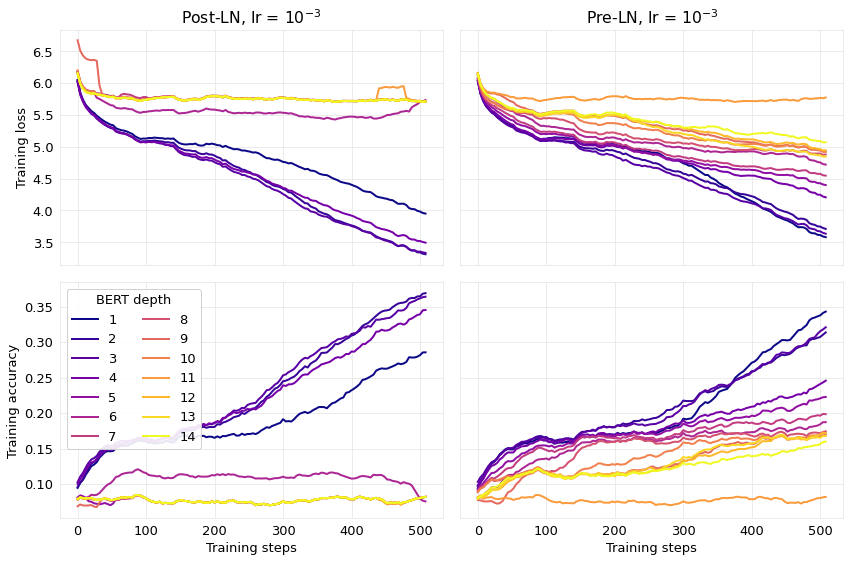

In [19]:
def convolve(y, n=40):
    return np.convolve(y, np.ones(n)/n, mode='valid')

colors = plt.cm.plasma(np.linspace(0, 1, len(per_depth_outputs_sorted)))

fig = plt.figure(figsize=(12, 8))
axes = [[None, None], [None, None]]
axes[0][0] = plt.subplot(221)
axes[0][1] = plt.subplot(222, sharey=axes[0][0])
plt.setp(axes[0][1].get_yticklabels(), visible=False)
axes[1][0] = plt.subplot(223)
axes[1][1] = plt.subplot(224, sharey=axes[1][0])
plt.setp(axes[1][1].get_yticklabels(), visible=False)

plt.setp(axes[0][0].get_xticklabels(), visible=False)
plt.setp(axes[0][1].get_xticklabels(), visible=False)

x = np.arange(len(per_depth_outputs_sorted[2][0][1])-40)
step = 4
x = x[::step]

for i, (depth, data) in enumerate(per_depth_outputs_sorted.items()):
    a, b = data
    (monitored_weights_post, train_losses_post, train_accuracies_post, val_losses_post, val_accuracies_post), (monitored_weights_pre, train_losses_pre, train_accuracies_pre, val_losses_pre, val_accuracies_pre) = data
    axes[0][0].plot(x, convolve(train_losses_post)[::step], color=colors[i], label=depth)
    axes[0][1].plot(x, convolve(train_losses_pre)[::step], color=colors[i], label=depth)
    axes[1][0].plot(x, convolve(train_accuracies_post)[::step], color=colors[i], label=depth)
    axes[1][1].plot(x, convolve(train_accuracies_pre)[::step], color=colors[i], label=depth)

axes[1][0].legend(title='BERT depth', ncol=2)
axes[1][1].set_xlabel('Training steps')
axes[1][0].set_xlabel('Training steps')
axes[0][0].set_title('Post-LN, lr = $10^{-3}$')
axes[0][1].set_title('Pre-LN, lr = $10^{-3}$')
axes[0][0].set_ylabel('Training loss')
axes[1][0].set_ylabel('Training accuracy')
fig.tight_layout()
fig.savefig('loss_acc.pdf')

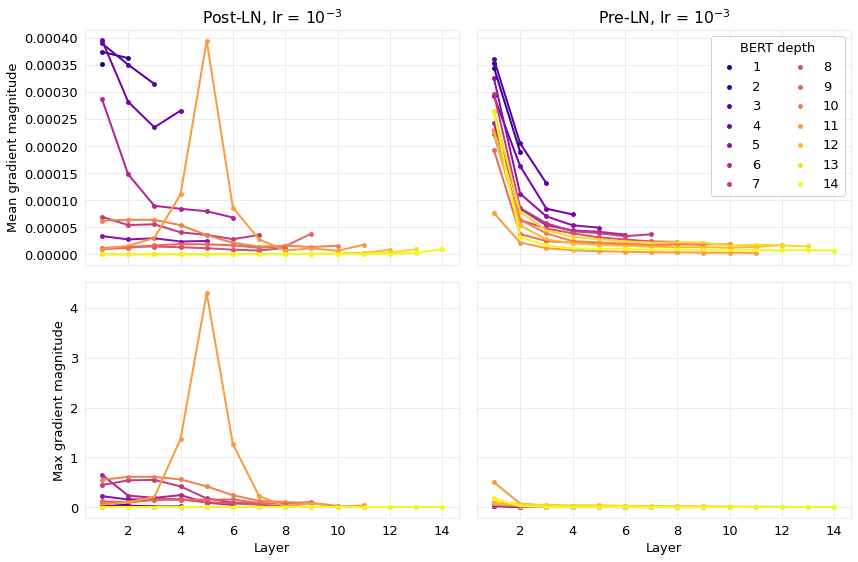

In [20]:
#fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

fig = plt.figure(figsize=(12, 8))
axes = [[None, None], [None, None]]
axes[0][0] = plt.subplot(221)
axes[0][1] = plt.subplot(222, sharey=axes[0][0])
plt.setp(axes[0][1].get_yticklabels(), visible=False)
axes[1][0] = plt.subplot(223)
axes[1][1] = plt.subplot(224, sharey=axes[1][0])
plt.setp(axes[1][1].get_yticklabels(), visible=False)

plt.setp(axes[0][0].get_xticklabels(), visible=False)
plt.setp(axes[0][1].get_xticklabels(), visible=False)

colors = plt.cm.plasma(np.linspace(0, 1, len(per_depth_outputs_sorted)))

for i, (depth, data) in enumerate(per_depth_outputs_sorted.items()):
    a, b = data
    (monitored_weights_post, train_losses_post, train_accuracies_post, val_losses_post, val_accuracies_post), (monitored_weights_pre, train_losses_pre, train_accuracies_pre, val_losses_pre, val_accuracies_pre) = data
    
    depths = np.unique([w['depth'] for w in monitored_weights_pre])
    
    ys_post_max = []
    ys_pre_max = []
    ys_post_mean = []
    ys_pre_mean = []

    for d in depths:
        hist = []
        for j, w in enumerate(monitored_weights_post):
            if w['depth'] == d:
                hist.append(torch.stack(w['hist'], dim=0))
        hist = torch.cat(hist, dim=1) # has shape (num steps, num weights)
        ys_post_mean.append(hist.abs().mean())
        ys_post_max.append(hist.abs().max())

        hist = []
        for j, w in enumerate(monitored_weights_pre):
            if w['depth'] == d:
                hist.append(torch.stack(w['hist'], dim=0))
        hist = torch.cat(hist, dim=1) # has shape (num steps, num weights)
        ys_pre_mean.append(hist.abs().mean())
        ys_pre_max.append(hist.abs().max())

    x = np.arange(1, len(ys_post_mean)+1)
    
    axes[0][0].plot(x, ys_post_mean, color=colors[i])
    axes[0][1].plot(x, ys_pre_mean, color=colors[i])
    axes[1][0].plot(x, ys_post_max, color=colors[i])
    axes[1][1].plot(x, ys_pre_max, color=colors[i])

    axes[0][0].scatter(x, ys_post_mean, color=colors[i], label=depth, s=15)
    axes[0][1].scatter(x, ys_pre_mean, color=colors[i], label=depth, s=15)
    axes[1][0].scatter(x, ys_post_max, color=colors[i], label=depth, s=15)
    axes[1][1].scatter(x, ys_pre_max, color=colors[i], label=depth, s=15)

    #axes[0].scatter(x, ys_post_max, color=colors[i], label=depth, s=15)
    #axes[1].scatter(x, ys_pre_mean, color=colors[i], label=depth, s=15)

axes[0][1].legend(title='BERT depth', ncol=2)
axes[0][0].set_ylabel('Mean gradient magnitude')
axes[1][0].set_ylabel('Max gradient magnitude')
axes[1][0].set_xlabel('Layer')
axes[1][1].set_xlabel('Layer')
axes[0][0].set_title('Post-LN, lr = $10^{-3}$')
axes[0][1].set_title('Pre-LN, lr = $10^{-3}$')
#axes[0][0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#axes[1][0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[1][0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1][1].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.savefig('grad.pdf', bbox_inches='tight')

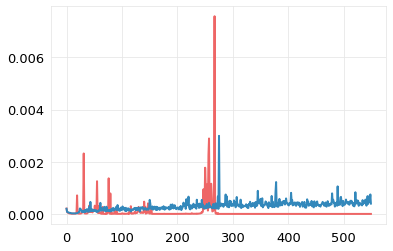

In [43]:
data = per_depth_outputs_sorted[5]
(monitored_weights_post, train_losses_post, train_accuracies_post, val_losses_post, val_accuracies_post), (monitored_weights_pre, train_losses_pre, train_accuracies_pre, val_losses_pre, val_accuracies_pre) = data
depths = [1]
for d in depths:
    hist = []
    for j, w in enumerate(monitored_weights_post):
        if w['depth'] == d-1:
            hist.append(torch.stack(w['hist'], dim=0))
    hist = torch.cat(hist, dim=1) # has shape (num steps, num weights)
    y = hist.abs().mean(1)
    plt.plot(y)

    hist = []
    for j, w in enumerate(monitored_weights_pre):
        if w['depth'] == d-1:
            hist.append(torch.stack(w['hist'], dim=0))
    hist = torch.cat(hist, dim=1) # has shape (num steps, num weights)
    y = hist.abs().mean(1)
    plt.plot(y)

